## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

###Mount Google Drive for access to Google Drive local repo

In [1]:
from google.colab import drive  
import os
from time import strftime, tzset
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()   # set the time zone


# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive

drive.mount('/content/drive')

print(f'Done: {strftime("%a %X %x")}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done: Wed 16:19:08 07/15/20


##**Define Various 'Constants' that Determine Feature Creation, Model Params, etc.**

In [2]:
# # column names of the loaded dataframes:
# items_enc_cols = ['item_id', 'item_tested', 'item_cluster', 'item_category_id', 'item_cat_tested', 'item_group', 'item_category1', 'item_category2', 'item_category3', 'item_category4']
# shops_enc_cols = ['shop_id', 'shop_tested', 'shop_group', 'shop_type', 's_type_broad', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city']
# date_adj_cols =  ['month', 'year', 'season', 'MoY', 'days_in_M', 'weekday_weight', 'retail_sales', 'week_retail_weight']
# train_test_base_cols = ['day', 'week', 'qtr', 'season', 'month', 'price', 'sales', 'shop_id', 'item_id']
# test_cols =      ['ID', 'shop_id', 'item_id']

In [3]:
import os
from time import strftime, tzset
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()   # set the time zone
from collections import OrderedDict
import numpy as np
par = OrderedDict()
par['model_name'] = 'LGBMv10_15ens'   # 'LGBMv10_11ens'  # Name of file model substring to save data submission to (= False if user to input it below)
par['model_type'] = 'LGBM'  # 'HGBR'

# Optional operations to delete irrelevant shops or item categories, and to scale sales by month length, etc.;  set to FALSE if no operation desired
par['SHOPS_TO_DELETE'] = [9,20] #[0,1,8,9,11,13,17,20,23,27,29,30,32,33,40,43,51,54] #[8, 9, 13, 20, 23, 32, 33, 40] # [9,20] #  # False # these are online shops, untested shops, and early-termination + online shops
par['ITEM_CATS_TO_DELETE'] = [8, 10, 32, 59, 80, 81, 82]  #[1,4,8,10,13,14,17,18,32,39,46,48,50,51,52,53,59,66,68,80,81,82] #  #[8, 80, 81, 82]  # False # hokey categories, untested categories, really hokey categories
par['SCALE_MONTH'] = 'week_retail_weight'  # False # scale sales by days in month, number of each weekday, and Russian recession retail sales index

# columns to keep for this round of modeling (dropping some of the less important features to save memory):
par['ITEMS_KEEP_LIST'] = ['item_id', 'item_group', 'item_cluster', 'item_category_id'] #] #, 'item_category4']
par['SHOPS_KEEP_LIST'] = ['shop_id','shop_group'] #,'shop_group'
par['DATE_KEEP_LIST'] =  ['month', 'days_in_M', 'weekday_weight', 'retail_sales', 'week_retail_weight']
par['TRAIN_TEST_BASE_KEEP_LIST'] =   ['month', 'price', 'sales', 'shop_id', 'item_id']

# re-order columns for organized readability, for the (to be created) combined sales-train-test (stt) dataset
par['STT_COLUMN_ORDER'] = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster'] #,   'revenue','item_category4','shop_group'
par['INTEGER_FEATURES'] = [e for e in STT_COLUMN_ORDER if e not in {'sales','price','revenue'}]  
par['CATEGORICAL_FEATURES'] = [e for e in STT_COLUMN_ORDER if e not in {'month','sales','price','revenue'}]

par['STATISTICS'] = OrderedDict()
par['STATISTICS']['sales'] = ['sum', 'median', 'count']
#par['STATISTICS']['price'] = ['median','std']
STATISTICS['revenue'] = ['sum']  # revenue can handle fillna(0) cartesian product; price doesn't make sense, so don't use that
n_stats = len(STATISTICS)

# aggregate statistics columns (initial computation shall be 'sales per month' prediction target for shop_id-item_id pair grouping)
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster']] + STT_COLUMN_ORDER[(n_stats+1):] # start after statistics columns ,['shop_id','item_cluster']
PROVIDED_FEATURES = STT_COLUMN_ORDER[(n_stats+3):]  # start after item_id

# these columns are merged with time-lagged statistics columns
PRE_LAG_COLUMNS = ['month'] + STT_COLUMN_ORDER[(n_stats+1):]

LAGS = [1,2,3,4,5,6,7,8]  # month lags to include in model 

#v10_11ens, followed by removal of features < 26% importance 13-32 months
# but add in L2 'item_cluster_sales_count','shop_id_x_item_id_revenue_sum','item_category_id_sales_count','shop_id_sales_sum','shop_id_x_item_id_sales_count',
# and add L3 'item_id_sales_count','item_id_sales_sum','item_category_id_sales_sum','shop_id_sales_sum','item_cluster_sales_count',
COLUMNS_TO_LAG = {}
for i in LAGS:
    COLUMNS_TO_LAG[i] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum'] 
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 
                     'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 
                     'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 
                     'shop_id_sales_sum', 'shop_id_sales_count', 
                     'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 
                     'shop_group_revenue_sum', 
                     'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 
                     'item_group_sales_sum', 'item_group_revenue_sum', 
                     'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']

COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 
                     'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 
                     'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 
                     'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 
                     'item_category_id_sales_sum', 'item_category_id_sales_count', 
                     'item_group_sales_sum', 
                     'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']

COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 
                     'shop_id_x_item_category_id_sales_sum', 
                     'shop_id_sales_sum', 
                     'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 
                     'item_category_id_sales_sum', 'item_category_id_sales_count', 
                     'item_cluster_sales_sum', 'item_cluster_sales_count']

# keep at least the highest importance feature for each lag, but remove all others with < 20% importance (month 13-32 training)

COLUMNS_TO_LAG[2] = [e for e in COLUMNS_TO_LAG[2] if e not in {'item_group_sales_sum','shop_id_x_item_category_id_sales_sum','shop_id_x_item_cluster_sales_sum','shop_id_x_item_cluster_sales_count'}]
COLUMNS_TO_LAG[3] = [e for e in COLUMNS_TO_LAG[3] if e not in {'item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum','shop_id_x_item_id_sales_count'}]
COLUMNS_TO_LAG[4] = [e for e in COLUMNS_TO_LAG[4] if e not in {'shop_id_x_item_category_id_sales_sum','y_sales','item_cluster_sales_sum'}]
COLUMNS_TO_LAG[5] = [e for e in COLUMNS_TO_LAG[5] if e not in {'item_cluster_sales_sum','item_id_sales_sum','shop_id_x_item_category_id_sales_sum'}]
COLUMNS_TO_LAG[6] = [e for e in COLUMNS_TO_LAG[6] if e not in {'item_id_sales_sum','item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum'}]
COLUMNS_TO_LAG[7] = [e for e in COLUMNS_TO_LAG[7] if e not in {'y_sales','item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum'}]
COLUMNS_TO_LAG[8] = [e for e in COLUMNS_TO_LAG[8] if e not in {'item_id_sales_sum','item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum'}]

LAGGED_STATS_FEATURES = COLUMNS_TO_LAG[1]
for l in LAGS[1:]:
    LAGGED_STATS_FEATURES = LAGGED_STATS_FEATURES + [x for x in COLUMNS_TO_LAG[l] if x not in LAGGED_STATS_FEATURES]
MONTHLY_STT_COLUMNS = PRE_LAG_COLUMNS + LAGGED_STATS_FEATURES

# Define various constants that drive the attributes of the various features
SALES_TRAIN_CLIP_H = 20                   # will also clip item_cnt_month predictions to 20 after the model runs
SALES_TRAIN_CLIP_L = 0                   
SALES_PREDICT_CLIP_H = 20                 # will also clip item_cnt_month predictions to 20 after the model runs
SALES_PREDICT_CLIP_L = 0    

USE_ROBUST_SCALER = True           # scale features to reduce influence of outliers
ROBUST_QUANTILES = (20,80)
USE_MINMAX_SCALER = True           # scale features to use large range of np.int16
MINMAX_RANGE = (0,32000) # int16 = (0,32700); uint16 = (0,65500)
DATA_TYPE = np.int16 #np.float32 #np.int16   np.uint16          # if fill n/a = 0, can adjust feature values to be integer values and save memory
USE_CARTESIAN_FILL = True           # use cartesian fill, or not
CART_PROD_INCLUDES_TEST = False     # include all shop-item pairings from test month as well
CART_FILL_NA_0 = True               # fill n/a cartesian additions with zeros (not good for price-based stats, however)
CARTESIAN_FILL_MONTH_START = 13     # False= no cart.prod          # month number + max lag to start adding Cartesian product rows (i.e., maxlag=6mo and start=10 will cartesian fill from 4 to 33)
TRAIN_START_MONTH = [13] #[13]  # == 24 ==> less than a year of data, but avoids December 'outlier' of 2014
TRAIN_FINAL_MONTH = [29] #[29,32] #,30,32]  #[30] # 
N_VAL_MONTHS = [False] #1 # ; if false, val is all months after training, up to and including 33

LEARNING_RATE = [0.02,0.005] #[0.2,0.1,0.05,0.02,0.01]  # default = 0.1
MAX_ITERATIONS = [8000] # default = 100
EARLY_STOPPING = [200]
REGULARIZATION = [0.4] #[0.4, 0.2, 0.1] # default = 1 for LGBM, 0 for HGBR
VERBOSITY = 1 # 0 is print no info for HGBR

SEED_VALUES = [42]

print(f'Done: {strftime("%a %X %x")}')

Done: Wed 16:19:09 07/15/20


#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020;  Andreas Theodoulou and Michael Gaidis;  (Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***month*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#**Set Up Environment and Load Files**
Load competition data files, import python modules, and set up pandas environment options

###Name the files you wish to load

In [4]:
# List of the *data* files (path relative to GitHub branch), to be loaded into pandas DataFrames

GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
data_files = [  "data_output/items_enc.csv",
                "data_output/shops_enc.csv",
                "data_output/date_adjustments.csv",
                "data_output/train_test_base.csv.gz",
                "readonly/final_project_data/test.csv.gz" ]

###Import Modules, Set Up Environment

In [5]:
# General python libraries/modules used throughout the notebook
import os
from pathlib import Path
import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz
from itertools import product
from collections import OrderedDict
import re
import gc
import time # time.perf_counter()
from time import sleep, localtime, strftime, tzset, strptime
import datetime
from datetime import timedelta
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()   # set the time zone

# Helpful packages for EDA, cleaning, data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import jit      # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas)
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html

# ML packages
import lightgbm as lgb
from lightgbm import LGBMRegressor
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

# Pandas additional enhancements / formatting
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr
pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
pd.set_option("display.width", 220)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
# Tell pandas to print without decimal places if a number is actually an integer, and use 3 decimals if a float (helps keep column width down, and highlights data types)
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

print(f'Done: {strftime("%a %X %x")}')

Done: Wed 16:19:10 07/15/20


###Load the files into pandas dataframes, from Google Drive local repo

In [6]:
%cd "{GDRIVE_REPO_PATH}"

print("Loading Files from Google Drive repo into Colab...\n")

# Loop to load the data files into appropriately-named pandas DataFrames
for path_name in data_files:
    filename = path_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0]
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'Data Frame: {data_frame_name}; n_rows = {len(eval(data_frame_name))}, n_cols = ',end="")
    print(f'{len(eval(data_frame_name).columns)}') #\nData Types: {eval(data_frame_name).dtypes}\n')
    print(f'Column Names: {eval(data_frame_name).columns.to_list()}')
    print(eval(data_frame_name).head(2))
    print("\n")

print(f'Done: {strftime("%a %X %x")}')

/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
Loading Files from Google Drive repo into Colab...

Data Frame: items_enc; n_rows = 22170, n_cols = 10
Column Names: ['item_id', 'item_tested', 'item_cluster', 'item_category_id', 'item_cat_tested', 'item_group', 'item_category1', 'item_category2', 'item_category3', 'item_category4']
   item_id  item_tested  item_cluster  item_category_id  item_cat_tested  item_group  item_category1  item_category2  item_category3  item_category4
0        0            0           100                40                1           6               8               3               7               3
1        1            0           105                76                1           6              11               6              10               5


Data Frame: shops_enc; n_rows = 60, n_cols = 9
Column Names: ['shop_id', 'shop_tested', 'shop_group', 'shop_type', 's_type_broad', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city'

#**Data Preparation, Including Feature Merging and Feature Generation**

###**Helper Functions**

In [7]:
# helper function to print out column datatypes and memory usage, using multiple columns so we don't have to scroll so much
def print_col_info(df,nrows=5):
    """
    instead of the usual single column (plus index) series printout of dtypes and memory use in a dataframe,
    this function combines dtypes and memory use so they use the same index,
    and then prints out multiple columns of length "nrows", where each column is like: "column_dtype \t column_memory_use(MB) \t column_name"
        df = dataframe of interest
            col_dtypes = pd.Series, type obj, index = column_name, values = dtype  (e.g., from the command "df.dtypes")
            col_mem = pd.Series, type int64, index = column_name, values = column memory use (bytes) (e.g., from the command "df.memory_usage(deep=True)")
        nrows = int, tells how many rows of (type/mem/name) to print before moving to a new printout column for the next triplet (type/mem/name)
                if nrows == 0, print all triplets in just one column, with no "wrapping"
    finishes with a printout of total df memory usage
    """
    col_mem = df.memory_usage(deep=True)
    col_mem = col_mem/1e6  #change to MB
    total_mem = col_mem.sum()

    col_dtypes = pd.Series([df.index.dtype], index = ['Index'])  # df.memory_usage includes Index, but df.dtypes does not include Index, so we have to add it
    col_dtypes = pd.concat([col_dtypes,df.dtypes], axis=0)

    col_info_df = pd.concat([col_dtypes, col_mem], axis=1).reset_index().rename(columns={'index':'Column Name', 0:'DType', 1:'MBytes'})


    if nrows == 0:
        print(col_info_df)
    else:
        col_info_df.MBytes = col_info_df.MBytes.apply(lambda x: str(f'{x:.1f}'))
        info_df_len = len(col_info_df)
        cnames = col_info_df.columns
        n_info_cols = len(cnames)
        between_cols = 6  # spaces separating the info-group columns (e.g., between "ColName Dtype Mem" and next column "ColName Dtype Mem")

        # adjust number of rows such that we don't have nasty column with just one or a few rows
        stragglers = info_df_len % nrows
        n_print_cols = info_df_len // nrows
        if (stragglers > nrows/2):
            n_print_cols += 1
        elif (stragglers > 0):
            nrows = info_df_len // n_print_cols
            if info_df_len % n_print_cols > 0:
                nrows += 1

        df_list = []
        for pc in range(n_print_cols):
            df_list.append(col_info_df.shift(periods = -nrows*pc))
        df_print = pd.concat(df_list, axis = 1)
        df_print = df_print.iloc[:nrows][:].fillna(" ")
        col_headers = df_print.columns
        n_df_cols = len(col_headers)
        
        # find max string length in each column
        columnLengths = np.vectorize(len)
        maxColumnLengths = columnLengths(df_print.values.astype(str)).max(axis=0)
        col_widths = np.add(maxColumnLengths,3)

        for r in range(nrows+1):
            if r==0:
                string_list = col_headers
            else:
                string_list = df_print.iloc[r-1][:]
            print_row = ''
            c_count = 0
            for c in range(n_df_cols):
                print_row = print_row + f'{str(string_list[c]):>{col_widths[c]}} '
                c_count += 1
                if c_count == n_info_cols:
                    c_count = 0
                    print_row += " " * between_cols  # extra space between columns of common data

            print(print_row)

    print(f'\nNumber of rows in DataFrame: {len(df):,d}')
    print(f'DataFrame total memory usage: {total_mem:.0f} MB')
    

def rm_df(df):
    """
    try to save memory by deleting unneeded dataframes
    input can be a single dataframe, or a list of dataframes
    """
    if type(df) is list:
        for i in df:
            try: del i
            except: pass
    else:
        try: del df
        except: pass
    gc.enable()
    gc.collect()
    return

print(f'Done: {strftime("%a %X %x")}')

Done: Wed 16:19:13 07/15/20


##**Initial data prep, formatting**

###**Clean up the data, drop undesirable columns, merge shops and items info into train/test dataframe**

In [8]:
# Remove columns with features that we don't use at this time

shops_purged = shops_enc[SHOPS_KEEP_LIST].copy(deep=True) #.rename(columns = SHOPS_COLUMN_RENAME)
items_purged = items_enc[ITEMS_KEEP_LIST].copy(deep=True) #.rename(columns = ITEMS_COLUMN_RENAME)
date_adj_purged = date_adjustments[DATE_KEEP_LIST].copy(deep=True)
stt = train_test_base[TRAIN_TEST_BASE_KEEP_LIST].copy(deep=True)  # 'stt' will be the dataframe for (S)ales of (T)rain appended with (T)est

print(f'shops_purged dataframe length: {len(shops_purged)}\n{shops_purged.head(2)}\n')
print(f'items_purged dataframe length: {len(items_purged)}\n{items_purged.head(2)}\n')
print(f'date_adj_purged dataframe length: {len(date_adj_purged)}\n{date_adj_purged.head(2)}\n')
print(f'stt dataframe length: {len(stt)}\n{stt.head(2)}\n')

rm_df([shops_enc, items_enc, date_adjustments, train_test_base])

print(f'Done: {strftime("%a %X %x")}')

shops_purged dataframe length: 60
   shop_id  shop_group
0        0           7
1        1           7

items_purged dataframe length: 22170
   item_id  item_group  item_cluster  item_category_id
0        0           6           100                40
1        1           6           105                76

date_adj_purged dataframe length: 35
   month  days_in_M  weekday_weight  retail_sales  week_retail_weight
0      0         31           0.979         1.052               1.030
1      1         28           1.069         1.072               1.146

stt dataframe length: 3150043
   month  price  sales  shop_id  item_id
0      0     99      1        2      991
1      0   2599      1        2     1472

Done: Wed 16:19:13 07/15/20


In [9]:
print(f'Shape of stt before merging and deleting: {stt.shape}')
# Merge shops and items into stt
stt = stt.merge(shops_purged, on='shop_id', how='left')
stt = stt.merge(items_purged, on='item_id', how='left')
print(f'Shape of stt after merging shops and items data: {stt.shape}')

# drop undesirable shops and item categories
if SHOPS_TO_DELETE:
    stt = stt.query('shop_id != @SHOPS_TO_DELETE')
    print(f'Shape of stt after deleting shops {SHOPS_TO_DELETE}: {stt.shape}')

if ITEM_CATS_TO_DELETE:
    stt = stt.query('item_category_id != @ITEM_CATS_TO_DELETE')
    print(f'Shape of stt after deleting item categories {ITEM_CATS_TO_DELETE}: {stt.shape}')

stt[INTEGER_FEATURES] = stt[INTEGER_FEATURES].astype('int16')

# scale by date_adjustments as desired
if SCALE_MONTH:
    stt = stt.merge(date_adj_purged[['month',SCALE_MONTH]], on='month', how='left')
    stt.sales = stt.sales * stt[SCALE_MONTH]
    stt.drop(SCALE_MONTH, axis=1, inplace=True) 

# Clip the values of item sales per day (will clip again after grouping by month, and then clip at 20 just before submission of results for grading)
# stt.sales = stt.sales.clip(SALES_TRAIN_CLIP_L, SALES_TRAIN_CLIP_H)

stt['revenue'] = stt.sales * stt.price / 1000

stt[['sales','price','revenue']].astype(np.float32) #apply(pd.to_numeric, downcast= 'np.float32') # use float so fractional date_adj weight is more accurate, and can use price feature #reset index saves 25MB

stt = stt[STT_COLUMN_ORDER]
stt = stt.reset_index(drop=True)

print('\nstt dataframe:'); print_col_info(stt,5); display(stt.head(2))
print(f'Done: {strftime("%a %X %x")}')

Shape of stt before merging and deleting: (3150043, 5)
Shape of stt after merging shops and items data: (3150043, 9)
Shape of stt after deleting shops [9, 20]: (3144500, 9)
Shape of stt after deleting item categories [8, 10, 32, 59, 80, 81, 82]: (3124617, 9)

stt dataframe:
Column Name      DType  MBytes               Column Name    DType MBytes       
     Index      int64     0.0                   item_id    int16    6.2       
     month      int16     6.2                shop_group    int16    6.2       
     sales    float64    25.0          item_category_id    int16    6.2       
   revenue    float64    25.0                item_group    int16    6.2       
   shop_id      int16     6.2              item_cluster    int16    6.2       

Number of rows in DataFrame: 3,124,617
DataFrame total memory usage: 94 MB


,month,sales,revenue,shop_id,item_id,shop_group,item_category_id,item_group,item_cluster
0,0,1.030,0.102,2,991,9,67,5,463
1,0,1.030,2.677,2,1472,9,23,7,585


Done: Wed 16:19:15 07/15/20


##**Compute and Merge Statistics-Based Features on Grouped-by-Month training data**

###Create monthly_stt dataframe, grouping by month the (s)ales_(t)rain_(t)est dataframe

In [10]:
# Compute values in "real time," then in a later code cell we will compute shifted versions

monthly_stt = pd.DataFrame()
def compute_stats(df=stt, monthly_df=monthly_stt, no_merge=True, group=['month','item_id'], 
                  aggstats={'sales':['sum','median']}, aggcolnames=['item_id_sales_sum','item_id_sales_med']):
    """
    function for computing statistics-based features, in an attempt to be flexible if
    we wish to add in extra statistics or extra group-by categories
    no_merge True during first runthrough of this function, to create the initial dataframe into which we will merge various statistics features
    """
    group_df = df.groupby(group).agg(aggstats)
    group_df.columns = aggcolnames
    group_df.reset_index(inplace=True)
    if no_merge:  # this creates the initial monthly-grouped dataframe into which we will merge all other grouped statistics
        monthly_df = group_df.copy(deep=True)
    else:
        monthly_df = monthly_df.merge(group_df, on = group, how = 'left')
    return monthly_df           # original monthly_df merged with aggregated and suitably named stats columns created from ungrouped dataframe (stt)

stats = OrderedDict()
stats_col_names = []
for i,feat in enumerate(STATS_FEATURES):
    if type(feat) is list:
        f = "_x_".join(feat)
        gp = ['month'] + feat
    else:
        f = feat
        gp = ['month'] + [feat]
    agg_stats = OrderedDict()
    agg_names = []
    if i == 0:
        for pf in PROVIDED_FEATURES:
            agg_stats[pf] = ['first']
            agg_names.append(pf)
    for k,v in STATISTICS.items():
        agg_stats[k] = v
        for val in v:
            agg_names.append(f + "_" + k + "_" + val)
            stats_col_names.append(f + "_" + k + "_" + val)
    stats[f] = {'group':gp, 'aggstats':agg_stats, 'aggnames':agg_names}

no_merge = True
print('Completed: ',end='')
for k,v in stats.items():
    monthly_stt = compute_stats(stt, monthly_stt, no_merge, v['group'], v['aggstats'], v['aggnames']).copy(deep=True)
    no_merge = False
    print(f'{k}, ',end='')
print('\nDone')

monthly_stt = monthly_stt.rename(columns={'shop_id_x_item_id_sales_sum':'y_sales'})  # rename for convenience
stats_col_names = ['y_sales'] + stats_col_names[1:]
monthly_stt.y_sales = monthly_stt.y_sales.clip(SALES_TRAIN_CLIP_L, SALES_TRAIN_CLIP_H)
monthly_stt = monthly_stt[MONTHLY_STT_COLUMNS]   # MONTHLY_STT_COLUMNS = PRE_LAG_COLUMNS + LAGGED_STATS_FEATURES

# always do minmax scaling after robust scaling; and do inverse scaling with minmax first, then robust
if USE_ROBUST_SCALER:
    robust_scalers = {} # squeeze outliers into central distribution
    for aggcol in LAGGED_STATS_FEATURES:
        robust_scalers[aggcol] = RobustScaler(with_centering=False,quantile_range=ROBUST_QUANTILES)
        monthly_stt[aggcol] = robust_scalers[aggcol].fit_transform(monthly_stt[aggcol].to_numpy().reshape(-1, 1))
if USE_MINMAX_SCALER:
    minmax_scalers = {}  # apply min-max scaler to make best use of np.int16 and memory usage
    for aggcol in LAGGED_STATS_FEATURES:
        minmax_scalers[aggcol] = MinMaxScaler(feature_range=MINMAX_RANGE)
        if (DATA_TYPE == np.int16) or (DATA_TYPE == np.uint16):
            monthly_stt[aggcol] = monthly_stt[aggcol].fillna(0)
        monthly_stt[aggcol] = minmax_scalers[aggcol].fit_transform(monthly_stt[aggcol].to_numpy().reshape(-1, 1))

monthly_stt.sort_values(['month','shop_id','item_id'],inplace=True)

print(f'\nmonthly_stt fully grouped and merged: memory usage = {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes')

if (DATA_TYPE == np.int16) or (DATA_TYPE == np.uint16):
    monthly_stt = monthly_stt.round()
monthly_stt = monthly_stt.reset_index(drop=True).astype(DATA_TYPE)

print('\nmonthly_stt (after reset_index) and downcast:')
print_col_info(monthly_stt,6)
print('\n')
print(monthly_stt.head())
print(monthly_stt.describe())
print(f'Done: {strftime("%a %X %x")}')

Completed: shop_id_x_item_id, shop_id_x_item_category_id, shop_id_x_item_cluster, shop_id, item_id, shop_group, item_category_id, item_group, item_cluster, 
Done

monthly_stt fully grouped and merged: memory usage = 435 MBytes

monthly_stt (after reset_index) and downcast:
        Column Name    DType MBytes                                      Column Name    DType MBytes                                     Column Name    DType MBytes                           Column Name    DType MBytes                                     Column Name    DType MBytes       
              Index    int64    0.0                                     item_cluster    int16    3.6          shop_id_x_item_category_id_sales_count    int16    3.6                   item_id_sales_count    int16    3.6                          item_group_revenue_sum    int16    3.6       
              month    int16    3.6                                          y_sales    int16    3.6                shop_id_x_item_cluster_sales_s

##**Add Cartesian Product rows to the training data:**
Idea is to help the model by informing it that we explicitly have no information about certain relevant shop_item pairs in certain months.

###*Use numpy to create Cartesian Product:*
Each month in train data will have additional rows such that the Cartesian Product of all shops and items ALREADY PRESENT IN THAT MONTH will be included.</br>

When we merge lagged features below, we will only forward-shift the shop-item pairs that are present in the later month.</br>
*(Might revisit later, if memory requirements not too big, can forward-shift all shop-item pairs.)*

#####*If not adding Cartesian Product, or if fillna(0), can round various features to integers to save memory:*

In [11]:
rm_df(stt)

tic = time.perf_counter()
maxlags = max(LAGS)
if USE_CARTESIAN_FILL:
    # Create cartesian product so model has info to look at for every relevant shop-item-month combination in the months desired
    # add enough months of cartesian product that after time-LAGS, we end up with CartProds in months CARTESIAN_FILL_MONTH_START through 33 (don't need to fill month 34)
    matrix = []
    for i in range(max(CARTESIAN_FILL_MONTH_START-maxlags,0),34):
        if CART_PROD_INCLUDES_TEST:
            sales = monthly_stt.query('(month == @i)|(month == 34)')  # include all test shop-items in with cartesian product from that month
        else:
            sales = monthly_stt.query('month == @i')  # include only shop-items present in that month
        matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))    

    df = pd.DataFrame(np.vstack(matrix), columns=['month','shop_id','item_id'])

    # # merge in the rows from training set with month < CART_FILL_MO_START ? (and > maxlags )??
    # now merge in the rows for the test set, month 34
    df = df.append(monthly_stt[monthly_stt.month ==34][['month','shop_id','item_id']], ignore_index=True)
    df = df.reset_index(drop=True)
    print(f'Column Data Types: \n{df.dtypes}\ndf memory usage: {df.memory_usage(deep=True).sum()/1e6:.0f} MBytes')
    print(f'Number of months: {df.month.nunique():,d}\nNumber of shops: {df.shop_id.nunique():,d}\nNumber of items: {df.item_id.nunique():,d}\nDataFrame length: {len(df):,d}\n')

    # merge the shops_purged dataframe: (can't just merge with monthly_stt, because cartesian product df has more shop-item pairs)
    df = df.merge(shops_purged, how='left', on='shop_id')
    # Next, merge the items_purged dataframe to be sure we cover all items in the cartesian product df
    df = df.merge(items_purged, how='left', on='item_id')

    df.sort_values(['month','shop_id','item_id'],inplace=True)
    df = df.reset_index(drop=True)
    # Now we merge in the real-time block-month data and see if memory requirements aren't overloading Colab:
    if CART_FILL_NA_0 or (DATA_TYPE == np.int16) or (DATA_TYPE == np.uint16):
        df = df.merge(monthly_stt, how='left',on=PRE_LAG_COLUMNS).fillna(0).reset_index(drop=True) # can store as integers, saving memory, but issue with price fill values... need to kill price stats / use revenue
    else:
        df = df.merge(monthly_stt, how='left',on=PRE_LAG_COLUMNS).reset_index(drop=True)   # leave cartesian product row unknowns as N/A (float, not integer)

    print('Cartesian-product df:')
else:
    df = monthly_stt.copy(deep=True)
    print('df with no Cartesian-products:')

toc = time.perf_counter()
print(f"df creation time: {timedelta(seconds = toc - tic)}")

rm_df(monthly_stt)

df = df.astype(DATA_TYPE) #np.int16 #.apply(pd.to_numeric, downcast= np.float32)
df=df.reset_index(drop=True)
print_col_info(df,6)
print(f'\ndf.head:\n{df.head(2)}')
print(f'\ndf.tail:\n{df.tail(2)}\n')
# display(df.describe())

print(f'\nDone: {strftime("%a %X %x")}')

Column Data Types: 
month      int16
shop_id    int16
item_id    int16
dtype: object
df memory usage: 55 MBytes
Number of months: 30
Number of shops: 53
Number of items: 20,106
DataFrame length: 9,124,719

Cartesian-product df:
df creation time: 0:00:20.744563
    Column Name    DType  MBytes                                      Column Name    DType  MBytes                                     Column Name    DType  MBytes                           Column Name    DType  MBytes                                     Column Name    DType  MBytes       
          Index    int64     0.0                                 item_category_id    int16    18.2          shop_id_x_item_category_id_sales_count    int16    18.2                   item_id_sales_count    int16    18.2                          item_group_revenue_sum    int16    18.2       
          month    int16    18.2                                          y_sales    int16    18.2                shop_id_x_item_cluster_sales_sum    int16  

##**Compute and Merge the Time-Lag Features into Train + Test data sets**

###*Merge lag stats and check dataframe memory requirements:*

In [12]:
%%time
# shift the stuff and merge into df
#   drop any rows in t-lag that don't have matching shop-item pair at time t
print(f'Unlagged DataFrame length: {len(df):,d}\n')
df['y_target'] = df.y_sales.copy(deep=True)  # keep an unlagged version of shop_item sales per month as our training / test target value
lag_merge_on_cols = ['month','shop_id','item_id']
cols_to_shift = lag_merge_on_cols + LAGGED_STATS_FEATURES
lag_cols_df = df[cols_to_shift].copy(deep=True)  
df.drop(LAGGED_STATS_FEATURES, axis=1, inplace=True)  # reduce size of df in memory so merging below doesn't crash Colab
for lag in LAGS:
    cols_to_shift = lag_merge_on_cols + COLUMNS_TO_LAG[lag]
    lag_df = lag_cols_df[cols_to_shift].copy(deep=True)  
    lag_df.eval('month = month + @lag', inplace=True)
    suffix = '_L'+str(lag)
    lagged_col_names = lag_merge_on_cols + [x + suffix for x in COLUMNS_TO_LAG[lag]]
    lag_df.columns = lagged_col_names
    print(f'Column names for lag = {lag}: {lag_df.columns}')
    lag_df = lag_df.astype(DATA_TYPE)
    if CART_FILL_NA_0 or (DATA_TYPE == np.int16) or (DATA_TYPE == np.uint16):
        df = df.merge(lag_df, on = lag_merge_on_cols, how = 'left').fillna(0)  # 'left' serves to discard rows from earlier month if there is no match with later month
        print('fillna(0) done\n')
    else:
        df = df.merge(lag_df, on = lag_merge_on_cols, how = 'left')
    df = df.reset_index(drop=True)
    df = df.astype(DATA_TYPE)
print(df.head(2))
print(df.dtypes)

first_train_month = min(TRAIN_START_MONTH)
print(f'Lagged DataFrame length: {len(df):,d}\n')
df = df.query('month >= @first_train_month')      # remove early months that don't participate in model training
df = df.reset_index(drop=True)
df = df.astype(DATA_TYPE)  #.apply(pd.to_numeric, downcast= 'float')
print('lagged features df (after downcast):')
print_col_info(df,8)
print(f'\ndf.head():\n{df.head()}')

print(f'\nDone: {strftime("%a %X %x")}\n')

Unlagged DataFrame length: 9,124,719

Column names for lag = 1: Index(['month', 'shop_id', 'item_id', 'y_sales_L1', 'shop_id_x_item_id_sales_median_L1', 'shop_id_x_item_id_sales_count_L1', 'shop_id_x_item_id_revenue_sum_L1', 'shop_id_x_item_category_id_sales_sum_L1',
       'shop_id_x_item_category_id_sales_median_L1', 'shop_id_x_item_category_id_sales_count_L1', 'shop_id_x_item_cluster_sales_sum_L1', 'shop_id_x_item_cluster_sales_median_L1', 'shop_id_sales_sum_L1',
       'shop_id_sales_count_L1', 'item_id_sales_sum_L1', 'item_id_sales_median_L1', 'item_id_sales_count_L1', 'item_id_revenue_sum_L1', 'shop_group_revenue_sum_L1', 'item_category_id_sales_sum_L1',
       'item_category_id_sales_count_L1', 'item_category_id_revenue_sum_L1', 'item_group_sales_sum_L1', 'item_group_revenue_sum_L1', 'item_cluster_sales_sum_L1', 'item_cluster_sales_count_L1',
       'item_cluster_revenue_sum_L1'],
      dtype='object')
fillna(0) done

Column names for lag = 2: Index(['month', 'shop_id', 'item_id

#**Modeling**
*   Train/Val/Test split
*   Model Fit & Validate
*   Test/Submission Results





##**Train/Test split**

In [13]:
def TTSplit(df=df,train_start=TRAIN_START_MONTH[0],train_end=TRAIN_FINAL_MONTH[0], val_months=N_VAL_MONTHS[0]):
    """
    Split data into training months + val months up to 33 + month 34 test
    """
    data = df.copy(deep=True) 
    # data = df.drop(['shop_typeB','shop_fd','shop_fd_sales_L1'], axis=1)

    data.y_target = data.y_target.fillna(0)     #.clip(INTEGER_MULTIPLIER*SALES_TRAIN_CLIP_L, INTEGER_MULTIPLIER*SALES_TRAIN_CLIP_H)

    train = data.query('(month >= @train_start) & (month <= @train_end)')
    y_train = train['y_target'].astype(np.float32)
    y_train = y_train.reset_index(drop=True)
    X_train = train.drop(['y_target'], axis=1)
    X_train = X_train.reset_index(drop=True)

    if val_months:
        val= data.query('(month > (@train_end)) & (month <= (@train_end + @val_months)) & (month < 34)')
    else:
        val = data.query('((month > (@train_end)) & (month < 34)) | (month == 33)')
    y_val = val['y_target'].astype(np.float32)
    y_val = y_val.reset_index(drop=True)
    X_val = val.drop(['y_target'], axis=1)
    X_val = X_val.reset_index(drop=True)

    X_test = data.query('month == 34').drop(['y_target'], axis=1)
    X_test = X_test.reset_index(drop=True)

    rm_df([data, train, val])

    feature_names = X_train.columns
    X_train_np = X_train.to_numpy(dtype = DATA_TYPE)
    X_val_np = X_val.to_numpy(dtype = DATA_TYPE)
    X_test_np = X_test.to_numpy(dtype = DATA_TYPE)
    display(X_train.head(2))
    print(f'\nsize of X_train_np = {X_train_np.nbytes/(10**6):0.1f} MB')

    rm_df([X_train, X_val])

    return X_test,y_train,y_val,feature_names,X_train_np,X_val_np,X_test_np

print(f'Done: {strftime("%a %X %x")}')

Done: Wed 16:20:53 07/15/20


##**LightGBM - Lightweight Gradient-Boosted Decision Tree**
##**SK_HGBR - SKLearn Histogram Gradient Boosting Regressor**

In [14]:
def unscale(scaler,target):
    return scaler.inverse_transform(target.reshape(-1, 1)).squeeze()


def GBDT_model(mod_type, X_train_np, y_train, X_val_np, y_val, X_test_np, LR=0.1, reg=0.8, maxiter=2000, estop=50, seed_val=42, verb=1):
    if mod_type == 'LGBM':
        model_gbdt = LGBMRegressor(
            objective='regression', 
            boosting='gbdt',
            metric='rmse',
            device_type='cpu',
            learning_rate=LR,
            num_iterations=maxiter,
            early_stopping_round=estop,
            feature_fraction=reg,
            verbosity = verb,
            seed=seed_val
        )

        # categorical_feature=1,2,3,4,5,6  LGBM doesn't like this as a parameter
        #output_freq=10,
        #min_data_per_group=100,
        #max_cat_to_onehot=8,
        #top_k=20,
        #max_bin=255,
        #min_data_in_bin=3,
        #verbosity=2, = 1 = 0??

        tic = time.perf_counter()
        model_gbdt.fit(X_train_np, y_train,
                    eval_set=[(X_val_np, y_val)])
        toc = time.perf_counter()
        model_fit_time = datetime.datetime.utcfromtimestamp(toc-tic).strftime('%H:%M:%S')
        print(f"model LGBM fit time: {model_fit_time}")
        best_iter = 0#model_gbdt.best_iteration

    if mod_type == 'HGBR':
        # TTSplit should use TRAIN_FINAL = 33 (train on all data), and it will return also val=month33 for calculation at end (only)
        model_gbdt = HistGradientBoostingRegressor(
            learning_rate=LR, 
            max_iter=maxiter, 
            l2_regularization = reg,
            early_stopping=False, 
            verbosity = verb,
            random_state=seed_val)
    
        tic = time.perf_counter()
        model_gbdt.fit(X_train_np, y_train)
        toc = time.perf_counter()
        model_fit_time = datetime.datetime.utcfromtimestamp(toc-tic).strftime('%H:%M:%S')
        print(f"model HGBR fit time: {model_fit_time}")
        best_iter = maxiter
        
    tic = time.perf_counter()
    y_pred_train =  model_gbdt.predict(X_train_np)
    y_pred_val =    model_gbdt.predict(X_val_np)
    y_pred_test =   model_gbdt.predict(X_test_np)
    y_train =       y_train.to_numpy()
    y_val =         y_val.to_numpy()
    best_val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
    # always do minmax scaling after robust scaling; and do inverse scaling with minmax first, then robust
    if USE_MINMAX_SCALER:
        y_pred_train =  unscale(minmax_scalers['y_sales'],  y_pred_train)
        y_pred_val =    unscale(minmax_scalers['y_sales'],  y_pred_val)
        y_pred_test =   unscale(minmax_scalers['y_sales'],  y_pred_test)
        y_train =       unscale(minmax_scalers['y_sales'],  y_train)
        y_val =         unscale(minmax_scalers['y_sales'],  y_val)
    if USE_ROBUST_SCALER:
        y_pred_train =  unscale(robust_scalers['y_sales'],  y_pred_train)
        y_pred_val =    unscale(robust_scalers['y_sales'],  y_pred_val)
        y_pred_test =   unscale(robust_scalers['y_sales'],  y_pred_test)
        y_train =       unscale(robust_scalers['y_sales'],  y_train)
        y_val =         unscale(robust_scalers['y_sales'],  y_val)
    y_pred_train =  y_pred_train.clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
    y_pred_val =    y_pred_val.clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
    y_pred_test =   y_pred_test.clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H) 
    toc = time.perf_counter()
    predict_time = datetime.datetime.utcfromtimestamp(toc-tic).strftime('%H:%M:%S')
    print(f"Transform and Predict train/val/test time: {predict_time}")

    train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
    train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
    print(f'R^2 train =  {train_score:.4f}    R^2 val =  {val_score:.4f}')
    print(f'RMSE train = {train_rmse:.4f}    RMSE val = {val_rmse:.4f}\n')

    return model_gbdt, y_pred_test, train_score, val_score, train_rmse, val_rmse, best_iter, best_val_rmse, model_fit_time, predict_time

print(f'Done: {strftime("%a %X %x")}')

Done: Wed 16:20:53 07/15/20


##**Parameters**

In [15]:
if not model_name:
    model_name = input("Enter the Model Name Substring for Output File Naming (like: LGBMv4mg_01 )")
%cd "{GDRIVE_REPO_PATH}"
model_name_ens = model_name + "_train_val_scores.csv"
model_name_params = model_name + "_params.csv"

df_mem = df.memory_usage(deep=True)
total_df_mem = df_mem.sum()
n_training_runs = len(SEED_VALUES)*len(N_VAL_MONTHS)*len(TRAIN_FINAL_MONTH)*len(TRAIN_START_MONTH)*len(EARLY_STOPPING)*len(MAX_ITERATIONS)*len(REGULARIZATION)*len(LEARNING_RATE)


# parameters_columns = ['Parameter_Name','Values']
# parameters_rows = [['Local Time', f'{strftime("%a %X %x")}'], ['Model Name', model_name], ['Model Type', model_type]
                   
#                                 params_df = pd.DataFrame(parameters_rows, columns = parameters_columns)
#                                 params_df.to_csv("./models_and_predictions/" + model_name_params, index=False)
print(f'{model_name}  Model Type: {model_type};  {strftime("%a %X %x")};  Size of df = {total_df_mem/(10**6):0.1f} MB, Shape = {df.shape};  N Training Runs for this Model: {n_training_runs}')
print(f'STT_COLUMN_ORDER = {STT_COLUMN_ORDER}')
print(f'STATS_FEATURES = {STATS_FEATURES}')
print(f"STATISTICS['sales'] = {STATISTICS['sales']},  STATISTICS['revenue'] = {STATISTICS['revenue']};  SALES_TRAIN_CLIP_L = {SALES_TRAIN_CLIP_L}, SALES_PREDICT_CLIP_L = {SALES_PREDICT_CLIP_L}")
print(f'Shops Deleted = {SHOPS_TO_DELETE}; Item Categories Deleted = {ITEM_CATS_TO_DELETE}; Monthly Scaling = {SCALE_MONTH}')
print(f'Lags(months) = {LAGS}')
for lag in LAGS:
    print(f'COLUMNS_TO_LAG[{lag}] = {COLUMNS_TO_LAG[lag]}')
print(f'CARTESIAN_FILL_MONTH_START = {CARTESIAN_FILL_MONTH_START},  TRAIN_START_MONTH = {TRAIN_START_MONTH},  TRAIN_FINAL_MONTH = {TRAIN_FINAL_MONTH}, N_VAL_MONTHS = {N_VAL_MONTHS}')
print(f'LEARNING_RATE = {LEARNING_RATE}, MAX_ITERATIONS = {MAX_ITERATIONS}, EARLY_STOPPING = {EARLY_STOPPING}, REGULARIZATION = {REGULARIZATION}, SEED_VALUES = {SEED_VALUES}')
print(f'USE_ROBUST_SCALER = {USE_ROBUST_SCALER}, ROBUST_QUANTILES = {ROBUST_QUANTILES}, USE_MINMAX_SCALER = {USE_MINMAX_SCALER}, MINMAX_RANGE = {MINMAX_RANGE}, DATA_TYPE = {DATA_TYPE}')
print(f'USE_CARTESIAN_FILL = {USE_CARTESIAN_FILL}, CART_PROD_INCLUDES_TEST = {CART_PROD_INCLUDES_TEST}, CART_FILL_NA_0 = {CART_FILL_NA_0}')

/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
LGBMv10_15ens  Model Type: LGBM;  Wed 16:20:53 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  N Training Runs for this Model: 2
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum'

##**K-Fold Training Splits; Ensemble Average; Save Intermediate Results**

In [16]:
ensemble_feature_names = []
ensemble_y_pred_test = []
ensemble_df_columns = ['lr', 'reg', 'max_iter', 'estop', 'start', 'end', 'n_val_mo', 'seed', 'trR2', 'valR2', 'tr_rmse', 'val_rmse', 'best_iter', 'best_val_rmse', 'model_time','predict_time','total_time']
ensemble_df_rows = []
for lr in LEARNING_RATE:
    for reg in REGULARIZATION:
        for maxit in MAX_ITERATIONS:
            for estop in EARLY_STOPPING:
                for train_start_mo in TRAIN_START_MONTH:
                    for train_final_mo in TRAIN_FINAL_MONTH:
                        for val_mo in N_VAL_MONTHS:
                            for seed in SEED_VALUES:
                                print(f'\n\n\nBelow: {len(ensemble_df_rows)+1} of {n_training_runs}: LR = {lr}; LFF = {reg}, train_start = {train_start_mo}; train_end = {train_final_mo}; seed = {seed}\n')
                                time0 = time.time()
                                X_test, y_train, y_val, feature_names, X_train_np, X_val_np, X_test_np = TTSplit(df=df, train_start=train_start_mo, train_end=train_final_mo, val_months=val_mo)
                                time1 = time.time(); ttsplit_time = datetime.datetime.utcfromtimestamp(time1 - time0).strftime('%H:%M:%S'); print(f'TTSplit Execution Time = {ttsplit_time}')
                                model_fit, y_pred_test, train_r2, val_r2, train_rmse, val_rmse, best_iter, best_val_rmse, model_fit_time, predict_time = GBDT_model(model_type, 
                                                                                                                                                                    X_train_np, y_train, X_val_np, y_val, X_test_np, 
                                                                                                                                                                    lr, reg, maxit, estop, VERBOSITY, seed)
                                time2 = time.time(); model_time = datetime.datetime.utcfromtimestamp(time2 - time1).strftime('%H:%M:%S')

                                ensemble_feature_names.append(feature_names)
                                ensemble_y_pred_test.append(y_pred_test)
                                ensemble_df_rows.append([lr,reg,maxit,estop,train_start_mo,train_final_mo,val_mo,seed,train_r2,val_r2,train_rmse,val_rmse,best_iter,best_val_rmse,model_fit_time,predict_time,model_time])

                                # intermediate save after each model fit set of parameters, in case of crash or disconnect from Colab
                                # Simple ensemble averaging
                                y_test_pred_avg = np.mean(ensemble_y_pred_test, axis=0)
                                # Merge the test predictions with IDs from the original test dataset, and keep only columns "ID" and "item_cnt_month"
                                y_submission = pd.DataFrame.from_dict({'item_cnt_month':y_test_pred_avg,'shop_id':X_test.shop_id,'item_id':X_test.item_id})
                                y_submission = test.merge(y_submission, on=['shop_id','item_id'], how= 'left').reset_index(drop=True).drop(['shop_id','item_id'],axis=1)
                                y_submission.to_csv("./models_and_predictions/" + model_name + '_submission.csv', index=False)
                                ensemble_scores = pd.DataFrame(ensemble_df_rows, columns = ensemble_df_columns)
                                ensemble_scores.to_csv("./models_and_predictions/" + model_name_ens, index=False)
                                time3 = time.time(); iteration_time = datetime.datetime.utcfromtimestamp(time3 - time0).strftime('%H:%M:%S')
                                print(f'TTSplit Execution Time = {ttsplit_time};  Model fit/predict Execution Time = {model_time};  Total Iteration Execution Time = {iteration_time}')
                                print(f'Above: {len(ensemble_df_rows)} of {n_training_runs}: LR = {lr}; LFF = {reg}, train_start = {train_start_mo}; train_end = {train_final_mo}; seed = {seed}\n')

display(ensemble_scores)

print(f'\nDone: {strftime("%a %X %x")}\n')




Below: 1 of 2: LR = 0.02; LFF = 0.4, train_start = 13; train_end = 29; seed = 42



,month,shop_id,item_id,shop_group,item_group,item_cluster,item_category_id,y_sales_L1,shop_id_x_item_id_sales_median_L1,shop_id_x_item_id_sales_count_L1,shop_id_x_item_id_revenue_sum_L1,shop_id_x_item_category_id_sales_sum_L1,shop_id_x_item_category_id_sales_median_L1,shop_id_x_item_category_id_sales_count_L1,shop_id_x_item_cluster_sales_sum_L1,...,item_cluster_sales_count_L2,item_cluster_revenue_sum_L2,y_sales_L3,shop_id_sales_sum_L3,item_id_sales_sum_L3,item_id_sales_count_L3,item_id_revenue_sum_L3,item_category_id_sales_sum_L3,item_category_id_sales_count_L3,item_cluster_sales_count_L3,item_id_sales_sum_L4,y_sales_L5,y_sales_L6,item_id_sales_sum_L7,y_sales_L8
0,13,2,30,9,6,158,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1488
1,13,2,31,9,18,158,37,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



size of X_train_np = 595.7 MB
TTSplit Execution Time = 00:00:01


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1647.01
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's rmse: 1635.33
[3]	valid_0's rmse: 1624.11
[4]	valid_0's rmse: 1613.35
[5]	valid_0's rmse: 1603.42
[6]	valid_0's rmse: 1593.45
[7]	valid_0's rmse: 1585.18
[8]	valid_0's rmse: 1575.67
[9]	valid_0's rmse: 1566.39
[10]	valid_0's rmse: 1558.64
[11]	valid_0's rmse: 1549.81
[12]	valid_0's rmse: 1541.69
[13]	valid_0's rmse: 1534.94
[14]	valid_0's rmse: 1528.07
[15]	valid_0's rmse: 1520.86
[16]	valid_0's rmse: 1514.64
[17]	valid_0's rmse: 1507.63
[18]	valid_0's rmse: 1500.98
[19]	valid_0's rmse: 1495.29
[20]	valid_0's rmse: 1490.07
[21]	valid_0's rmse: 1483.52
[22]	valid_0's rmse: 1477.51
[23]	valid_0's rmse: 1471.84
[24]	valid_0's rmse: 1466.07
[25]	valid_0's rmse: 1461.35
[26]	valid_0's rmse: 1455.96
[27]	valid_0's rmse: 1451.04
[28]	valid_0's rmse: 1446.09
[29]	valid_0's rmse: 1442.09
[30]	valid_0's rmse: 1437.29
[31]	valid_0's rmse: 1432.83
[32]	valid_0's rmse: 1428.37
[33]	valid_0's rms

,month,shop_id,item_id,shop_group,item_group,item_cluster,item_category_id,y_sales_L1,shop_id_x_item_id_sales_median_L1,shop_id_x_item_id_sales_count_L1,shop_id_x_item_id_revenue_sum_L1,shop_id_x_item_category_id_sales_sum_L1,shop_id_x_item_category_id_sales_median_L1,shop_id_x_item_category_id_sales_count_L1,shop_id_x_item_cluster_sales_sum_L1,...,item_cluster_sales_count_L2,item_cluster_revenue_sum_L2,y_sales_L3,shop_id_sales_sum_L3,item_id_sales_sum_L3,item_id_sales_count_L3,item_id_revenue_sum_L3,item_category_id_sales_sum_L3,item_category_id_sales_count_L3,item_cluster_sales_count_L3,item_id_sales_sum_L4,y_sales_L5,y_sales_L6,item_id_sales_sum_L7,y_sales_L8
0,13,2,30,9,6,158,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1488
1,13,2,31,9,18,158,37,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



size of X_train_np = 595.7 MB
TTSplit Execution Time = 00:00:02


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Streaming output truncated to the last 5000 lines.
[3012]	valid_0's rmse: 1263.88
[3013]	valid_0's rmse: 1263.88
[3014]	valid_0's rmse: 1263.88
[3015]	valid_0's rmse: 1263.87
[3016]	valid_0's rmse: 1263.88
[3017]	valid_0's rmse: 1263.88
[3018]	valid_0's rmse: 1263.88
[3019]	valid_0's rmse: 1263.87
[3020]	valid_0's rmse: 1263.82
[3021]	valid_0's rmse: 1263.81
[3022]	valid_0's rmse: 1263.81
[3023]	valid_0's rmse: 1263.81
[3024]	valid_0's rmse: 1263.81
[3025]	valid_0's rmse: 1263.8
[3026]	valid_0's rmse: 1263.8
[3027]	valid_0's rmse: 1263.8
[3028]	valid_0's rmse: 1263.8
[3029]	valid_0's rmse: 1263.79
[3030]	valid_0's rmse: 1263.79
[3031]	valid_0's rmse: 1263.78
[3032]	valid_0's rmse: 1263.77
[3033]	valid_0's rmse: 1263.76
[3034]	valid_0's rmse: 1263.76
[3035]	valid_0's rmse: 1263.75
[3036]	valid_0's rmse: 1263.72
[3037]	valid_0's rmse: 1263.72
[3038]	valid_0's rmse: 1263.68
[3039]	valid_0's rmse: 1263.68
[3040]	valid_0's rmse: 1263.67
[3041]	valid_0's rmse: 1263.67
[3042]	valid_0's rmse: 

,lr,reg,max_iter,estop,start,end,n_val_mo,seed,trR2,valR2,tr_rmse,val_rmse,best_iter,best_val_rmse,model_time,predict_time,total_time
0,0.020,0.400,8000,200,13,29,False,42,0.572,0.427,0.743,0.783,0,"1,253.473",00:35:36,00:13:33,00:49:09
1,0.005,0.400,8000,200,13,29,False,42,0.549,0.427,0.763,0.784,0,"1,254.303",01:24:53,00:35:09,02:00:02



Done: Wed 19:10:10 07/15/20



##**Feature Importances**

                             feature  value  norm_value lag                   feature_base
0             item_id_sales_count_L1   9378         100   1            item_id_sales_count
1               item_id_sales_sum_L1   9199      98.090   1              item_id_sales_sum
2                       item_cluster   8256      88.040   0                   item_cluster
3                            item_id   7862      83.830   0                        item_id
4                   item_category_id   7540      80.400   0               item_category_id
5             item_id_revenue_sum_L1   7261      77.430   1            item_id_revenue_sum
6                            shop_id   6958      74.190   0                        shop_id
7                         y_sales_L1   6754      72.020   1                        y_sales
51       item_cluster_sales_count_L2   2536      27.040   2       item_cluster_sales_count
52              item_id_sales_sum_L3   2535      27.030   3              item_id_sales_sum

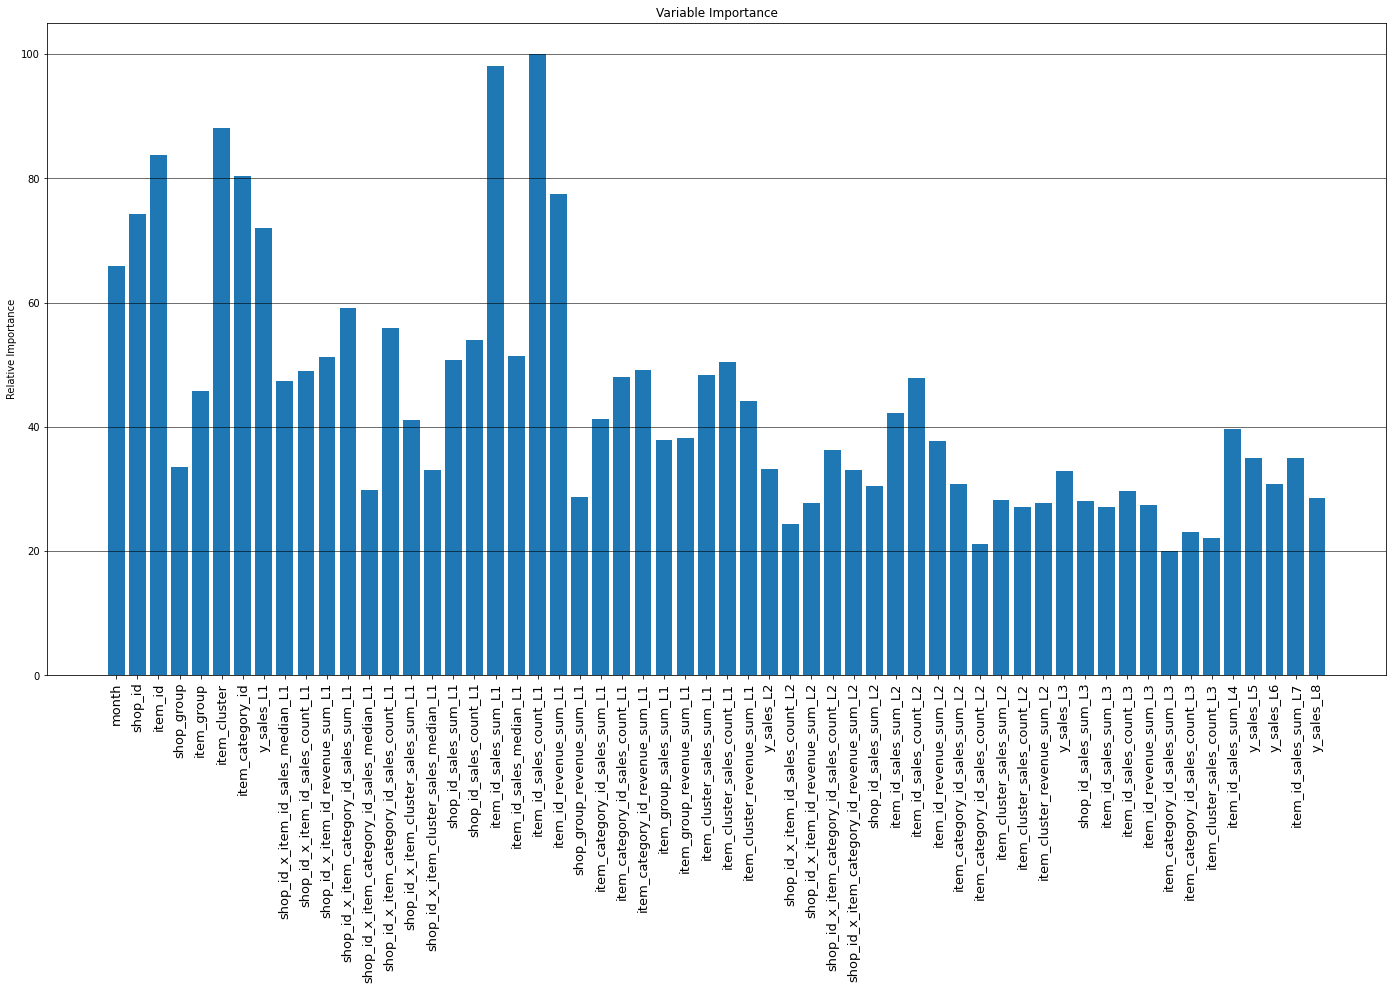

In [17]:
# Plot feature importance - Results Visualization
if model_type == 'LGBM':
    print_threshold = 25
    feature_importance = model_fit.feature_importances_
    fi = pd.DataFrame(zip(feature_names,feature_importance),columns=['feature','value'])
    fi = fi.sort_values('value',ascending=False,ignore_index=True)
    fi['norm_value'] = round(100*fi.value / fi.value.max(),2)
    fi['lag'] = fi.feature.apply(lambda x: (x.split('L')[-1]) if len(x.split('L'))> 1 else 0)
    fi['feature_base'] = fi.feature.apply(lambda x: x.split('_L')[0])
    print(fi.iloc[list(range(0,8))+list(range(-7,0)),:]) #[[1,3,5,7,-7,-5]][:])
    model_name_fi = model_name + "_feature_importance.csv"
    fi.to_csv("./models_and_predictions/" + model_name_fi, index=False)
    # printout to assist with removing low-importance features for following runs
    if fi.norm_value.min() < print_threshold:
        fi_low = fi[fi.norm_value < print_threshold]
        fi_low = fi_low.sort_values(['lag','norm_value'])
        fi_low.norm_value = fi_low.norm_value.apply(lambda x: f'{x:.1f}')
        fi_low['lag_feature_importance'] = fi_low.apply(lambda x: str(x.lag) + " " + x.feature_base[7:] + " " + x.norm_value,axis=1)
        print(fi_low.lag_feature_importance.to_list())
        print(fi_low.feature_base.to_list())
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.arange(feature_importance.shape[0])
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(24,12)) 
    plt.bar(pos, feature_importance[sorted_idx], align='center')
    plt.xticks(pos, feature_names[sorted_idx])  # ensemble_feature_names[-1]
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.tick_params(axis='x', which='major', labelsize = 13, labelrotation=90)
    plt.grid(True,which='major',axis='y')
    plt.tick_params(axis='y', which='major', grid_color='black',grid_alpha=0.7)
    # plt.savefig('LGBM_feature_importance_v1.4_mg.png')
    plt.show()

##**Document Results**

In [18]:
# Printout for copy-paste version control

print('\n------------------------------------------\n------------------------------------------')
print(f'{model_name}  Model Type: {model_type}\n------------------------------------------\nCoursera: ')
print(f'{strftime("%a %X %x")};  Size of df = {total_df_mem/(10**6):0.1f} MB, Shape = {df.shape};  Size of X_train_np = {X_train_np.nbytes/(10**6):0.1f} MB;  N Training Runs for this Model: {n_training_runs}')
print(f'SHOPS_TO_DELETE = {SHOPS_TO_DELETE}; ITEM_CATS_TO_DELETE = {ITEM_CATS_TO_DELETE}; SCALE_MONTH = {SCALE_MONTH}; Lags(months) = {LAGS}')
print(f'STT_COLUMN_ORDER = {STT_COLUMN_ORDER}')
print(f'STATS_FEATURES = {STATS_FEATURES}')
print(f"STATISTICS = {STATISTICS}; SALES_TRAIN_CLIP_L = {SALES_TRAIN_CLIP_L}; SALES_TRAIN_CLIP_H = {SALES_TRAIN_CLIP_H}; SALES_PREDICT_CLIP_L = {SALES_PREDICT_CLIP_L}; SALES_PREDICT_CLIP_H = {SALES_PREDICT_CLIP_H}")
for lag in LAGS:
    print(f'COLUMNS_TO_LAG[{lag}] = {COLUMNS_TO_LAG[lag]}')
print(f'CARTESIAN_FILL_MONTH_START = {CARTESIAN_FILL_MONTH_START}; TRAIN_START_MONTH = {TRAIN_START_MONTH}; TRAIN_FINAL_MONTH = {TRAIN_FINAL_MONTH}; ',end="")
print(f'N_VAL_MONTHS = {N_VAL_MONTHS}; USE_CARTESIAN_FILL = {USE_CARTESIAN_FILL}; CART_PROD_INCLUDES_TEST = {CART_PROD_INCLUDES_TEST}; CART_FILL_NA_0 = {CART_FILL_NA_0}')
print(f'USE_ROBUST_SCALER = {USE_ROBUST_SCALER}; ROBUST_QUANTILES = {ROBUST_QUANTILES}; USE_MINMAX_SCALER = {USE_MINMAX_SCALER}; MINMAX_RANGE = {MINMAX_RANGE}; DATA_TYPE = {DATA_TYPE}')
print(f'LEARNING_RATE = {LEARNING_RATE}; MAX_ITERATIONS = {MAX_ITERATIONS}; EARLY_STOPPING = {EARLY_STOPPING}; REGULARIZATION = {REGULARIZATION}; SEED_VALUES = {SEED_VALUES}')
print('------')
print(ensemble_scores)
print('------')
print(ensemble_scores.describe(percentiles=[], include=np.number))
print(f'------\nHighest and Lowest Feature Importance for Final Model:\n{fi.iloc[list(range(0,8))+list(range(-7,0)),:]}\n------')
print(y_submission.head(8))
print('------------------------------------------\n------------------------------------------\n------------------------------------------\n')


------------------------------------------
------------------------------------------
LGBMv10_15ens  Model Type: LGBM
------------------------------------------
Coursera: 
Wed 19:10:11 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 595.7 MB;  N Training Runs for this Model: 2
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y

##**Stop Execution / Ensemble**

In [19]:
# Dummy cell to stop the execution so we don't run any of the random code below (if we select "Run All", e.g.)
b4 = b5

NameError: ignored

In [ ]:
'''

Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: v7_ens21 8/10 public and private LB scores are: 0.974590 and 0.971219

LGBMv10_15ens 8/10 public and private LB scores are: 0.984054 and 0.979126
* LGBMv10_13ens 8/10 public and private LB scores are: 0.976077 and 0.973442
* LGBMv10_11ens 8/10 public and private LB scores are: 0.977330 and 0.974200  same as v10_10ens, but removed all features with importance below 20%
*** LGBMv10_10ens 8/10 public and private LB scores are: 0.975422 and 0.971682
LGBMv10_09ens 8/10 public and private LB scores are: 0.984677 and 0.984238
LGBMv10_08ens 8/10 public and private LB scores are: 0.984238 and 0.982864
LGBMv10_07ens 8/10 public and private LB scores are: 0.985275 and 0.985093
LGBMv10_06ens 8/10 public and private LB scores are: 0.984912 and 0.983360
LGBMv10_v9_18noscaler 8/10 8/10 public and private LB scores are: 0.984643 and 0.985256
LGBMv10_v9_18 8/10 public and private LB scores are: 0.982740 and 0.983633  robust scaler used
LGBMv9_18ens 8/10 public and private LB scores are: 0.984137 and 0.984686
LGBMv9_09clip 8/10 public and private LB scores are: 0.984877 and 0.985790
LGBMv9_08clip 8/10 public and private LB scores are: 0.985158 and 0.986282
LGBMv9_04ens (less memory) 8/10 public and private LB scores are: 0.981707 and 0.985473
* LGBMv9_03ens 8/10 public and private LB scores are: 0.975438 and 0.973606
LGBMv8_v7_21B_ens 8/10 public and private LB scores are: 0.976147 and 0.972920
*** LGBMv6v7_bag06 8/10 public and private LB scores are: 0.974873 and 0.971385
* LGBMv6v7_bag05 8/10 public and private LB scores are: 0.975973 and 0.972537
**** v7_ens21 8/10 public and private LB scores are: 0.974590 and 0.971219
** v7_ens20 8/10 public and private LB scores are: 0.975499 and 0.971916
* v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554
v7_03 8/10 public and private LB scores are: 0.980832 and 0.975157
v7_ens07 8/10 public and private LB scores are: 0.980749 and 0.978082

------------------------------------------
------------------------------------------
LGBMv10_15ens  Model Type: LGBM
------------------------------------------
Coursera: 8/10 public and private LB scores are: 0.984054 and 0.979126
Wed 19:10:11 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 595.7 MB;  N Training Runs for this Model: 2
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTESIAN_FILL_MONTH_START = 13; TRAIN_START_MONTH = [13]; TRAIN_FINAL_MONTH = [29]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CART_FILL_NA_0 = True
USE_ROBUST_SCALER = True; ROBUST_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.02, 0.005]; MAX_ITERATIONS = [8000]; EARLY_STOPPING = [200]; REGULARIZATION = [0.4]; SEED_VALUES = [42]
------
     lr   reg  max_iter  estop  start  end  n_val_mo  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse model_time predict_time total_time
0 0.020 0.400      8000    200     13   29     False    42 0.572  0.427    0.743     0.783          0      1,253.473   00:35:36     00:13:33   00:49:09
1 0.005 0.400      8000    200     13   29     False    42 0.549  0.427    0.763     0.784          0      1,254.303   01:24:53     00:35:09   02:00:02
------
         lr   reg  max_iter  estop  start  end  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse
count     2     2         2      2      2    2     2     2      2        2         2          2              2
mean  0.013 0.400      8000    200     13   29    42 0.561  0.427    0.753     0.784          0      1,253.888
std   0.011     0         0      0      0    0     0 0.017  0.001    0.014     0.000          0          0.587
min   0.005 0.400      8000    200     13   29    42 0.549  0.427    0.743     0.783          0      1,253.473
50%   0.013 0.400      8000    200     13   29    42 0.561  0.427    0.753     0.784          0      1,253.888
max   0.020 0.400      8000    200     13   29    42 0.572  0.427    0.763     0.784          0      1,254.303
------
Highest and Lowest Feature Importance for Final Model:
                             feature  value  norm_value lag                   feature_base
0             item_id_sales_count_L1   9378         100   1            item_id_sales_count
1               item_id_sales_sum_L1   9199      98.090   1              item_id_sales_sum
2                       item_cluster   8256      88.040   0                   item_cluster
3                            item_id   7862      83.830   0                        item_id
4                   item_category_id   7540      80.400   0               item_category_id
5             item_id_revenue_sum_L1   7261      77.430   1            item_id_revenue_sum
6                            shop_id   6958      74.190   0                        shop_id
7                         y_sales_L1   6754      72.020   1                        y_sales
51       item_cluster_sales_count_L2   2536      27.040   2       item_cluster_sales_count
52              item_id_sales_sum_L3   2535      27.030   3              item_id_sales_sum
53  shop_id_x_item_id_sales_count_L2   2293      24.450   2  shop_id_x_item_id_sales_count
54   item_category_id_sales_count_L3   2170      23.140   3   item_category_id_sales_count
55       item_cluster_sales_count_L3   2067      22.040   3       item_cluster_sales_count
56   item_category_id_sales_count_L2   1987      21.190   2   item_category_id_sales_count
57     item_category_id_sales_sum_L3   1879      20.040   3     item_category_id_sales_sum
------
   ID  item_cnt_month
0   0           0.781
1   1           0.079
2   2           1.174
3   3           0.247
4   4           0.875
5   5           0.697
6   6           0.514
7   7           0.095
------------------------------------------
------------------------------------------
------------------------------------------

LGBMv10_14ens  Model Type: LGBM
------------------------------------------
Coursera: 8/10 public and private LB scores are: 1.003743 and 0.999306
Wed 16:11:56 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 595.7 MB;  N Training Runs for this Model: 1
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTESIAN_FILL_MONTH_START = 13; TRAIN_START_MONTH = [13]; TRAIN_FINAL_MONTH = [29]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CART_FILL_NA_0 = True
USE_ROBUST_SCALER = True; ROBUST_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.03]; MAX_ITERATIONS = [100]; EARLY_STOPPING = [100]; REGULARIZATION = [0.4]; SEED_VALUES = [42]
------
     lr   reg  max_iter  estop  start  end  n_val_mo  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse model_time predict_time total_time
0 0.030 0.400       100    100     13   29     False    42 0.443  0.393    0.847     0.807          0      1,290.627   00:01:52     00:00:17   00:02:10
------
         lr   reg  max_iter  estop  start  end  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse
count     1     1         1      1      1    1     1     1      1        1         1          1              1
mean  0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
std     nan   nan       nan    nan    nan  nan   nan   nan    nan      nan       nan        nan            nan
min   0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
50%   0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
max   0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
------
Highest and Lowest Feature Importance for Final Model:
                                      feature  value  norm_value lag                            feature_base
0                                  y_sales_L1    157         100   1                                 y_sales
1                        item_id_sales_sum_L1    151      96.180   1                       item_id_sales_sum
2                     item_id_sales_median_L1    141      89.810   1                    item_id_sales_median
3                            item_category_id    128      81.530   0                        item_category_id
4                      item_id_sales_count_L1    127      80.890   1                     item_id_sales_count
5                                  y_sales_L3    118      75.160   3                                 y_sales
6                                  y_sales_L5    109      69.430   5                                 y_sales
7            shop_id_x_item_id_sales_count_L1    104      66.240   1           shop_id_x_item_id_sales_count
51  shop_id_x_item_category_id_sales_count_L2     14       8.920   2  shop_id_x_item_category_id_sales_count
52                       item_id_sales_sum_L3     13       8.280   3                       item_id_sales_sum
53                item_cluster_sales_count_L3     13       8.280   3                item_cluster_sales_count
54           shop_id_x_item_id_revenue_sum_L2     12       7.640   2           shop_id_x_item_id_revenue_sum
55                item_cluster_revenue_sum_L2     11       7.010   2                item_cluster_revenue_sum
56                     item_id_revenue_sum_L3      7       4.460   3                     item_id_revenue_sum
57                item_cluster_sales_count_L2      5       3.180   2                item_cluster_sales_count
------
   ID  item_cnt_month
0   0           0.511
1   1           0.085
2   2           1.015
3   3           0.225
4   4           0.444
5   5           0.650
6   6           0.878
7   7           0.107

------------------------------------------
------------------------------------------
LGBMv10_13ens  Model Type: LGBM
------------------------------------------
Coursera: 8/10 public and private LB scores are: 0.976077 and 0.973442
Wed 15:31:20 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 671.7 MB;  N Training Runs for this Model: 32
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTESIAN_FILL_MONTH_START = 13; TRAIN_START_MONTH = [13]; TRAIN_FINAL_MONTH = [29, 32]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CART_FILL_NA_0 = True
USE_ROBUST_SCALER = True; ROBUST_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.05, 0.03]; MAX_ITERATIONS = [4000]; EARLY_STOPPING = [100]; REGULARIZATION = [0.4, 0.1]; SEED_VALUES = [42, 43, 44, 45]
------
      lr   reg  max_iter  estop  start  end  n_val_mo  seed  trR2  valR2  tr_rmse  val_rmse      model_time    predict_time      total_time
0  0.050 0.400      4000    100     13   29     False    42 0.558  0.426    0.755     0.784 00:02:22.796827 00:00:14.489164 00:02:37.381230
1  0.050 0.400      4000    100     13   29     False    43 0.558  0.426    0.755     0.784 00:02:17.317521 00:00:14.820192 00:02:32.234120
2  0.050 0.400      4000    100     13   29     False    44 0.558  0.426    0.755     0.784 00:02:16.263556 00:00:15.967203 00:02:32.325884
3  0.050 0.400      4000    100     13   29     False    45 0.558  0.426    0.755     0.784 00:02:15.919261 00:00:16.058071 00:02:32.073075
4  0.050 0.400      4000    100     13   32     False    42 0.530  0.406    0.771     0.801 00:01:35.580222 00:00:07.445304 00:01:43.121361
5  0.050 0.400      4000    100     13   32     False    43 0.530  0.406    0.771     0.801 00:01:36.062911 00:00:07.566848 00:01:43.728209
6  0.050 0.400      4000    100     13   32     False    44 0.530  0.406    0.771     0.801 00:01:35.617126 00:00:07.505136 00:01:43.219945
7  0.050 0.400      4000    100     13   32     False    45 0.530  0.406    0.771     0.801 00:01:36.287204 00:00:07.578750 00:01:43.964531
8  0.050 0.100      4000    100     13   29     False    42 0.553  0.417    0.760     0.790 00:04:11.752687 00:00:37.579412 00:04:49.431376
9  0.050 0.100      4000    100     13   29     False    43 0.553  0.417    0.760     0.790 00:04:15.647176 00:00:37.730305 00:04:53.478163
10 0.050 0.100      4000    100     13   29     False    44 0.553  0.417    0.760     0.790 00:04:14.993836 00:00:38.232967 00:04:53.322473
11 0.050 0.100      4000    100     13   29     False    45 0.553  0.417    0.760     0.790 00:04:12.614834 00:00:38.111595 00:04:50.826675
12 0.050 0.100      4000    100     13   32     False    42 0.544  0.413    0.759     0.797 00:04:33.974918 00:00:38.127535 00:05:12.201225
13 0.050 0.100      4000    100     13   32     False    43 0.544  0.413    0.759     0.797 00:04:36.700797 00:00:37.756702 00:05:14.556847
14 0.050 0.100      4000    100     13   32     False    44 0.544  0.413    0.759     0.797 00:04:37.805054 00:00:38.317471 00:05:16.223452
15 0.050 0.100      4000    100     13   32     False    45 0.544  0.413    0.759     0.797 00:04:40.377308 00:00:39.191690 00:05:19.669424
16 0.030 0.400      4000    100     13   29     False    42 0.564  0.426    0.750     0.784 00:03:37.931630 00:00:30.874559 00:04:08.905109
17 0.030 0.400      4000    100     13   29     False    43 0.564  0.426    0.750     0.784 00:03:37.574522 00:00:31.429285 00:04:09.103564
18 0.030 0.400      4000    100     13   29     False    44 0.564  0.426    0.750     0.784 00:03:34.492661 00:00:31.136816 00:04:05.725260
19 0.030 0.400      4000    100     13   29     False    45 0.564  0.426    0.750     0.784 00:03:34.360388 00:00:31.442585 00:04:05.901330
20 0.030 0.400      4000    100     13   32     False    42 0.531  0.403    0.770     0.804 00:02:16.444590 00:00:15.645488 00:02:32.191298
21 0.030 0.400      4000    100     13   32     False    43 0.531  0.403    0.770     0.804 00:02:17.903275 00:00:15.714108 00:02:33.714707
22 0.030 0.400      4000    100     13   32     False    44 0.531  0.403    0.770     0.804 00:02:18.900813 00:00:16.256304 00:02:35.256094
23 0.030 0.400      4000    100     13   32     False    45 0.531  0.403    0.770     0.804 00:02:20.429069 00:00:16.108170 00:02:36.637124
24 0.030 0.100      4000    100     13   29     False    42 0.548  0.420    0.763     0.788 00:06:18.510325 00:00:57.076864 00:07:15.686213
25 0.030 0.100      4000    100     13   29     False    43 0.548  0.420    0.763     0.788 00:06:18.194431 00:00:58.029560 00:07:16.323680
26 0.030 0.100      4000    100     13   29     False    44 0.548  0.420    0.763     0.788 00:06:14.427514 00:00:57.702900 00:07:12.228839
27 0.030 0.100      4000    100     13   29     False    45 0.548  0.420    0.763     0.788 00:06:16.986484 00:00:58.380872 00:07:15.469333
28 0.030 0.100      4000    100     13   32     False    42 0.527  0.410    0.773     0.798 00:05:05.247308 00:00:43.026598 00:05:48.373926
29 0.030 0.100      4000    100     13   32     False    43 0.527  0.410    0.773     0.798 00:05:04.072583 00:00:42.961761 00:05:47.134938
30 0.030 0.100      4000    100     13   32     False    44 0.527  0.410    0.773     0.798 00:04:59.065499 00:00:43.050558 00:05:42.215707
31 0.030 0.100      4000    100     13   32     False    45 0.527  0.410    0.773     0.798 00:04:56.972108 00:00:42.970691 00:05:40.045130
------
         lr   reg  max_iter  estop  start    end   seed  trR2  valR2  tr_rmse  val_rmse              model_time            predict_time              total_time
count    32    32        32     32     32     32     32    32     32       32        32                      32                      32                      32
mean  0.040 0.250      4000    100     13 30.500 43.500 0.544  0.415    0.763     0.793  0 days 00:03:44.725763  0 days 00:00:30.883920  0 days 00:04:15.708445
std   0.010 0.152         0      0      0  1.524  1.136 0.013  0.008    0.008     0.007  0 days 00:01:31.107823  0 days 00:00:16.019000  0 days 00:01:47.075789
min   0.030 0.100      4000    100     13     29     42 0.527  0.403    0.750     0.784  0 days 00:01:35.580222  0 days 00:00:07.445304  0 days 00:01:43.121361
50%   0.040 0.250      4000    100     13 30.500 43.500 0.546  0.415    0.761     0.794  0 days 00:03:54.842158  0 days 00:00:34.510998  0 days 00:04:29.267470
max   0.050 0.400      4000    100     13     32     45 0.564  0.426    0.773     0.804  0 days 00:06:18.510325  0 days 00:00:58.380872  0 days 00:07:16.323680
------
Highest and Lowest Feature Importance for Final Model:
                             feature  value  norm_value lag                   feature_base
0             item_id_revenue_sum_L1   1936         100   1            item_id_revenue_sum
1                       item_cluster   1905      98.400   0                   item_cluster
2             item_id_sales_count_L1   1872      96.690   1            item_id_sales_count
3          item_cluster_sales_sum_L1   1863      96.230   1         item_cluster_sales_sum
4                   item_category_id   1783      92.100   0               item_category_id
5                            shop_id   1783      92.100   0                        shop_id
6                            item_id   1716      88.640   0                        item_id
7               item_id_sales_sum_L1   1714      88.530   1              item_id_sales_sum
51              shop_id_sales_sum_L3    954      49.280   3              shop_id_sales_sum
52  shop_id_x_item_id_sales_count_L2    930      48.040   2  shop_id_x_item_id_sales_count
53                        y_sales_L5    921      47.570   5                        y_sales
54                        y_sales_L6    869      44.890   6                        y_sales
55              shop_id_sales_sum_L2    841      43.440   2              shop_id_sales_sum
56                        y_sales_L8    760      39.260   8                        y_sales
57                        shop_group    689      35.590   0                     shop_group
------
   ID  item_cnt_month
0   0           0.913
1   1           0.079
2   2           1.124
3   3           0.226
4   4           1.030
5   5           0.689
6   6           0.400
7   7           0.090
------
15 of 32: LR = 0.05; LFF = 0.1, train_start = 13; train_end = 32; seed = 44
[2339]	valid_0's rmse: 1275.27
model LGBM fit time: 0:04:37
Transform and Predict train/val/test time: 0:00:38
R^2 train =  0.5440    R^2 val =  0.4127
RMSE train = 0.7594    RMSE val = 0.7968
Total Iteration Execution Time = 0:05:18
------
16 of 32: LR = 0.05; LFF = 0.1, train_start = 13; train_end = 32; seed = 45
[2339]	valid_0's rmse: 1275.27
model LGBM fit time: 0:04:40
Transform and Predict train/val/test time: 0:00:39
R^2 train =  0.5440    R^2 val =  0.4127
RMSE train = 0.7594    RMSE val = 0.7968
Total Iteration Execution Time = 0:05:22
------
17 of 32: LR = 0.03; LFF = 0.4, train_start = 13; train_end = 29; seed = 42
[1893]	valid_0's rmse: 1255.04
model LGBM fit time: 0:03:38
Transform and Predict train/val/test time: 0:00:30
R^2 train =  0.5635    R^2 val =  0.4260
RMSE train = 0.7503    RMSE val = 0.7843
Total Iteration Execution Time = 0:04:11
------
20 of 32: LR = 0.03; LFF = 0.4, train_start = 13; train_end = 29; seed = 45
[1893]	valid_0's rmse: 1255.04
model LGBM fit time: 0:03:34
Transform and Predict train/val/test time: 0:00:31
R^2 train =  0.5635    R^2 val =  0.4260
RMSE train = 0.7503    RMSE val = 0.7843
Total Iteration Execution Time = 0:04:08
------------------------------------------
------------------------------------------
------------------------------------------


------------------------------------------
------------------------------------------
LGBMv10_11ens  model_type: LGBM
same as v10_10ens, but removed all features with importance below 20%
------------------------------------------
Coursera: 8/10 public and private LB scores are: 0.977330 and 0.974200
Wed 12:48:03 07/15/20;  Size of df = 635.1 MB, Shape = (6226880, 51);  Size of X_train_np = 579.1 MB;  N Training Runs for this Model: 4
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'item_id_revenue_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTESIAN_FILL_MONTH_START = 13; TRAIN_START_MONTH = [13]; TRAIN_FINAL_MONTH = [29, 32]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CART_FILL_NA_0 = True
USE_ROBUST_SCALER = True; ROBUST_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.05]; MAX_ITERATIONS = [4000]; EARLY_STOPPING = [100]; REGULARIZATION = [0.4]; SEED_VALUES = [42, 43]
------
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.400     13   29    42 0.582  0.433    0.734     0.779
1 0.050 0.400     13   29    43 0.568  0.425    0.746     0.785
2 0.050 0.400     13   32    42 0.521  0.399    0.778     0.806
3 0.050 0.400     13   32    43 0.531  0.411    0.770     0.798
------
         lr    ff  start    end   seed  trR2  valR2  tr_rmse  val_rmse
count     4     4      4      4      4     4      4        4         4
mean  0.050 0.400     13 30.500 42.500 0.550  0.417    0.757     0.792
std       0     0      0  1.732  0.577 0.029  0.015    0.020     0.012
min   0.050 0.400     13     29     42 0.521  0.399    0.734     0.779
50%   0.050 0.400     13 30.500 42.500 0.549  0.418    0.758     0.792
max   0.050 0.400     13     32     43 0.582  0.433    0.778     0.806
------
CPU 2 of 4: LR = 0.05; LFF = 0.4, train_start = 13; train_end = 29; seed = 43
[1300]	valid_0's rmse: 1256.21
model_lgbm fit in 0:12:45.955235
Predict and MinMax and Robust scalers inverse transforms done in 0:04:26.703348
R^2 train =  0.5681    R^2 val =  0.4249
RMSE train = 0.7463    RMSE val = 0.7851
TTSplit Execution Time = 0:00:03.526503
Model fit/predict Execution Time = 0:17:12.767771
Submission Execution Time = 0:00:00.659729
Total Iteration Execution Time = 0:17:16.954003
------
CPU 4 of 4: LR = 0.05; LFF = 0.4, train_start = 13; train_end = 32; seed = 43
[633]	valid_0's rmse: 1276.79
model_lgbm fit in 0:08:20.095208
Predict and MinMax and Robust scalers inverse transforms done in 0:01:35.307487
R^2 train =  0.5309    R^2 val =  0.4109
RMSE train = 0.7703    RMSE val = 0.7980
TTSplit Execution Time = 0:00:01.556474
Model fit/predict Execution Time = 0:09:55.510320
Total Iteration Execution Time = 0:09:57.782245
------
Highest and Lowest Feature Importance for Final Model:
                            feature  value  norm_value lag                  feature_base
0            item_id_sales_count_L1    824         100   1           item_id_sales_count
1              item_id_sales_sum_L1    823      99.880   1             item_id_sales_sum
2                           item_id    656      79.610   0                       item_id
3                      item_cluster    647      78.520   0                  item_cluster
4                  item_category_id    622      75.490   0              item_category_id
5            item_id_revenue_sum_L1    598      72.570   1           item_id_revenue_sum
6                           shop_id    581      70.510   0                       shop_id
7                             month    574      69.660   0                         month
43  item_category_id_sales_count_L3    234      28.400   3  item_category_id_sales_count
44        item_cluster_sales_sum_L2    231      28.030   2        item_cluster_sales_sum
45                       y_sales_L6    216      26.210   6                       y_sales
46        shop_group_revenue_sum_L1    214      25.970   1        shop_group_revenue_sum
47                       y_sales_L8    206          25   8                       y_sales
48      item_cluster_sales_count_L2    202      24.510   2      item_cluster_sales_count
49  item_category_id_sales_count_L2    175      21.240   2  item_category_id_sales_count
------
   ID  item_cnt_month
0   0           0.835
1   1           0.078
2   2           1.202
3   3           0.209
4   4           0.916
5   5           0.703
6   6           0.573
7   7           0.095
------------------------------------------
------------------------------------------
------------------------------------------

LGBMv10_10ens   Wed 06:42:21 07/15/20;  Size of df = 1008.8 MB, Shape = (6226880, 81);  Size of X_train_np = 926.5 MB;  N Training Runs for this Model: 4
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4], SEED_VALUES = [42, 43]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.400     13   29    42 0.568  0.430    0.747     0.781
1 0.050 0.400     13   29    43 0.582  0.428    0.734     0.783
2 0.050 0.400     13   32    42 0.521  0.401    0.778     0.805
3 0.050 0.400     13   32    43 0.513  0.407    0.785     0.801
         lr    ff  start    end   seed  trR2  valR2  tr_rmse  val_rmse
count     4     4      4      4      4     4      4        4         4
mean  0.050 0.400     13 30.500 42.500 0.546  0.416    0.761     0.793
std       0     0      0  1.732  0.577 0.034  0.015    0.025     0.012
min   0.050 0.400     13     29     42 0.513  0.401    0.734     0.781
25%   0.050 0.400     13     29     42 0.519  0.405    0.744     0.783
50%   0.050 0.400     13 30.500 42.500 0.544  0.417    0.763     0.792
75%   0.050 0.400     13     32     43 0.571  0.428    0.780     0.802
max   0.050 0.400     13     32     43 0.582  0.430    0.785     0.805
   ID  item_cnt_month
0   0           0.740
1   1           0.076
2   2           1.193
3   3           0.240
4   4           0.978
5   5           0.711
6   6           0.495
7   7           0.105
Coursera: 8/10 public and private LB scores are: 0.975422 and 0.971682
4 of 4: LR = 0.05; LFF = 0.4, train_start = 13; train_end = 32; seed = 43
Early stopping, best iteration is:
[418]	valid_0's rmse: 1281.43
model_lgbm fit in 0:09:00.514980
Predict and MinMax and Robust scalers inverse transforms done in 0:01:01.297574
sklearn metrics r2 done in 0:00:00.064039
np and sklearn metrics rmse done in 0:00:00.038124
R^2 train =  0.5126    R^2 val =  0.4067
RMSE train = 0.7851    RMSE val = 0.8008
TTSplit Execution Time = 0:00:02.396470
Model fit/predict Execution Time = 0:10:01.918102
Submission Execution Time = 0:00:00.717338
Total Iteration Execution Time = 0:10:05.031910


LGBMv10_09ens   Tue 23:12:32 07/14/20;  Size of df = 722.3 MB, Shape = (6226880, 58);  Size of X_train_np = 585.4 MB;  N Training Runs for this Model: 3
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.008], LGBM_MAX_ITERATIONS = 10000, LGBM_EARLY_STOPPING = 200, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42, 43, 44]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.008 0.300     13   29    42 0.556  0.426    0.756     0.784
1 0.008 0.300     13   29    43 0.559  0.424    0.754     0.786
2 0.008 0.300     13   29    44 0.560  0.427    0.753     0.784
         lr    ff  start  end   seed  trR2  valR2  tr_rmse  val_rmse
count     3     3      3    3      3     3      3        3         3
mean  0.008 0.300     13   29     43 0.558  0.426    0.755     0.785
std       0     0      0    0      1 0.002  0.002    0.002     0.001
min   0.008 0.300     13   29     42 0.556  0.424    0.753     0.784
25%   0.008 0.300     13   29 42.500 0.558  0.425    0.754     0.784
50%   0.008 0.300     13   29     43 0.559  0.426    0.754     0.784
75%   0.008 0.300     13   29 43.500 0.559  0.427    0.755     0.785
max   0.008 0.300     13   29     44 0.560  0.427    0.756     0.786
   ID  item_cnt_month
0   0           0.833
1   1           0.082
2   2           1.153
3   3           0.224
4   4           1.138
5   5           0.665
6   6           0.466
7   7           0.124
Coursera: 8/10 public and private LB scores are: 0.984677 and 0.984238
1 of 3: LR = 0.008; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
[7621]	valid_0's rmse: 1254.57
Early stopping, best iteration is:
[7421]	valid_0's rmse: 1254.56
model_lgbm fit in 1:12:32.058546
Predict and MinMax and Robust scalers inverse transforms done in 0:33:24.823812
sklearn metrics r2 done in 0:00:00.162204
np and sklearn metrics rmse done in 0:00:00.041076
R^2 train =  0.5564    R^2 val =  0.4264
RMSE train = 0.7563    RMSE val = 0.7840
TTSplit Execution Time = 0:00:01.403296
Model fit/predict Execution Time = 1:45:57.087654
Submission Execution Time = 0:00:00.789723
Total Iteration Execution Time = 1:45:59.280673
3 of 3: LR = 0.008; LFF = 0.3, train_start = 13; train_end = 29; seed = 44
Early stopping, best iteration is:
[7572]	valid_0's rmse: 1254.12
model_lgbm fit in 1:14:11.946720
Predict and MinMax and Robust scalers inverse transforms done in 0:36:43.612870
sklearn metrics r2 done in 0:00:00.059011
np and sklearn metrics rmse done in 0:00:00.035089
R^2 train =  0.5603    R^2 val =  0.4268
RMSE train = 0.7531    RMSE val = 0.7838
TTSplit Execution Time = 0:00:05.081258
Model fit/predict Execution Time = 1:50:55.684636
Submission Execution Time = 0:00:00.736886
Total Iteration Execution Time = 1:51:01.502780

'''
nocode=True

##**Averaging Several Stored Prediction/Submission Files**

In [ ]:
# average several submission files to get ensemble average
%cd "{GDRIVE_REPO_PATH}"
# source_dir = Path('models_and_predictions/bagging_LGBM')
# prediction_files = source_dir.iterdir()
source_dir = 'models_and_predictions/bagging_LGBM'
prediction_files = os.listdir(source_dir)
print("Loading Files from Google Drive repo into Colab...\n")

# filename to save ensemble average predictions for submission
ensemble_name = 'LGBMv6v7_bag06'

print(f'filename {ensemble_name}')
# Loop to load the data files into appropriately-named pandas DataFrames, and save in np array for easy calc of ensemble average
preds = []
for f_name in prediction_files:
    filename = f_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0][:-11]
    path_name = os.path.join('models_and_predictions/bagging_LGBM/'+ filename)
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'Data Frame: {data_frame_name}; n_rows = {len(eval(data_frame_name))}, n_cols = ')
    preds.append(eval(data_frame_name).item_cnt_month.to_numpy())

# Simple ensemble averaging
pred_ens_avg = np.mean(preds, axis=0)
ensemble_submission = LGBMv6mg_17_.copy(deep=True)
ensemble_submission.item_cnt_month = pred_ens_avg

ensemble_submission.to_csv("./models_and_predictions/" + ensemble_name + '_submission.csv', index=False)

display(ensemble_submission.head(8))
print(f'filename {ensemble_name} saved: {strftime("%a %X %x")}')
print('Coursera:  ')

##**Record Parameters and Results**

In [ ]:
'''

Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: 
LGBMv10_09ens 8/10 public and private LB scores are: 0.984677 and 0.984238
LGBMv10_08ens 8/10 public and private LB scores are: 0.984238 and 0.982864
LGBMv10_07ens 8/10 public and private LB scores are: 0.985275 and 0.985093
LGBMv10_06ens 8/10 public and private LB scores are: 0.984912 and 0.983360
LGBMv10_v9_18noscaler 8/10 8/10 public and private LB scores are: 0.984643 and 0.985256
LGBMv10_v9_18 8/10 public and private LB scores are: 0.982740 and 0.983633  robust scaler used
LGBMv9_18ens 8/10 public and private LB scores are: 0.984137 and 0.984686
LGBMv9_09clip 8/10 public and private LB scores are: 0.984877 and 0.985790
LGBMv9_08clip 8/10 public and private LB scores are: 0.985158 and 0.986282
LGBMv9_04ens (less memory) 8/10 public and private LB scores are: 0.981707 and 0.985473
* LGBMv9_03ens 8/10 public and private LB scores are: 0.975438 and 0.973606
LGBMv8_v7_21B_ens 8/10 public and private LB scores are: 0.976147 and 0.972920
** LGBMv6v7_bag06 8/10 public and private LB scores are: 0.974873 and 0.971385
* LGBMv6v7_bag05 8/10 public and private LB scores are: 0.975973 and 0.972537
*** v7_ens21 8/10 public and private LB scores are: 0.974590 and 0.971219
** v7_ens20 8/10 public and private LB scores are: 0.975499 and 0.971916
* v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554
v7_03 8/10 public and private LB scores are: 0.980832 and 0.975157
v7_ens07 8/10 public and private LB scores are: 0.980749 and 0.978082


LGBMv10_09ens   Tue 23:12:32 07/14/20;  Size of df = 722.3 MB, Shape = (6226880, 58);  Size of X_train_np = 585.4 MB;  N Training Runs for this Model: 3
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.008], LGBM_MAX_ITERATIONS = 10000, LGBM_EARLY_STOPPING = 200, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42, 43, 44]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.008 0.300     13   29    42 0.556  0.426    0.756     0.784
1 0.008 0.300     13   29    43 0.559  0.424    0.754     0.786
2 0.008 0.300     13   29    44 0.560  0.427    0.753     0.784
         lr    ff  start  end   seed  trR2  valR2  tr_rmse  val_rmse
count     3     3      3    3      3     3      3        3         3
mean  0.008 0.300     13   29     43 0.558  0.426    0.755     0.785
std       0     0      0    0      1 0.002  0.002    0.002     0.001
min   0.008 0.300     13   29     42 0.556  0.424    0.753     0.784
25%   0.008 0.300     13   29 42.500 0.558  0.425    0.754     0.784
50%   0.008 0.300     13   29     43 0.559  0.426    0.754     0.784
75%   0.008 0.300     13   29 43.500 0.559  0.427    0.755     0.785
max   0.008 0.300     13   29     44 0.560  0.427    0.756     0.786
   ID  item_cnt_month
0   0           0.833
1   1           0.082
2   2           1.153
3   3           0.224
4   4           1.138
5   5           0.665
6   6           0.466
7   7           0.124
Coursera: 8/10 public and private LB scores are: 0.984677 and 0.984238
1 of 3: LR = 0.008; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
[7621]	valid_0's rmse: 1254.57
Early stopping, best iteration is:
[7421]	valid_0's rmse: 1254.56
model_lgbm fit in 1:12:32.058546
Predict and MinMax and Robust scalers inverse transforms done in 0:33:24.823812
sklearn metrics r2 done in 0:00:00.162204
np and sklearn metrics rmse done in 0:00:00.041076
R^2 train =  0.5564    R^2 val =  0.4264
RMSE train = 0.7563    RMSE val = 0.7840
TTSplit Execution Time = 0:00:01.403296
Model fit/predict Execution Time = 1:45:57.087654
Submission Execution Time = 0:00:00.789723
Total Iteration Execution Time = 1:45:59.280673
3 of 3: LR = 0.008; LFF = 0.3, train_start = 13; train_end = 29; seed = 44
Early stopping, best iteration is:
[7572]	valid_0's rmse: 1254.12
model_lgbm fit in 1:14:11.946720
Predict and MinMax and Robust scalers inverse transforms done in 0:36:43.612870
sklearn metrics r2 done in 0:00:00.059011
np and sklearn metrics rmse done in 0:00:00.035089
R^2 train =  0.5603    R^2 val =  0.4268
RMSE train = 0.7531    RMSE val = 0.7838
TTSplit Execution Time = 0:00:05.081258
Model fit/predict Execution Time = 1:50:55.684636
Submission Execution Time = 0:00:00.736886
Total Iteration Execution Time = 1:51:01.502780

this one used TPU; others below used CPU; crashed after 4 of 6 iterations
LGBMv10_08ens   Tue 14:51:04 07/14/20;  Size of df = 672.5 MB, Shape = (6226880, 54);  N Training Runs for this Model: 6
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03, 0.007], LGBM_MAX_ITERATIONS = 8000, LGBM_EARLY_STOPPING = 200, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
------
1 of 6: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
Early stopping, best iteration is:
[1609]	valid_0's rmse: 1258.58
model_lgbm fit in 0:03:09.770202
Predict and MinMax and Robust scalers inverse transforms done in 0:00:26.140092
sklearn metrics r2 done in 0:00:00.057332
np and sklearn metrics rmse done in 0:00:00.035297
R^2 train =  0.5468    R^2 val =  0.4227
RMSE train = 0.7645    RMSE val = 0.7866
TTSplit Execution Time = 0:00:01.316342
Model fit/predict Execution Time = 0:03:36.007172
Submission Execution Time = 0:00:00.647949
Total Iteration Execution Time = 0:03:37.971463
------
2 of 6: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 30; seed = 42
Early stopping, best iteration is:
[2756]	valid_0's rmse: 1305.43
model_lgbm fit in 0:05:12.034741
Predict and MinMax and Robust scalers inverse transforms done in 0:00:44.043995
sklearn metrics r2 done in 0:00:00.058937
np and sklearn metrics rmse done in 0:00:00.036301
R^2 train =  0.5698    R^2 val =  0.4049
RMSE train = 0.7405    RMSE val = 0.8158
TTSplit Execution Time = 0:00:01.413547
Model fit/predict Execution Time = 0:05:56.176922
Submission Execution Time = 0:00:00.642211
Total Iteration Execution Time = 0:05:58.232681
------
3 of 6: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 32; seed = 42
Early stopping, best iteration is:
[855]	valid_0's rmse: 1297.57
model_lgbm fit in 0:02:08.334412
Predict and MinMax and Robust scalers inverse transforms done in 0:00:11.670097
sklearn metrics r2 done in 0:00:00.062318
np and sklearn metrics rmse done in 0:00:00.037982
R^2 train =  0.5127    R^2 val =  0.3917
RMSE train = 0.7850    RMSE val = 0.8109
TTSplit Execution Time = 0:00:02.086098
Model fit/predict Execution Time = 0:02:20.108884
Submission Execution Time = 0:00:00.666033
Total Iteration Execution Time = 0:02:22.861016
------
4 of 6: LR = 0.007; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
Did not meet early stopping. Best iteration is:
[7917]	valid_0's rmse: 1255.92
model_lgbm fit in 0:14:14.505916
Predict and MinMax and Robust scalers inverse transforms done in 0:02:08.500257
sklearn metrics r2 done in 0:00:00.060119
np and sklearn metrics rmse done in 0:00:00.037388
R^2 train =  0.5516    R^2 val =  0.4252
RMSE train = 0.7604    RMSE val = 0.7849
TTSplit Execution Time = 0:00:01.440736
Model fit/predict Execution Time = 0:16:23.106105
Submission Execution Time = 0:00:00.658566
Total Iteration Execution Time = 0:16:25.205407
Coursera: 8/10 public and private LB scores are: 0.984238 and 0.982864

this one used TPU; others below used CPU
LGBMv10_07ens   Tue 14:47:37 07/14/20;  Size of df = 647.6 MB, Shape = (6226880, 52);  Size of X_train_np = 590.7 MB;  N Training Runs for this Model: 3
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.005], LGBM_MAX_ITERATIONS = 6000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.005 0.300     13   29    42 0.528  0.424    0.781     0.786
1 0.005 0.300     13   30    42 0.526  0.404    0.777     0.816
2 0.005 0.300     13   32    42 0.488  0.386    0.805     0.814
         lr    ff  start    end  seed  trR2  valR2  tr_rmse  val_rmse
count     3     3      3      3     3     3      3        3         3
mean  0.005 0.300     13 30.333    42 0.514  0.405    0.787     0.806
std       0     0      0  1.528     0 0.022  0.019    0.015     0.017
min   0.005 0.300     13     29    42 0.488  0.386    0.777     0.786
25%   0.005 0.300     13 29.500    42 0.507  0.395    0.779     0.800
50%   0.005 0.300     13     30    42 0.526  0.404    0.781     0.814
75%   0.005 0.300     13     31    42 0.527  0.414    0.793     0.815
max   0.005 0.300     13     32    42 0.528  0.424    0.805     0.816
   ID  item_cnt_month
0   0           0.621
1   1           0.075
2   2           1.056
3   3           0.227
4   4           1.052
5   5           0.614
6   6           0.488
7   7           0.102
Coursera: 8/10 public and private LB scores are: 0.985275 and 0.985093

this one used TPU; others below used CPU
LGBMv10_06ens   Tue 14:07:50 07/14/20;  Size of df = 572.9 MB, Shape = (6226880, 46);  Size of X_train_np = 521.2 MB;  N Training Runs for this Model: 4
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 31, 32], N_VAL_MONTHS = 1
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     13   29    42 0.524  0.476    0.784     0.702
1 0.030 0.300     13   30    42 0.532  0.451    0.772     0.733
2 0.030 0.300     13   31    42 0.538  0.360    0.764     0.911
3 0.030 0.300     13   32    42 0.511  0.384    0.786     0.816
         lr    ff  start    end  seed  trR2  valR2  tr_rmse  val_rmse
count     4     4      4      4     4     4      4        4         4
mean  0.030 0.300     13 30.500    42 0.526  0.418    0.777     0.791
std       0     0      0  1.291     0 0.012  0.055    0.010     0.094
min   0.030 0.300     13     29    42 0.511  0.360    0.764     0.702
25%   0.030 0.300     13 29.750    42 0.521  0.378    0.770     0.725
50%   0.030 0.300     13 30.500    42 0.528  0.417    0.778     0.775
75%   0.030 0.300     13 31.250    42 0.533  0.457    0.784     0.840
max   0.030 0.300     13     32    42 0.538  0.476    0.786     0.911
   ID  item_cnt_month
0   0           0.846
1   1           0.077
2   2           1.184
3   3           0.226
4   4           1.076
5   5           0.760
6   6           0.452
7   7           0.108
Coursera: 8/10 public and private LB scores are: 0.984912 and 0.983360
[856]	valid_0's rmse: 1305.92
model_lgbm fit in 0:01:40.789812
Predict and MinMax and Robust scalers inverse transforms done in 0:00:10.678470
sklearn metrics r2 done in 0:00:00.061338
np and sklearn metrics rmse done in 0:00:00.036064
R^2 train =  0.5109    R^2 val =  0.3838
RMSE train = 0.7865    RMSE val = 0.8161
TTSplit Execution Time = 0:00:01.193061
Model fit/predict Execution Time = 0:01:51.568570
Submission Execution Time = 0:00:00.645073
Total Iteration Execution Time = 0:01:53.406703
Above: 4 of 4: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 32; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	13	29	42	0.524	0.476	0.784	0.702
1	0.030	0.300	13	30	42	0.532	0.451	0.772	0.733
2	0.030	0.300	13	31	42	0.538	0.360	0.764	0.911
3	0.030	0.300	13	32	42	0.511	0.384	0.786	0.816
Done: Tue 14:07:50 07/14/20


this one used TPU; others below used CPU; crashed after iteration 13
LGBMv10_05ens   Tue 12:51:03 07/14/20;  Size of df = 829.9 MB, Shape = (9020886, 46);  N Training Runs for this Model: 16
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 31, 32], N_VAL_MONTHS = 1
LGBM_LEARNING_RATE = [0.04, 0.01], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.2], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = True, CART_FILL_NA_0 = True
1 of 16: LR = 0.04; LFF = 0.4, train_start = 13; train_end = 29; seed = 42
[254]	valid_0's rmse: 969.985
R^2 train =  0.4767    R^2 val =  0.4744
RMSE train = 0.6793    RMSE val = 0.6062
2 of 16: LR = 0.04; LFF = 0.4, train_start = 13; train_end = 30; seed = 42
[677]	valid_0's rmse: 1019.93
R^2 train =  0.5113    R^2 val =  0.4490
RMSE train = 0.6538    RMSE val = 0.6374
3 of 16: LR = 0.04; LFF = 0.4, train_start = 13; train_end = 31; seed = 42
[347]	valid_0's rmse: 1293.47
model_lgbm fit in 0:00:58.550829
R^2 train =  0.4873    R^2 val =  0.3434
RMSE train = 0.6678    RMSE val = 0.8084
4 of 16: LR = 0.04; LFF = 0.4, train_start = 13; train_end = 32; seed = 42
[427]	valid_0's rmse: 1209.03
model_lgbm fit in 0:01:11.020342
R^2 train =  0.4898    R^2 val =  0.3636
RMSE train = 0.6677    RMSE val = 0.7556
5 of 16: LR = 0.04; LFF = 0.2, train_start = 13; train_end = 29; seed = 42
[329]	valid_0's rmse: 970.171
model_lgbm fit in 0:00:50.162175
R^2 train =  0.4779    R^2 val =  0.4742
RMSE train = 0.6785    RMSE val = 0.6064
TTSplit Execution Time = 0:00:01.651580
Model fit/predict Execution Time = 0:00:55.595065
Submission Execution Time = 0:00:00.643516
Total Iteration Execution Time = 0:00:57.890162
6 of 16: LR = 0.04; LFF = 0.2, train_start = 13; train_end = 30; seed = 42
[1179]	valid_0's rmse: 1019.45
model_lgbm fit in 0:02:22.823362
R^2 train =  0.5206    R^2 val =  0.4495
RMSE train = 0.6475    RMSE val = 0.6371
Model fit/predict Execution Time = 0:02:46.999465
Total Iteration Execution Time = 0:02:49.337232
7 of 16: LR = 0.04; LFF = 0.2, train_start = 13; train_end = 31; seed = 42
[1261]	valid_0's rmse: 1289.23
model_lgbm fit in 0:02:38.039177
R^2 train =  0.5211    R^2 val =  0.3477
RMSE train = 0.6454    RMSE val = 0.8057
8 of 16: LR = 0.04; LFF = 0.2, train_start = 13; train_end = 32; seed = 42
[576]	valid_0's rmse: 1208.66
model_lgbm fit in 0:01:24.7687
R^2 train =  0.4890    R^2 val =  0.3642
RMSE train = 0.6683    RMSE val = 0.7553
9 of 16: LR = 0.01; LFF = 0.4, train_start = 13; train_end = 29; seed = 42
[1170]	valid_0's rmse: 969.547
model_lgbm fit in 0:02:35.0
R^2 train =  0.4828    R^2 val =  0.4749
RMSE train = 0.6753    RMSE val = 0.6060
10 of 16: LR = 0.01; LFF = 0.4, train_start = 13; train_end = 30; seed = 42
[3535]	valid_0's rmse: 1018.67
R^2 train =  0.5206    R^2 val =  0.4504
RMSE train = 0.6475    RMSE val = 0.6367
model_lgbm fit in 0:07:09.87
Predict and MinMax and Robust scalers inverse transforms done in 0:01:19.0
11 of 16: LR = 0.01; LFF = 0.4, train_start = 13; train_end = 31; seed = 42
[1726]	valid_0's rmse: 1291.98
model_lgbm fit in 0:03:52.207384
Predict and MinMax and Robust scalers inverse transforms done in 0:00:44.230303
R^2 train =  0.4946    R^2 val =  0.3449
RMSE train = 0.6630    RMSE val = 0.8075
12 of 16: LR = 0.01; LFF = 0.4, train_start = 13; train_end = 32; seed = 42
[1573]	valid_0's rmse: 1208.53
model_lgbm fit in 0:03:41.487584
R^2 train =  0.4875    R^2 val =  0.3642
RMSE train = 0.6693    RMSE val = 0.7553
13 of 16: LR = 0.01; LFF = 0.2, train_start = 13; train_end = 29; seed = 42
[1167]	valid_0's rmse: 967.66
R^2 train =  0.4749    R^2 val =  0.4769
RMSE train = 0.6805    RMSE val = 0.6048
model_lgbm fit in 0:02:29.254289

this one used TPU; others below used CPU
LGBMv10_04   Tue 12:44:30 07/14/20;  Size of df = 829.9 MB, Shape = (9020886, 46);  Size of X_train_np = 688.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = True, CART_FILL_NA_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
25%   0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
50%   0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
75%   0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
max   0.030 0.300     13   29    42 0.534  0.408    0.641     0.700
   ID  item_cnt_month
0   0           1.007
1   1           0.059
2   2           1.092
3   3           0.183
4   4           0.189
5   5           0.727
6   6           0.465
7   7           0.102
Coursera: 
[2085]	valid_0's rmse: 1120.21
Early stopping, best iteration is:
[1985]	valid_0's rmse: 1120.19
model_lgbm fit in 0:03:49.560703
Predict and MinMax and Robust scalers inverse transforms done in 0:00:43.787134
sklearn metrics r2 done in 0:00:00.087166
np and sklearn metrics rmse done in 0:00:00.052986
R^2 train =  0.5345    R^2 val =  0.4076
RMSE train = 0.6407    RMSE val = 0.7001
TTSplit Execution Time = 0:00:01.736293
Model fit/predict Execution Time = 0:04:33.491884
Submission Execution Time = 0:00:00.635949
Total Iteration Execution Time = 0:04:35.864126
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	13	29	42	0.534	0.408	0.641	0.700
Done: Tue 12:44:29 07/14/20

this one used TPU; others below used CPU
LGBMv10_03   Tue 12:35:42 07/14/20;  Size of df = 572.9 MB, Shape = (6226880, 46);  Size of X_train_np = 462.2 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
25%   0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
50%   0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
75%   0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
max   0.030 0.300     13   29    42 0.555  0.425    0.757     0.785
   ID  item_cnt_month
0   0           0.940
1   1           0.081
2   2           1.116
3   3           0.218
4   4           1.114
5   5           0.687
6   6           0.490
7   7           0.114
Coursera: 
[2089]	valid_0's rmse: 1256.66
Early stopping, best iteration is:
[1989]	valid_0's rmse: 1256.5
model_lgbm fit in 0:03:15.230326
Predict and MinMax and Robust scalers inverse transforms done in 0:00:32.047603
sklearn metrics r2 done in 0:00:00.059742
np and sklearn metrics rmse done in 0:00:00.036819
R^2 train =  0.5553    R^2 val =  0.4246
RMSE train = 0.7573    RMSE val = 0.7853
TTSplit Execution Time = 0:00:01.256864
Model fit/predict Execution Time = 0:03:47.378507
Submission Execution Time = 0:00:00.627177
Total Iteration Execution Time = 0:03:49.262548
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	13	29	42	0.555	0.425	0.757	0.785
Done: Tue 12:35:42 07/14/20


this one used TPU; others below used CPU
LGBMv10_02   Tue 12:27:46 07/14/20;  Size of df = 647.6 MB, Shape = (6226880, 52);  Size of X_train_np = 523.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
25%   0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
50%   0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
75%   0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
max   0.030 0.300     13   29    42 0.553  0.428    0.759     0.783
   ID  item_cnt_month
0   0           0.721
1   1           0.081
2   2           1.119
3   3           0.220
4   4           1.146
5   5           0.666
6   6           0.576
7   7           0.117
Coursera: 
[1982]	valid_0's rmse: 1252.61
Early stopping, best iteration is:
[1882]	valid_0's rmse: 1252.46
model_lgbm fit in 0:03:26.443382
Predict and MinMax and Robust scalers inverse transforms done in 0:00:30.627037
sklearn metrics r2 done in 0:00:00.059705
np and sklearn metrics rmse done in 0:00:00.035235
R^2 train =  0.5532    R^2 val =  0.4283
RMSE train = 0.7591    RMSE val = 0.7827
TTSplit Execution Time = 0:00:01.349272
Model fit/predict Execution Time = 0:03:57.168582
Submission Execution Time = 0:00:00.626006
Total Iteration Execution Time = 0:03:59.143861
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	13	29	42	0.553	0.428	0.759	0.783
Done: Tue 12:27:45 07/14/20

this one used TPU; others below used CPU
LGBMv10_01   Tue 12:20:01 07/14/20;  Size of df = 572.9 MB, Shape = (6226880, 46);  Size of X_train_np = 462.2 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
25%   0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
50%   0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
75%   0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
max   0.030 0.300     13   29    42 0.555  0.424    0.758     0.786
   ID  item_cnt_month
0   0           0.885
1   1           0.081
2   2           1.103
3   3           0.215
4   4           1.156
5   5           0.859
6   6           0.359
7   7           0.095
Coursera:
[2082]	valid_0's rmse: 1257.12
Early stopping, best iteration is:
[1982]	valid_0's rmse: 1257
model_lgbm fit in 0:03:14.977648
Predict and MinMax and Robust scalers inverse transforms done in 0:00:32.495359
sklearn metrics r2 done in 0:00:00.060201
np and sklearn metrics rmse done in 0:00:00.036121
R^2 train =  0.5548    R^2 val =  0.4242
RMSE train = 0.7577    RMSE val = 0.7856
TTSplit Execution Time = 0:00:01.201648
Model fit/predict Execution Time = 0:03:47.572339
Submission Execution Time = 0:00:00.630025
Total Iteration Execution Time = 0:03:49.404012
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	13	29	42	0.555	0.424	0.758	0.786
Done: Tue 12:20:00 07/14/20


this one used TPU; others below used CPU
LGBMv10_v9_18_2080_032k_int16   Tue 12:11:17 07/14/20;  Size of df = 491.8 MB, Shape = (5231428, 47);  Size of X_train_np = 380.9 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
25%   0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
50%   0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
75%   0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
max   0.030 0.300     16   29    42 0.550  0.425    0.753     0.785
   ID  item_cnt_month
0   0           0.860
1   1           0.085
2   2           1.172
3   3           0.241
4   4           1.026
5   5           0.797
6   6           0.479
7   7           0.089
Coursera: 
[1580]	valid_0's rmse: 1256.55
Early stopping, best iteration is:
[1480]	valid_0's rmse: 1256.41
model_lgbm fit in 0:02:12.909330
Predict and MinMax and Robust scalers inverse transforms done in 0:00:20.143760
sklearn metrics r2 done in 0:00:00.049833
np and sklearn metrics rmse done in 0:00:00.031443
R^2 train =  0.5499    R^2 val =  0.4247
RMSE train = 0.7526    RMSE val = 0.7852
TTSplit Execution Time = 0:00:01.099924
Model fit/predict Execution Time = 0:02:33.137802
Submission Execution Time = 0:00:00.630956
Total Iteration Execution Time = 0:02:34.868681
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.550	0.425	0.753	0.785
Done: Tue 12:11:16 07/14/20


this one used TPU; others below used CPU
LGBMv10_v9_18_2080_032k_float   Tue 12:04:57 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.float32'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
25%   0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
50%   0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
75%   0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
max   0.030 0.300     16   29    42 0.557  0.421    0.747     0.788
   ID  item_cnt_month
0   0           0.774
1   1           0.090
2   2           1.098
3   3           0.237
4   4           0.949
5   5           0.767
6   6           0.579
7   7           0.093
Coursera: 
Early stopping, best iteration is:
[1662]	valid_0's rmse: 1260.52
model_lgbm fit in 0:01:09.831247
Predict and MinMax and Robust scalers inverse transforms done in 0:00:25.801710
sklearn metrics r2 done in 0:00:00.048985
np and sklearn metrics rmse done in 0:00:00.029824
R^2 train =  0.5567    R^2 val =  0.4209
RMSE train = 0.7469    RMSE val = 0.7878
TTSplit Execution Time = 0:00:01.450857
Model fit/predict Execution Time = 0:01:35.715043
Submission Execution Time = 0:00:00.699040
Total Iteration Execution Time = 0:01:37.864939
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.557	0.421	0.747	0.788
Done: Tue 12:04:56 07/14/20


this one used TPU; others below used CPU
LGBMv10_v9_18robust595float   Tue 11:45:34 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (5, 95), USE_MINMAX_SCALER = False, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.float32'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
25%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
50%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
75%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
max   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
   ID  item_cnt_month
0   0           0.790
1   1           0.093
2   2           1.152
3   3           0.228
4   4           0.993
5   5           0.744
6   6           0.496
7   7           0.095
Coursera: 
[2054]	valid_0's rmse: 0.152627
Early stopping, best iteration is:
[1954]	valid_0's rmse: 0.152605
model_lgbm fit in 0:01:20.392400
Predict and Robust scaler inverse transform done in 0:00:29.492352
sklearn metrics r2 done in 0:00:00.051168
np and sklearn metrics rmse done in 0:00:00.030720
R^2 train =  0.5623    R^2 val =  0.4238
RMSE train = 0.7421    RMSE val = 0.7858
TTSplit Execution Time = 0:00:01.421854
Model fit/predict Execution Time = 0:01:49.969374
Submission Execution Time = 0:00:00.702894
Total Iteration Execution Time = 0:01:52.094121
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.562	0.424	0.742	0.786
Done: Tue 11:45:33 07/14/20


this one used TPU; others below used CPU
LGBMv10_v9_18robust3070float   Tue 11:39:21 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (30, 70), USE_MINMAX_SCALER = False, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.float32'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
25%   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
50%   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
75%   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
max   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
   ID  item_cnt_month
0   0           0.772
1   1           0.089
2   2           1.150
3   3           0.229
4   4           0.985
5   5           0.747
6   6           0.539
7   7           0.090
Coursera: 
[1578]	valid_0's rmse: 2.7678
Early stopping, best iteration is:
[1478]	valid_0's rmse: 2.76757
model_lgbm fit in 0:01:03.437242
Predict and Robust scaler inverse transform done in 0:00:23.647075
sklearn metrics r2 done in 0:00:00.051624
np and sklearn metrics rmse done in 0:00:00.029976
R^2 train =  0.5510    R^2 val =  0.4232
RMSE train = 0.7516    RMSE val = 0.7863
TTSplit Execution Time = 0:00:01.458230
Model fit/predict Execution Time = 0:01:27.169371
Submission Execution Time = 0:00:00.696505
Total Iteration Execution Time = 0:01:29.324105
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.551	0.423	0.752	0.786
Done: Tue 11:39:20 07/14/20

this one used TPU; others below used CPU
LGBMv10_v9_18robust2080float   Tue 11:32:28 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (20, 80), USE_MINMAX_SCALER = False, MINMAX_RANGE = (0, 16000), DATA_TYPE = <class 'numpy.float32'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
25%   0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
50%   0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
75%   0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
max   0.030 0.300     16   29    42 0.563  0.423    0.742     0.786
   ID  item_cnt_month
0   0           0.804
1   1           0.093
2   2           1.147
3   3           0.227
4   4           0.990
5   5           0.749
6   6           0.536
7   7           0.094
Coursera:
[2060]	valid_0's rmse: 0.707828
Early stopping, best iteration is:
[1960]	valid_0's rmse: 0.707717
model_lgbm fit in 0:01:21.470463
Predict and Robust scaler inverse transform done in 0:00:29.516018
sklearn metrics r2 done in 0:00:00.051934
np and sklearn metrics rmse done in 0:00:00.030821
R^2 train =  0.5629    R^2 val =  0.4233
RMSE train = 0.7416    RMSE val = 0.7862
TTSplit Execution Time = 0:00:01.401660
Model fit/predict Execution Time = 0:01:51.071796
Submission Execution Time = 0:00:00.695001
Total Iteration Execution Time = 0:01:53.168457
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.563	0.423	0.742	0.786
Done: Tue 11:32:27 07/14/20

for reference, previous (10,90) robust scaler run:
LGBMv10_v9_18
[1954]	valid_0's rmse: 0.244012
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (10,90), USE_MINMAX_SCALER = False, DATA_TYPE = <class 'numpy.float32'>, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.562  0.424    0.742     0.786

this one used TPU; others below used CPU
LGBMv10_v9_18minmax0_16kInt16   Tue 11:25:26 07/14/20;  Size of df = 491.8 MB, Shape = (5231428, 47);  Size of X_train_np = 380.9 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, ROBUST_QUANTILES = (10, 90), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 16000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
25%   0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
50%   0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
75%   0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
max   0.030 0.300     16   29    42 0.550  0.426    0.752     0.785
   ID  item_cnt_month
0   0           0.762
1   1           0.086
2   2           1.119
3   3           0.244
4   4           0.940
5   5           0.747
6   6           0.573
7   7           0.090
Coursera: 
Early stopping, best iteration is:
[1434]	valid_0's rmse: 627.645
model_lgbm fit in 0:02:09.489402
Predict and MinMax scaler inverse transform done in 0:00:19.144829
sklearn metrics r2 done in 0:00:00.049664
np and sklearn metrics rmse done in 0:00:00.029837
R^2 train =  0.5505    R^2 val =  0.4257
RMSE train = 0.7521    RMSE val = 0.7845
TTSplit Execution Time = 0:00:01.046931
Model fit/predict Execution Time = 0:02:28.716518
Submission Execution Time = 0:00:00.627908
Total Iteration Execution Time = 0:02:30.391356
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.550	0.426	0.752	0.785
Done: Tue 11:25:25 07/14/20

this one used TPU; others below used CPU
LGBMv10_v9_18minmax0_64kUint16   Tue 11:18:49 07/14/20;  Size of df = 491.8 MB, Shape = (5231428, 47);  Size of X_train_np = 380.9 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, ROBUST_QUANTILES = (10, 90), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 65500), DATA_TYPE = <class 'numpy.uint16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
25%   0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
50%   0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
75%   0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
max   0.030 0.300     16   29    42 0.542  0.423    0.759     0.786
   ID  item_cnt_month
0   0           0.779
1   1           0.082
2   2           1.118
3   3           0.229
4   4           0.935
5   5           0.743
6   6           0.474
7   7           0.088
Coursera: 
Early stopping, best iteration is:
[1193]	valid_0's rmse: 2575.03
model_lgbm fit in 0:01:49.098294
Predict and MinMax scaler inverse transform done in 0:00:15.134268
sklearn metrics r2 done in 0:00:00.048478
np and sklearn metrics rmse done in 0:00:00.030105
R^2 train =  0.5423    R^2 val =  0.4232
RMSE train = 0.7589    RMSE val = 0.7862
TTSplit Execution Time = 0:00:01.598792
Model fit/predict Execution Time = 0:02:04.314580
Submission Execution Time = 0:00:00.637045
Total Iteration Execution Time = 0:02:06.550418
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.542	0.423	0.759	0.786
Done: Tue 11:18:49 07/14/20


this one used TPU; others below used CPU
LGBMv10_v9_18minmax0_32kInt16   Tue 11:01:57 07/14/20;  Size of df = 491.8 MB, Shape = (5231428, 47);  Size of X_train_np = 380.9 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, ROBUST_QUANTILES = (10, 90), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32700), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
25%   0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
50%   0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
75%   0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
max   0.030 0.300     16   29    42 0.560  0.423    0.744     0.786
   ID  item_cnt_month
0   0           0.894
1   1           0.088
2   2           1.250
3   3           0.230
4   4           1.102
5   5           0.741
6   6           0.469
7   7           0.092
Coursera: 
[1827]	valid_0's rmse: 1286.16
Early stopping, best iteration is:
[1727]	valid_0's rmse: 1285.93
model_lgbm fit in 0:02:31.882332
Predict and MinMax scaler inverse transform done in 0:00:22.519114
sklearn metrics r2 done in 0:00:00.049062
np and sklearn metrics rmse done in 0:00:00.030198
R^2 train =  0.5600    R^2 val =  0.4229
RMSE train = 0.7441    RMSE val = 0.7865
TTSplit Execution Time = 0:00:01.058055
Model fit/predict Execution Time = 0:02:54.483530
Submission Execution Time = 0:00:00.630680
Total Iteration Execution Time = 0:02:56.172266
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.560	0.423	0.744	0.786
Done: Tue 11:01:56 07/14/20


this one used TPU; others below used CPU
LGBMv10_v9_18minmax0_32kFloat   Tue 10:54:38 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, ROBUST_QUANTILES = (10, 90), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32700), DATA_TYPE = <class 'numpy.float32'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
25%   0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
50%   0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
75%   0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
max   0.030 0.300     16   29    42 0.550  0.419    0.753     0.789
   ID  item_cnt_month
0   0           0.695
1   1           0.089
2   2           1.032
3   3           0.235
4   4           0.924
5   5           0.721
6   6           0.551
7   7           0.091
Coursera:
[1486]	valid_0's rmse: 1290.17
Early stopping, best iteration is:
[1386]	valid_0's rmse: 1289.92
model_lgbm fit in 0:00:59.045780
Predict and MinMax scaler inverse transform done in 0:00:20.105578
sklearn metrics r2 done in 0:00:00.050348
np and sklearn metrics rmse done in 0:00:00.030713
R^2 train =  0.5496    R^2 val =  0.4193
RMSE train = 0.7529    RMSE val = 0.7889
TTSplit Execution Time = 0:00:01.398146
Model fit/predict Execution Time = 0:01:19.238853
Submission Execution Time = 0:00:00.699814
Total Iteration Execution Time = 0:01:21.336812
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.550	0.419	0.753	0.789
Done: Tue 10:54:37 07/14/20

this one used TPU; others below used CPU
LGBMv10_v9_18minmax32kFloat   Tue 10:50:35 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, ROBUST_QUANTILES = (10, 90), USE_MINMAX_SCALER = True, MINMAX_RANGE = (-32700, 32700), DATA_TYPE = <class 'numpy.float32'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
25%   0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
50%   0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
75%   0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
max   0.030 0.300     16   29    42 0.254  0.202    2.586     2.688
   ID  item_cnt_month
0   0           5.197
1   1           9.277
2   2           4.961
3   3           8.209
4   4           9.015
5   5           6.154
6   6           6.222
7   7           8.957
Coursera: 
[4000]	valid_0's rmse: 8789.15
Did not meet early stopping. Best iteration is:
[3999]	valid_0's rmse: 8789.15
model_lgbm fit in 0:02:28.372672
Predict and MinMax scaler inverse transform done in 0:00:58.274821
sklearn metrics r2 done in 0:00:00.050087
np and sklearn metrics rmse done in 0:00:00.030522
R^2 train =  0.2543    R^2 val =  0.2017
RMSE train = 2.5864    RMSE val = 2.6878
TTSplit Execution Time = 0:00:01.384303
Model fit/predict Execution Time = 0:03:26.737186
Submission Execution Time = 0:00:00.708245
Total Iteration Execution Time = 0:03:28.829734
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.254	0.202	2.586	2.688
Done: Tue 10:49:26 07/14/20

this one used TPU; others below used CPU
LGBMv10_v9_18minmaxFloat   Tue 10:34:28 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, ROBUST_QUANTILES = (10, 90), USE_MINMAX_SCALER = True, MINMAX_RANGE = (-16000, 16000), DATA_TYPE = <class 'numpy.float32'>, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
25%   0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
50%   0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
75%   0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
max   0.030 0.300     16   29    42 0.254  0.202    2.587     2.688
   ID  item_cnt_month
0   0           5.229
1   1           9.289
2   2           4.931
3   3           8.207
4   4           9.032
5   5           6.265
6   6           6.253
7   7           8.953
Coursera: 
[4000]	valid_0's rmse: 4300.13
Did not meet early stopping. Best iteration is:
[3931]	valid_0's rmse: 4300.1
model_lgbm fit in 0:02:26.389701
Predict and MinMax scaler inverse transform done in 0:00:56.398170
sklearn metrics r2 done in 0:00:00.047835
np and sklearn metrics rmse done in 0:00:00.029503
R^2 train =  0.2540    R^2 val =  0.2019
RMSE train = 2.5870    RMSE val = 2.6876
TTSplit Execution Time = 0:00:01.368334
Model fit/predict Execution Time = 0:03:22.866348
Submission Execution Time = 0:00:00.749038
Total Iteration Execution Time = 0:03:24.983720
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.254	0.202	2.587	2.688
Done: Tue 10:34:27 07/14/20

LGBMv10_v9_18noscaler   Tue 10:16:56 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = False, USE_MINMAX_SCALER = False, DATA_TYPE = <class 'numpy.float32'>, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
25%   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
50%   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
75%   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
max   0.030 0.300     16   29    42 0.551  0.423    0.752     0.786
   ID  item_cnt_month
0   0           0.772
1   1           0.089
2   2           1.150
3   3           0.229
4   4           0.985
5   5           0.747
6   6           0.539
7   7           0.090
Coursera: 8/10 public and private LB scores are: 0.984643 and 0.985256
Early stopping, best iteration is:
[1478]	valid_0's rmse: 0.786288
model_lgbm fit in 0:06:09.437262
Predict train/val/test done in 5.0:30.453
sklearn metrics r2 done in 0.0:0.075
np and sklearn metrics rmse done in 0.0:0.039
R^2 train =  0.5510    R^2 val =  0.4232
RMSE train = 0.7516    RMSE val = 0.7863
TTSplit Execution Time = 0:00:01.658295
Model fit/predict Execution Time = 0:11:40.008142
Submission Execution Time = 0:00:00.882123
Total Iteration Execution Time = 0:11:42.548560
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.551	0.423	0.752	0.786
Done: Tue 10:16:55 07/14/20

LGBMv10_v9_18   Robust Scaler Tue 09:55:12 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, ROBUST_QUANTILES = (10,90), USE_MINMAX_SCALER = False, DATA_TYPE = <class 'numpy.float32'>, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
25%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
50%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
75%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
max   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
   ID  item_cnt_month
0   0           0.790
1   1           0.093
2   2           1.152
3   3           0.228
4   4           0.993
5   5           0.744
6   6           0.496
7   7           0.095
Coursera: 8/10 public and private LB scores are: 0.982740 and 0.983633
Early stopping, best iteration is:
[1954]	valid_0's rmse: 0.244012
model_lgbm fit in 0:07:16.802877
Predict and Robust scaler inverse transform done in 7:1.958
sklearn metrics r2 done in 0.0:0.055
np and sklearn metrics rmse done in 0.0:0.039
R^2 train =  0.5623    R^2 val =  0.4238
RMSE train = 0.7421    RMSE val = 0.7858
TTSplit Execution Time = 1.588353
Model fit/predict Execution Time = 0:14:18.856647
Submission Execution Time = 0:00:00.882376
Total Iteration Execution Time = 0:14:21.327376
Above: 1 of 1: LR = 0.03; LFF = 0.3, train_start = 16; train_end = 29; seed = 42
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0	0.030	0.300	16	29	42	0.562	0.424	0.742	0.786
Done: Tue 09:11:27 07/14/20

LGBMv9_18ens   Tue 07:59:29 07/14/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 8
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03, 0.01], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3, 0.2], SEED_VALUES = [42, 43]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.562  0.424    0.742     0.786 ***************
1 0.030 0.300     16   29    43 0.543  0.419    0.758     0.789
2 0.030 0.200     16   29    42 0.547  0.422    0.755     0.787
3 0.030 0.200     16   29    43 0.541  0.421    0.760     0.788
4 0.010 0.300     16   29    42 0.548  0.423    0.754     0.787
5 0.010 0.300     16   29    43 0.548  0.423    0.754     0.787
6 0.010 0.200     16   29    42 0.535  0.420    0.765     0.788
7 0.010 0.200     16   29    43 0.539  0.420    0.762     0.789
         lr    ff  start  end   seed  trR2  valR2  tr_rmse  val_rmse
count     8     8      8    8      8     8      8        8         8
mean  0.020 0.250     16   29 42.500 0.545  0.421    0.756     0.788
std   0.011 0.053      0    0  0.535 0.008  0.002    0.007     0.001
min   0.010 0.200     16   29     42 0.535  0.419    0.742     0.786
25%   0.010 0.200     16   29     42 0.541  0.420    0.754     0.787
50%   0.020 0.250     16   29 42.500 0.545  0.421    0.757     0.787
75%   0.030 0.300     16   29     43 0.548  0.423    0.760     0.788
max   0.030 0.300     16   29     43 0.562  0.424    0.765     0.789
   ID  item_cnt_month
0   0           0.778
1   1           0.088
2   2           1.068
3   3           0.242
4   4           1.015
5   5           0.706
6   6           0.468
7   7           0.092
Coursera: 8/10 public and private LB scores are: 0.984137 and 0.984686

LGBMv9_17   Mon 18:03:20 07/13/20;  Size of df = 922.2 MB, Shape = (4905480, 47);  Size of X_train_np = 701.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 17,  TRAIN_START_MONTH = [17],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
25%   0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
50%   0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
75%   0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
max   0.030 0.300     17   29    42 0.552  0.420    0.755     0.788
   ID  item_cnt_month
0   0           0.822
1   1           0.090
2   2           1.060
3   3           0.236
4   4           0.978
5   5           0.713
6   6           0.483
7   7           0.092
Coursera:

LGBMv9_16   Mon 17:49:05 07/13/20;  Size of df = 1045.5 MB, Shape = (5561198, 47);  Size of X_train_np = 822.4 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 15,  TRAIN_START_MONTH = [15],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
25%   0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
50%   0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
75%   0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
max   0.030 0.300     15   29    42 0.549  0.420    0.750     0.788
   ID  item_cnt_month
0   0           0.721
1   1           0.089
2   2           1.097
3   3           0.229
4   4           1.040
5   5           0.701
6   6           0.410
7   7           0.091
Coursera: 

LGBMv9_15   Mon 17:30:30 07/13/20;  Size of df = 1170.7 MB, Shape = (6226880, 47);  Size of X_train_np = 944.9 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
25%   0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
50%   0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
75%   0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
max   0.030 0.300     13   29    42 0.558  0.423    0.755     0.786
   ID  item_cnt_month
0   0           0.803
1   1           0.087
2   2           1.042
3   3           0.236
4   4           1.036
5   5           0.625
6   6           0.317
7   7           0.087
Coursera: 

LGBMv9_14   Mon 16:40:36 07/13/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 16,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
25%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
50%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
75%   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
max   0.030 0.300     16   29    42 0.562  0.424    0.742     0.786
   ID  item_cnt_month
0   0           0.790
1   1           0.093
2   2           1.152
3   3           0.228
4   4           0.993
5   5           0.744
6   6           0.496
7   7           0.095
Coursera: 

LGBMv9_13   Mon 16:19:53 07/13/20;  Size of df = 983.5 MB, Shape = (5231428, 47);  Size of X_train_np = 761.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [16],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
25%   0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
50%   0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
75%   0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
max   0.030 0.300     16   29    42 0.546  0.420    0.756     0.788
   ID  item_cnt_month
0   0           0.768
1   1           0.084
2   2           1.049
3   3           0.239
4   4           0.871
5   5           0.692
6   6           0.554
7   7           0.087
Coursera: 

LGBMv9_12   Mon 16:03:46 07/13/20;  Size of df = 934.1 MB, Shape = (4579042, 51);  Size of X_train_np = 697.5 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
25%   0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
50%   0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
75%   0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
max   0.030 0.300     18   29    42 0.532  0.418    0.776     0.790
   ID  item_cnt_month
0   0           0.839
1   1           0.082
2   2           0.968
3   3           0.232
4   4           0.937
5   5           0.598
6   6           0.430
7   7           0.086
Coursera: 

LGBMv9_11   Mon 15:52:43 07/13/20;  Size of df = 968.9 MB, Shape = (4249492, 57);  Size of X_train_np = 707.4 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
25%   0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
50%   0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
75%   0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
max   0.050 0.300     19   29    42 0.545  0.418    0.778     0.790
   ID  item_cnt_month
0   0           0.827
1   1           0.083
2   2           1.050
3   3           0.247
4   4           0.935
5   5           0.560
6   6           0.551
7   7           0.105
Coursera:

LGBMv9_10   Mon 15:41:47 07/13/20;  Size of df = 900.9 MB, Shape = (4249492, 53);  Size of X_train_np = 656.9 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 
'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 
'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 
'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
25%   0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
50%   0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
75%   0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
max   0.050 0.300     19   29    42 0.555  0.417    0.769     0.790
   ID  item_cnt_month
0   0           1.046
1   1           0.088
2   2           1.109
3   3           0.203
4   4           0.922
5   5           0.571
6   6           0.575
7   7           0.130
Coursera: 

LGBMv9_09clip   Mon 15:17:40 07/13/20;  Size of df = 917.9 MB, Shape = (4249492, 54);  Size of X_train_np = 669.5 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
25%   0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
50%   0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
75%   0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
max   0.050 0.300     19   29    42 0.557  0.419    0.767     0.789
   ID  item_cnt_month
0   0           0.820
1   1           0.088
2   2           1.187
3   3           0.213
4   4           0.930
5   5           0.553
6   6           0.483
7   7           0.138
Coursera: 8/10 public and private LB scores are: 0.984877 and 0.985790

LGBMv9_08clip   Mon 15:08:38 07/13/20;  Size of df = 917.9 MB, Shape = (4249492, 54);  Size of X_train_np = 669.5 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = -20, SALES_PREDICT_CLIP_L = -20
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
25%   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
50%   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
75%   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
max   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
   ID  item_cnt_month
0   0           0.916
1   1           0.088
2   2           1.206
3   3           0.215
4   4           0.933
5   5           0.775
6   6           0.632
7   7           0.127
Coursera: 8/10 public and private LB scores are: 0.985158 and 0.986282

LGBMv9_07clip   Mon 14:59:29 07/13/20;  Size of df = 917.9 MB, Shape = (4249492, 54);  Size of X_train_np = 669.5 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = -20, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
25%   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
50%   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
75%   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
max   0.050 0.300     19   29    42 0.544  0.416    0.778     0.791
   ID  item_cnt_month
0   0           0.916
1   1           0.088
2   2           1.206
3   3           0.215
4   4           0.933
5   5           0.775
6   6           0.632
7   7           0.127
Coursera: 

LGBMv9_06clip   clip sales at 0,20 instead of -20,20
Mon 14:42:00 07/13/20;  Size of df = 951.9 MB, Shape = (4249492, 56);  Size of X_train_np = 694.8 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
25%   0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
50%   0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
75%   0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
max   0.050 0.300     19   29    42 0.550  0.419    0.774     0.790
   ID  item_cnt_month
0   0           0.950
1   1           0.090
2   2           1.020
3   3           0.242
4   4           0.901
5   5           0.416
6   6           0.642
7   7           0.139
Coursera: 8/10 public and private LB scores are: 0.985548 and 0.987504

LGBMv9_05ens   Mon 14:21:16 07/13/20;  Size of df = 985.9 MB, Shape = (4249492, 58);  Size of X_train_np = 720.0 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum']
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
25%   0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
50%   0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
75%   0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
max   0.050 0.300     19   29    42 0.540  0.417    0.781     0.791
   ID  item_cnt_month
0   0           0.868
1   1           0.088
2   2           1.215
3   3           0.226
4   4           0.837
5   5           0.800
6   6           0.607
7   7           0.091
Coursera: 

LGBMv9_04ens   Mon 14:03:50 07/13/20;  Size of df = 1138.9 MB, Shape = (4249492, 67);  Size of X_train_np = 833.7 MB;  N Training Runs for this Model: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum']
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 19,  TRAIN_START_MONTH = [19],  TRAIN_FINAL_MONTH = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42]
USE_ROBUST_SCALER = True, USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
         lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
count     1     1      1    1     1     1      1        1         1
mean  0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
std     nan   nan    nan  nan   nan   nan    nan      nan       nan
min   0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
25%   0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
50%   0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
75%   0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
max   0.050 0.300     19   29    42 0.554  0.417    0.770     0.791
   ID  item_cnt_month
0   0           0.944
1   1           0.081
2   2           1.199
3   3           0.220
4   4           1.005
5   5           0.732
6   6           0.475
7   7           0.104
Coursera: 8/10 public and private LB scores are: 0.981707 and 0.985473


only 56/60 ran before disconnect
LGBMv9_03ens   Mon 11:03:00 07/13/20;  Size of df = 2042.4 MB, Shape = (6226880, 82);  N Training Runs for this Model: 60
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['revenue'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_median', 'item_id_revenue_std', 'shop_group_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_median', 'item_group_sales_sum', 'item_group_revenue_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_median', 'item_cluster_revenue_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_median', 'item_id_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_median', 'item_cluster_revenue_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.2, 0.1, 0.05, 0.02, 0.01], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.2, 0.1], SEED_VALUES = [42, 43]
USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
lr	ff	start	end	seed	trR2	valR2	tr_rmse	val_rmse
0.2	0.4	13	29	42	0.5693826506	0.4168071387	0.7452503446	0.7906369416
0.2	0.4	13	29	43	0.5570459807	0.4170963638	0.7558502259	0.7904408655
0.2	0.4	13	32	42	0.5228117662	0.3909716041	0.776869927	0.8114142929
0.2	0.4	13	32	43	0.5229027717	0.3955152765	0.7767958443	0.8083818374
0.2	0.2	13	29	42	0.5309555601	0.4082957129	0.7777919069	0.7963855304
0.2	0.2	13	29	43	0.5587078397	0.4156270639	0.7544310076	0.7914364535
0.2	0.2	13	32	42	0.5276956264	0.4002495213	0.7728842021	0.8052100449
0.2	0.2	13	32	43	0.5254416452	0.3984630764	0.7747262272	0.8064083715
0.2	0.1	13	29	42	0.5308762476	0.4027384676	0.777857664	0.800116589
0.2	0.1	13	29	43	0.5244202447	0.4073402299	0.7831917488	0.797028272
0.2	0.1	13	32	42	0.5393907513	0.4007062735	0.7632552035	0.8049033744
0.2	0.1	13	32	43	0.5104972018	0.3911163161	0.7868302281	0.8113178865
0.1	0.4	13	29	42	0.5862065528	0.4266159658	0.7305471121	0.7839598131
0.1	0.4	13	29	43	0.5432564636	0.4215062067	0.7675251742	0.7874452265
0.1	0.4	13	32	42	0.4882540324	0.3843776201	0.8045085451	0.8157950806
0.1	0.4	13	32	43	0.527808461	0.3929055155	0.7727918747	0.8101249843
0.1	0.2	13	29	42	0.5613435949	0.4191432342	0.7521745959	0.7890518256
0.1	0.2	13	29	43	0.5720201108	0.4169396546	0.7429645715	0.7905471103
0.1	0.2	13	32	42	0.5126959775	0.3969110593	0.7850610755	0.8074480028
0.1	0.2	13	32	43	0.5161446444	0.3963622952	0.7822781913	0.8078152768
0.1	0.1	13	29	42	0.5560614174	0.4149154388	0.7566897818	0.7919181961
0.1	0.1	13	29	43	0.546502408	0.4179802508	0.7647930215	0.7898413449
0.1	0.1	13	32	42	0.5296045329	0.4031931401	0.7713207427	0.8032315997
0.1	0.1	13	32	43	0.535444148	0.4036122931	0.7665180998	0.8029494849
0.05	0.4	13	29	42	0.5863516759	0.4280624761	0.7304189943	0.7829703174
0.05	0.4	13	29	43	0.5753426499	0.4251114449	0.7400750216	0.784987668
0.05	0.4	13	32	42	0.5144756794	0.4011981747	0.7836261882	0.8045729737
0.05	0.4	13	32	43	0.5196017349	0.4181904537	0.779478538	0.7930750802
0.05	0.2	13	29	42	0.5820323628	0.4264594927	0.734222606	0.7840667748
0.05	0.2	13	29	43	0.5654193332	0.4241226504	0.7486720582	0.785662458
0.05	0.2	13	32	42	0.5244805161	0.4036437138	0.7755103618	0.802928333
0.05	0.2	13	32	43	0.5219370362	0.4049015602	0.7775816381	0.8020811099
0.05	0.1	13	29	42	0.5452449639	0.4179884305	0.7658525847	0.7898357947
0.05	0.1	13	29	43	0.5470303165	0.4175408307	0.7643477509	0.7901394505
0.05	0.1	13	32	42	0.5071595501	0.4071721381	0.7895081534	0.8005494909
0.05	0.1	13	32	43	0.5121840933	0.4054366942	0.7854732974	0.8017203986
0.02	0.4	13	29	42	0.5850120194	0.4317590115	0.731600819	0.7804359766
0.02	0.4	13	29	43	0.5665693816	0.4285763317	0.7476807814	0.7826185097
0.02	0.4	13	32	42	0.5091331057	0.3991731755	0.7879257942	0.8059322585
0.02	0.4	13	32	43	0.5308937869	0.4156861753	0.7702630044	0.794780061
0.02	0.2	13	29	42	0.5663868185	0.4282337519	0.7478382283	0.7828530722
0.02	0.2	13	29	43	0.5539218196	0.4235211455	0.7585110537	0.7860726638
0.02	0.2	13	32	42	0.5099687859	0.4057133761	0.7872548033	0.8015338354
0.02	0.2	13	32	43	0.5128302153	0.4105633226	0.7849529375	0.7982564943
0.02	0.1	13	29	42	0.5507718885	0.4246570317	0.761184413	0.7852978484
0.02	0.1	13	29	43	0.5479546518	0.4228790708	0.7635674841	0.7865103008
0.02	0.1	13	32	42	0.5071147281	0.4034517977	0.789544054	0.8030575195
0.02	0.1	13	32	43	0.5224182053	0.4098232161	0.7771902226	0.7987574891
0.01	0.4	13	29	42	0.5527966297	0.4271686865	0.7594670873	0.7835818681
0.01	0.4	13	29	43	0.5535957058	0.4264565616	0.7587882649	0.7840687783
0.01	0.4	13	32	42	0.5124976247	0.3977617735	0.7852208353	0.8068783108
0.01	0.4	13	32	43	0.5123828053	0.4122058112	0.7853132997	0.7971435318
0.01	0.2	13	29	42	0.5313525078	0.4246718765	0.7774627184	0.7852877174
0.01	0.2	13	29	43	0.5383199562	0.4234841018	0.7716617528	0.7860979193
0.01	0.2	13	32	42	0.5190568979	0.4065922324	0.7799204301	0.8009409449
ID	item_cnt_month
0	0.8175564832
1	0.07839988515
2	1.050665475
3	0.2316587627
4	1.121980914
5	0.5848148882
6	0.44371072
7	0.1067559958
Coursera: 8/10 public and private LB scores are: 0.975438 and 0.973606



LGBMv9_02ens   Mon 10:49:12 07/13/20;  Size of df = 1183.1 MB, Shape = (6226880, 95);  Size of X_train_np = 1088.7 MB;  N Training Runs for this Model: 16
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['revenue'] = ['median', 'std']
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_revenue_median', 'shop_id_x_item_cluster_revenue_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_median', 'item_id_revenue_std', 'shop_group_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_median', 'item_group_sales_sum', 'item_group_revenue_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_median', 'item_cluster_revenue_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_revenue_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_median', 'item_id_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_median', 'item_cluster_revenue_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.2, 0.1, 0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.2], SEED_VALUES = [42]
USE_MINMAX_SCALER = True, USE_INTEGER_STATS = True, USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = False
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.200 0.400     13   29    42 0.614  0.412    0.667     0.744
1  0.200 0.400     13   32    42 0.518  0.393    0.737     0.762
2  0.200 0.200     13   29    42 0.544  0.411    0.725     0.745
3  0.200 0.200     13   32    42 0.484  0.398    0.763     0.759
4  0.100 0.400     13   29    42 0.598  0.422    0.681     0.738
5  0.100 0.400     13   32    42 0.523  0.409    0.733     0.752
6  0.100 0.200     13   29    42 0.549  0.420    0.721     0.739
7  0.100 0.200     13   32    42 0.508  0.399    0.745     0.758
8  0.060 0.400     13   29    42 0.602  0.430    0.677     0.733
9  0.060 0.400     13   32    42 0.513  0.414    0.741     0.749
10 0.060 0.200     13   29    42 0.573  0.425    0.702     0.736
11 0.060 0.200     13   32    42 0.519  0.391    0.736     0.763
12 0.030 0.400     13   29    42 0.594  0.434    0.684     0.730
13 0.030 0.400     13   32    42 0.530  0.412    0.728     0.750
14 0.030 0.200     13   29    42 0.572  0.430    0.702     0.733
15 0.030 0.200     13   32    42 0.518  0.408    0.738     0.753
         lr    ff  start    end  seed  trR2  valR2  tr_rmse  val_rmse
count    16    16     16     16    16    16     16       16        16
mean  0.098 0.300     13 30.500    42 0.547  0.413    0.718     0.747
std   0.066 0.103      0  1.549     0 0.040  0.013    0.028     0.011
min   0.030 0.200     13     29    42 0.484  0.391    0.667     0.730
25%   0.052 0.200     13     29    42 0.518  0.406    0.697     0.737
50%   0.080 0.300     13 30.500    42 0.537  0.412    0.726     0.747
75%   0.125 0.400     13     32    42 0.578  0.423    0.737     0.754
max   0.200 0.400     13     32    42 0.614  0.434    0.763     0.763
   ID  item_cnt_month
0   0           0.927
1   1           0.383
2   2           1.203
3   3           0.491
4   4           1.226
5   5           0.759
6   6           0.732
7   7           0.394
Coursera: 5/10 public and private LB scores are: 1.012113 and 1.010185


LGBMv9_01ens   Mon 08:52:01 07/13/20;  Size of df = 409.8 MB, Shape = (1078366, 95);  Size of X_train_np = 313.4 MB;  N Training Runs for this Model: 36
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['revenue'] = ['median', 'std']
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_revenue_median', 'shop_id_x_item_cluster_revenue_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_median', 'item_id_revenue_std', 'shop_group_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_median', 'item_group_sales_sum', 'item_group_revenue_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_median', 'item_cluster_revenue_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_revenue_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_median', 'item_id_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_median', 'item_cluster_revenue_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.06, 0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.2], SEED_VALUES = [120, 66, 15]
USE_MINMAX_SCALER = False, USE_INTEGER_STATS = False, USE_CARTESIAN_FILL = False, CART_PROD_INCLUDES_TEST = False, CART_FILL_NA_0 = True
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     13   29   120 0.595  0.443    1.546     1.614
1  0.060 0.400     13   29    66 0.586  0.442    1.564     1.615
2  0.060 0.400     13   29    15 0.618  0.439    1.502     1.619
3  0.060 0.400     13   32   120 0.535  0.459    1.636     1.659
4  0.060 0.400     13   32    66 0.525  0.447    1.652     1.678
5  0.060 0.400     13   32    15 0.550  0.453    1.608     1.668
6  0.060 0.200     13   29   120 0.592  0.441    1.553     1.616
7  0.060 0.200     13   29    66 0.596  0.444    1.544     1.612
8  0.060 0.200     13   29    15 0.595  0.446    1.546     1.609
9  0.060 0.200     13   32   120 0.525  0.458    1.652     1.661
10 0.060 0.200     13   32    66 0.548  0.460    1.612     1.658
11 0.060 0.200     13   32    15 0.535  0.444    1.635     1.682
12 0.050 0.400     13   29   120 0.592  0.441    1.552     1.616
13 0.050 0.400     13   29    66 0.591  0.438    1.553     1.621
14 0.050 0.400     13   29    15 0.598  0.441    1.540     1.616
15 0.050 0.400     13   32   120 0.538  0.448    1.630     1.676
16 0.050 0.400     13   32    66 0.542  0.446    1.623     1.678
17 0.050 0.400     13   32    15 0.564  0.455    1.583     1.665
18 0.050 0.200     13   29   120 0.643  0.447    1.453     1.608
19 0.050 0.200     13   29    66 0.617  0.447    1.504     1.608
20 0.050 0.200     13   29    15 0.603  0.443    1.531     1.613
21 0.050 0.200     13   32   120 0.511  0.454    1.677     1.668
22 0.050 0.200     13   32    66 0.540  0.456    1.627     1.664
23 0.050 0.200     13   32    15 0.547  0.454    1.613     1.667
24 0.030 0.400     13   29   120 0.586  0.444    1.563     1.612
25 0.030 0.400     13   29    66 0.589  0.444    1.558     1.612
26 0.030 0.400     13   29    15 0.625  0.443    1.489     1.613
27 0.030 0.400     13   32   120 0.514  0.452    1.671     1.670
28 0.030 0.400     13   32    66 0.522  0.444    1.658     1.683
29 0.030 0.400     13   32    15 0.544  0.454    1.619     1.666
30 0.030 0.200     13   29   120 0.617  0.445    1.503     1.610
31 0.030 0.200     13   29    66 0.600  0.445    1.538     1.610
32 0.030 0.200     13   29    15 0.612  0.449    1.514     1.605
33 0.030 0.200     13   32   120 0.521  0.454    1.659     1.667
34 0.030 0.200     13   32    66 0.519  0.455    1.663     1.666
35 0.030 0.200     13   32    15 0.534  0.457    1.637     1.663
         lr    ff  start    end   seed  trR2  valR2  tr_rmse  val_rmse
count    36    36     36     36     36    36     36       36        36
mean  0.047 0.300     13 30.500     67 0.569  0.448    1.584     1.641
std   0.013 0.101      0  1.521 43.480 0.038  0.006    0.060     0.029
min   0.030 0.200     13     29     15 0.511  0.438    1.453     1.605
25%   0.030 0.200     13     29     15 0.535  0.444    1.543     1.613
50%   0.050 0.300     13 30.500     66 0.575  0.447    1.574     1.640
75%   0.060 0.400     13     32    120 0.597  0.454    1.635     1.667
max   0.060 0.400     13     32    120 0.643  0.460    1.677     1.683
   ID  item_cnt_month
0   0           1.542
1   1           1.292
2   2           1.628
3   3           1.335
4   4           3.905
5   5           1.406
6   6           1.313
7   7           1.108
Coursera: 

LGBMv8_v7_21B_ens   Done: Sun 10:50:52 07/12/20;  Size of X_train_np = 2177.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.06, 0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.2], SEED_VALUES = [120, 66, 15]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     13   29   120 0.575  0.428    0.741     0.783
1  0.060 0.400     13   29    66 0.526  0.415    0.782     0.792
2  0.060 0.400     13   29    15 0.546  0.422    0.765     0.787
3  0.060 0.400     13   32   120 0.545  0.414    0.758     0.796
4  0.060 0.400     13   32    66 0.519  0.417    0.780     0.794
5  0.060 0.400     13   32    15 0.514  0.414    0.784     0.796
6  0.060 0.200     13   29   120 0.558  0.424    0.755     0.786
7  0.060 0.200     13   29    66 0.549  0.421    0.762     0.788
8  0.060 0.200     13   29    15 0.562  0.425    0.752     0.785
9  0.060 0.200     13   32   120 0.528  0.411    0.773     0.798
10 0.060 0.200     13   32    66 0.527  0.422    0.773     0.790
11 0.060 0.200     13   32    15 0.518  0.413    0.781     0.797
12 0.050 0.400     13   29   120 0.572  0.427    0.743     0.784
13 0.050 0.400     13   29    66 0.585  0.427    0.732     0.783
14 0.050 0.400     13   29    15 0.572  0.425    0.743     0.785
15 0.050 0.400     13   32   120 0.523  0.422    0.777     0.790
16 0.050 0.400     13   32    66 0.526  0.401    0.775     0.805
17 0.050 0.400     13   32    15 0.508  0.412    0.789     0.798
18 0.050 0.200     13   29   120 0.540  0.422    0.770     0.787
19 0.050 0.200     13   29    66 0.562  0.424    0.752     0.786
20 0.050 0.200     13   29    15 0.568  0.427    0.747     0.784
21 0.050 0.200     13   32   120 0.516  0.408    0.782     0.800
22 0.050 0.200     13   32    66 0.543  0.422    0.760     0.790
23 0.050 0.200     13   32    15 0.533  0.416    0.769     0.795
24 0.030 0.400     13   29   120 0.589  0.429    0.728     0.782
25 0.030 0.400     13   29    66 0.562  0.424    0.751     0.786
26 0.030 0.400     13   29    15 0.545  0.425    0.766     0.785
27 0.030 0.400     13   32   120 0.514  0.409    0.784     0.799
28 0.030 0.400     13   32    66 0.524  0.407    0.776     0.801
29 0.030 0.400     13   32    15 0.528  0.414    0.773     0.796
30 0.030 0.200     13   29   120 0.549  0.425    0.762     0.785
31 0.030 0.200     13   29    66 0.546  0.422    0.765     0.787
32 0.030 0.200     13   29    15 0.563  0.431    0.751     0.781
33 0.030 0.200     13   32   120 0.532  0.415    0.770     0.795
34 0.030 0.200     13   32    66 0.515  0.412    0.783     0.798
35 0.030 0.200     13   32    15 0.517  0.411    0.782     0.798
   ID  item_cnt_month
0   0           0.734
1   1           0.078
2   2           1.140
3   3           0.231
4   4           1.045
Coursera: 8/10 public and private LB scores are: 0.976147 and 0.972920






'''
nocode=True

In [ ]:
'''
LGBMv8_v7_21B_ens   Done: Sun 10:50:52 07/12/20;  Size of X_train_np = 2177.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.06, 0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.2], SEED_VALUES = [120, 66, 15]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     13   29   120 0.575  0.428    0.741     0.783
1  0.060 0.400     13   29    66 0.526  0.415    0.782     0.792
2  0.060 0.400     13   29    15 0.546  0.422    0.765     0.787
3  0.060 0.400     13   32   120 0.545  0.414    0.758     0.796
4  0.060 0.400     13   32    66 0.519  0.417    0.780     0.794
5  0.060 0.400     13   32    15 0.514  0.414    0.784     0.796
6  0.060 0.200     13   29   120 0.558  0.424    0.755     0.786
7  0.060 0.200     13   29    66 0.549  0.421    0.762     0.788
8  0.060 0.200     13   29    15 0.562  0.425    0.752     0.785
9  0.060 0.200     13   32   120 0.528  0.411    0.773     0.798
10 0.060 0.200     13   32    66 0.527  0.422    0.773     0.790
11 0.060 0.200     13   32    15 0.518  0.413    0.781     0.797
12 0.050 0.400     13   29   120 0.572  0.427    0.743     0.784
13 0.050 0.400     13   29    66 0.585  0.427    0.732     0.783
14 0.050 0.400     13   29    15 0.572  0.425    0.743     0.785
15 0.050 0.400     13   32   120 0.523  0.422    0.777     0.790
16 0.050 0.400     13   32    66 0.526  0.401    0.775     0.805
17 0.050 0.400     13   32    15 0.508  0.412    0.789     0.798
18 0.050 0.200     13   29   120 0.540  0.422    0.770     0.787
19 0.050 0.200     13   29    66 0.562  0.424    0.752     0.786
20 0.050 0.200     13   29    15 0.568  0.427    0.747     0.784
21 0.050 0.200     13   32   120 0.516  0.408    0.782     0.800
22 0.050 0.200     13   32    66 0.543  0.422    0.760     0.790
23 0.050 0.200     13   32    15 0.533  0.416    0.769     0.795
24 0.030 0.400     13   29   120 0.589  0.429    0.728     0.782
25 0.030 0.400     13   29    66 0.562  0.424    0.751     0.786
26 0.030 0.400     13   29    15 0.545  0.425    0.766     0.785
27 0.030 0.400     13   32   120 0.514  0.409    0.784     0.799
28 0.030 0.400     13   32    66 0.524  0.407    0.776     0.801
29 0.030 0.400     13   32    15 0.528  0.414    0.773     0.796
30 0.030 0.200     13   29   120 0.549  0.425    0.762     0.785
31 0.030 0.200     13   29    66 0.546  0.422    0.765     0.787
32 0.030 0.200     13   29    15 0.563  0.431    0.751     0.781
33 0.030 0.200     13   32   120 0.532  0.415    0.770     0.795
34 0.030 0.200     13   32    66 0.515  0.412    0.783     0.798
35 0.030 0.200     13   32    15 0.517  0.411    0.782     0.798
   ID  item_cnt_month
0   0           0.734
1   1           0.078
2   2           1.140
3   3           0.231
4   4           1.045
Coursera: 8/10 public and private LB scores are: 0.976147 and 0.972920

'''
nocode=True

In [ ]:
'''
Bagging  (average many of the v6 and v7 runs done so far):

from SKLearn:
Bagging methods come in many flavours but mostly differ from each other by the way they draw random subsets of the training set:

When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting [B1999].

When samples are drawn with replacement, then the method is known as Bagging [B1996].

When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces [H1998].

Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches [LG2012].
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

LGBMv6v7_bag01:
Data Frame: LGBMv6mg_07_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_08_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_09_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_10_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_11_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_12_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_13_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_14_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_15_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_16_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_17_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_18_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_19_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_20_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_21_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_22_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_23_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_24_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_25_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_26_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_27_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_28_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_29_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_30_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6mg_31_; n_rows = 214200, n_cols = 
Data Frame: LGBMv6_ens32; n_rows = 214200, n_cols = 
Data Frame: LGBMv6_ens01; n_rows = 214200, n_cols = 
Data Frame: LGBMv6_ens33; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_01_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_02_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_03_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_04_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_05_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_06_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens07; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens08; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens09; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens10; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens11; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens12; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens13; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens14; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens15; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens16; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens17; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens18; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ensV6; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens19; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens20; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens21; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_23ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_24ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_25ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_26ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_27ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_28ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_29ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_30ens; n_rows = 214200, n_cols = 
shape= (214200, 2)
ID	item_cnt_month
0	0	0.766
1	1	0.083
2	2	1.113
3	3	0.229
4	4	0.723
Done: Sun 06:22:02 07/12/20
Coursera: 8/10 public and private LB scores are: 0.981059 and 0.976511

LGBMv6v7_bag02
Data Frame: LGBMv6_ens32; n_rows = 214200, n_cols = 
Data Frame: LGBMv6_ens33; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_03_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_04_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_05_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_06_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens07; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens08; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens09; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens10; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens11; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens12; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens13; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens14; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens15; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens16; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens17; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens18; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ensV6; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens19; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens20; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens21; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_23ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_25ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_26ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_27ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_28ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_29ens; n_rows = 214200, n_cols = 
shape= (214200, 2)
ID	item_cnt_month
0	0	0.685
1	1	0.077
2	2	1.115
3	3	0.226
4	4	0.692
filename LGBMv6v7_bag02 saved: Sun 06:34:22 07/12/20
Coursera:  8/10 public and private LB scores are: 0.980610 and 0.977543

filename LGBMv6v7_bag03
Data Frame: LGBMv6_ens32; n_rows = 214200, n_cols = 
Data Frame: LGBMv6_ens33; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_03_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_04_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_05_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_06_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens07; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens08; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens09; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens10; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens11; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens12; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens13; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens14; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens15; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens16; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens17; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens18; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens19; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens20; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens21; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22ens; n_rows = 214200, n_cols = 
shape= (214200, 2)
ID	item_cnt_month
0	0	0.675
1	1	0.074
2	2	1.123
3	3	0.223
4	4	0.664
filename LGBMv6v7_bag03 saved: Sun 06:41:35 07/12/20
Coursera:  8/10 public and private LB scores are: 0.980798 and 0.977660

filename LGBMv6v7_bag04
Data Frame: LGBMv7_03_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_04_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_05_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_06_su; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens07; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens08; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens09; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens10; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens11; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens12; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens13; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens14; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens15; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens16; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens17; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens18; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens19; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens20; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens21; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_23ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_24ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_25ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_26ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_27ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_28ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_29ens; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_30ens; n_rows = 214200, n_cols = 
ID	item_cnt_month
0	0	0.689
1	1	0.077
2	2	1.114
3	3	0.228
4	4	0.711
5	5	0.633
6	6	0.613
7	7	0.101
filename LGBMv6v7_bag04 saved: Sun 06:48:29 07/12/20
Coursera:  8/10 public and private LB scores are: 0.981236 and 0.978339

filename LGBMv6v7_bag05 8/10 public and private LB scores are: 0.975973 and 0.972537
Data Frame: LGBMv6_ens32; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens19; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens20; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens21; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_22ens; n_rows = 214200, n_cols = 
ID	item_cnt_month
0	0	0.685
1	1	0.078
2	2	1.096
3	3	0.228
4	4	0.840
5	5	0.585
6	6	0.644
7	7	0.102
filename LGBMv6v7_bag05 saved: Sun 07:02:02 07/12/20
Coursera:  8/10 public and private LB scores are: 0.975973 and 0.972537

filename LGBMv6v7_bag06
Data Frame: LGBMv6_ens32; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens20; n_rows = 214200, n_cols = 
Data Frame: LGBMv7_ens21; n_rows = 214200, n_cols = 
ID	item_cnt_month
0	0	0.703
1	1	0.078
2	2	1.091
3	3	0.227
4	4	0.843
5	5	0.566
6	6	0.632
7	7	0.102
filename LGBMv6v7_bag06 saved: Sun 07:08:36 07/12/20
Coursera: LGBMv6v7_bag06 8/10 public and private LB scores are: 0.974873 and 0.971385


'''
nocode=True

In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: 
LGBMv6v7_bag06 8/10 public and private LB scores are: 0.974873 and 0.971385
LGBMv6v7_bag05 8/10 public and private LB scores are: 0.975973 and 0.972537
v7_ens21 8/10 public and private LB scores are: 0.974590 and 0.971219
v7_ens20 8/10 public and private LB scores are: 0.975499 and 0.971916
v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554
v7_03 8/10 public and private LB scores are: 0.980832 and 0.975157
v7_ens07 8/10 public and private LB scores are: 0.980749 and 0.978082


LGBMv7_ens17   Done: Thu 09:57:06 07/09/20;  Size of X_train_np = 693.6 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13, 19, 25],  TRAIN_FINAL_MONTH = [28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.02, 0.06], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.7]
      lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0  0.020 0.400     13   28 0.476  0.420    0.823     0.835
1  0.020 0.400     13   29 0.476  0.465    0.822     0.709
2  0.020 0.400     13   30 0.528  0.448    0.775     0.735
3  0.020 0.400     13   31 0.539  0.363    0.763     0.909
4  0.020 0.400     13   32 0.500  0.390    0.795     0.812
5  0.020 0.400     19   28 0.483  0.411    0.832     0.842
6  0.020 0.400     19   29 0.522  0.485    0.797     0.696
7  0.020 0.400     19   30 0.567  0.446    0.751     0.737
8  0.020 0.400     19   31 0.541  0.357    0.767     0.913
9  0.020 0.400     19   32 0.543  0.405    0.765     0.802
10 0.020 0.400     25   28 0.584  0.402    0.738     0.848
11 0.020 0.400     25   29 0.508  0.472    0.796     0.705
12 0.020 0.400     25   30 0.485  0.429    0.798     0.748
13 0.020 0.400     25   31 0.524  0.342    0.757     0.924
14 0.020 0.400     25   32 0.495  0.386    0.783     0.815
15 0.020 0.700     13   28 0.471  0.418    0.827     0.837
16 0.020 0.700     13   29 0.500  0.458    0.803     0.713
17 0.020 0.700     13   30 0.579  0.453    0.733     0.732
18 0.020 0.700     13   31 0.544  0.357    0.759     0.913
19 0.020 0.700     13   32 0.513  0.383    0.785     0.817
20 0.020 0.700     19   28 0.484  0.407    0.831     0.844
21 0.020 0.700     19   29 0.540  0.476    0.782     0.702
22 0.020 0.700     19   30 0.603  0.450    0.719     0.734
23 0.020 0.700     19   31 0.558  0.348    0.753     0.919
24 0.020 0.700     19   32 0.530  0.396    0.777     0.808
25 0.020 0.700     25   28 0.543  0.393    0.773     0.855
26 0.020 0.700     25   29 0.503  0.474    0.800     0.703
27 0.020 0.700     25   30 0.495  0.432    0.790     0.746
28 0.020 0.700     25   31 0.535  0.343    0.748     0.923
29 0.020 0.700     25   32 0.497  0.371    0.782     0.824
30 0.060 0.400     13   28 0.501  0.423    0.803     0.833
31 0.060 0.400     13   29 0.507  0.467    0.797     0.708
32 0.060 0.400     13   30 0.534  0.448    0.771     0.735
33 0.060 0.400     13   31 0.557  0.368    0.748     0.905
34 0.060 0.400     13   32 0.513  0.387    0.784     0.814
35 0.060 0.400     19   28 0.528  0.406    0.795     0.845
36 0.060 0.400     19   29 0.526  0.489    0.793     0.693
37 0.060 0.400     19   30 0.552  0.446    0.764     0.737
38 0.060 0.400     19   31 0.527  0.355    0.779     0.914
39 0.060 0.400     19   32 0.514  0.397    0.790     0.808
40 0.060 0.400     25   28 0.572  0.398    0.748     0.851
41 0.060 0.400     25   29 0.493  0.475    0.808     0.702
42 0.060 0.400     25   30 0.484  0.433    0.798     0.745
43 0.060 0.400     25   31 0.520  0.340    0.760     0.925
44 0.060 0.400     25   32 0.495  0.392    0.783     0.811
45 0.060 0.700     13   28 0.483  0.416    0.818     0.838
46 0.060 0.700     13   29 0.534  0.463    0.775     0.710
47 0.060 0.700     13   30 0.526  0.449    0.777     0.735
48 0.060 0.700     13   31 0.567  0.359    0.739     0.912
49 0.060 0.700     13   32 0.489  0.379    0.804     0.819
50 0.060 0.700     19   28 0.474  0.408    0.838     0.843
51 0.060 0.700     19   29 0.534  0.468    0.787     0.707
52 0.060 0.700     19   30 0.549  0.446    0.766     0.737
53 0.060 0.700     19   31 0.560  0.351    0.751     0.917
54 0.060 0.700     19   32 0.532  0.395    0.775     0.809
55 0.060 0.700     25   28 0.525  0.393    0.788     0.854
56 0.060 0.700     25   29 0.509  0.471    0.795     0.705
57 0.060 0.700     25   30 0.580  0.432    0.720     0.746
58 0.060 0.700     25   31 0.556  0.342    0.731     0.923
59 0.060 0.700     25   32 0.457  0.365    0.812     0.829
   ID  item_cnt_month
0   0           0.627
1   1           0.068
2   2           1.027
3   3           0.223
4   4           0.607
Coursera: 8/10 public and private LB scores are: 0.987891 and 0.987392

LGBMv7_ens18   Done: Thu 10:30:46 07/09/20;  Size of X_train_np = 2038.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [21, 22, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.06], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3, 0.7]
      lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.300     13   21 0.578  0.371    0.712     0.956
1  0.060 0.300     13   22 0.540  0.474    0.751     0.922
2  0.060 0.300     13   29 0.502  0.463    0.801     0.710
3  0.060 0.300     13   30 0.532  0.452    0.772     0.733
4  0.060 0.300     13   31 0.536  0.367    0.766     0.906
5  0.060 0.300     13   32 0.522  0.402    0.777     0.804
6  0.060 0.700     13   21 0.610  0.368    0.685     0.958
7  0.060 0.700     13   22 0.537  0.464    0.754     0.931
8  0.060 0.700     13   29 0.451  0.459    0.841     0.713
9  0.060 0.700     13   30 0.577  0.456    0.735     0.730
10 0.060 0.700     13   31 0.551  0.357    0.753     0.913
11 0.060 0.700     13   32 0.522  0.389    0.778     0.813
   ID  item_cnt_month
0   0           0.787
1   1           0.070
2   2           1.098
3   3           0.219
4   4           1.049
Coursera: 8/10 public and private LB scores are: 0.984132 and 0.982990

LGBMv7_ensV6_32   Done: Thu 11:07:50 07/09/20;  Size of X_train_np = 1806.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.700     13   29 0.566  0.425    0.748     0.785
1 0.050 0.700     13   32 0.523  0.390    0.777     0.812
2 0.050 0.400     13   29 0.581  0.429    0.735     0.782
3 0.050 0.400     13   32 0.512  0.401    0.785     0.805
4 0.030 0.700     13   29 0.575  0.428    0.741     0.783
5 0.030 0.700     13   32 0.507  0.394    0.790     0.809
6 0.030 0.400     13   29 0.585  0.431    0.731     0.781
7 0.030 0.400     13   32 0.526  0.404    0.774     0.803
   ID  item_cnt_month
0   0           0.721
1   1           0.078
2   2           1.101
3   3           0.226
4   4           0.753
Coursera:

LGBMv7_ens19   Done: Thu 11:36:38 07/09/20;  Size of X_train_np = 2246.9 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.700     13   29 0.585  0.427    0.732     0.784
1 0.050 0.700     13   32 0.523  0.395    0.776     0.809
2 0.050 0.400     13   29 0.540  0.425    0.770     0.785
3 0.050 0.400     13   32 0.529  0.403    0.772     0.804
4 0.030 0.700     13   29 0.576  0.428    0.740     0.783
5 0.030 0.700     13   32 0.514  0.397    0.784     0.808
6 0.030 0.400     13   29 0.580  0.431    0.736     0.781
7 0.030 0.400     13   32 0.518  0.403    0.781     0.803
   ID  item_cnt_month
0   0           0.624
1   1           0.079
2   2           1.112
3   3           0.228
4   4           0.793
Coursera:

LGBMv7_ens20   Done: Thu 12:10:49 07/09/20;  Size of X_train_np = 2246.9 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.05, 0.04, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4, 0.2]
      lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0  0.050 0.700     13   29 0.585  0.427    0.732     0.784
1  0.050 0.700     13   32 0.523  0.395    0.776     0.809
2  0.050 0.400     13   29 0.540  0.425    0.770     0.785
3  0.050 0.400     13   32 0.529  0.403    0.772     0.804
4  0.050 0.200     13   29 0.547  0.428    0.764     0.783
5  0.050 0.200     13   32 0.527  0.409    0.774     0.799
6  0.040 0.700     13   29 0.594  0.431    0.724     0.781
7  0.040 0.700     13   32 0.525  0.402    0.775     0.804
8  0.040 0.400     13   29 0.551  0.429    0.761     0.782
9  0.040 0.400     13   32 0.531  0.408    0.771     0.800
10 0.040 0.200     13   29 0.565  0.429    0.749     0.783
11 0.040 0.200     13   32 0.516  0.410    0.783     0.799
12 0.030 0.700     13   29 0.576  0.428    0.740     0.783
13 0.030 0.700     13   32 0.514  0.397    0.784     0.808
14 0.030 0.400     13   29 0.580  0.431    0.736     0.781
15 0.030 0.400     13   32 0.518  0.403    0.781     0.803
16 0.030 0.200     13   29 0.543  0.426    0.767     0.784
17 0.030 0.200     13   32 0.515  0.406    0.783     0.801
   ID  item_cnt_month
0   0           0.670
1   1           0.078
2   2           1.067
3   3           0.229
4   4           0.907
Coursera: 8/10 public and private LB scores are: 0.975499 and 0.971916

LGBMv7_ens21   Done: Thu 13:11:17 07/09/20;  Size of X_train_np = 2177.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.07, 0.06, 0.05, 0.04, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4, 0.2]
      lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0  0.070 0.700     13   29 0.589  0.430    0.728     0.782
1  0.070 0.700     13   32 0.503  0.392    0.793     0.811
2  0.070 0.400     13   29 0.585  0.426    0.732     0.784
3  0.070 0.400     13   32 0.542  0.404    0.761     0.803
4  0.070 0.200     13   29 0.561  0.427    0.752     0.784
5  0.070 0.200     13   32 0.515  0.402    0.783     0.804
6  0.060 0.700     13   29 0.601  0.427    0.717     0.784
7  0.060 0.700     13   32 0.512  0.392    0.786     0.811
8  0.060 0.400     13   29 0.591  0.431    0.726     0.781
9  0.060 0.400     13   32 0.515  0.405    0.784     0.802
10 0.060 0.200     13   29 0.542  0.426    0.769     0.784
11 0.060 0.200     13   32 0.537  0.411    0.765     0.798
12 0.050 0.700     13   29 0.580  0.430    0.736     0.782
13 0.050 0.700     13   32 0.517  0.396    0.781     0.808
14 0.050 0.400     13   29 0.583  0.428    0.733     0.783
15 0.050 0.400     13   32 0.527  0.406    0.774     0.801
16 0.050 0.200     13   29 0.561  0.426    0.752     0.785
17 0.050 0.200     13   32 0.537  0.407    0.766     0.801
18 0.040 0.700     13   29 0.578  0.428    0.738     0.783
19 0.040 0.700     13   32 0.511  0.394    0.787     0.809
20 0.040 0.400     13   29 0.580  0.430    0.736     0.782
21 0.040 0.400     13   32 0.515  0.406    0.783     0.801
22 0.040 0.200     13   29 0.564  0.425    0.750     0.785
23 0.040 0.200     13   32 0.529  0.408    0.771     0.800
24 0.030 0.700     13   29 0.576  0.427    0.740     0.784
25 0.030 0.700     13   32 0.533  0.397    0.768     0.807
26 0.030 0.400     13   29 0.576  0.430    0.740     0.781
27 0.030 0.400     13   32 0.522  0.407    0.778     0.801
28 0.030 0.200     13   29 0.549  0.425    0.762     0.785
29 0.030 0.200     13   32 0.513  0.407    0.785     0.801
   ID  item_cnt_month
0   0           0.716
1   1           0.079
2   2           1.104
3   3           0.227
4   4           0.868
Coursera: 8/10 public and private LB scores are: 0.974590 and 0.971219

LGBMv7_22   Done: Fri 11:29:46 07/10/20;  Size of X_train_np = 1602.3 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.07], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7], SEED_VALUES = [24]
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.070 0.700     13   29    24 0.570  0.423    0.745     0.786
   ID  item_cnt_month
0   0           0.520
1   1           0.083
2   2           1.087
3   3           0.227
4   4           0.521
Coursera: 

LGBMv7_22ens   Done: Fri 12:18:13 07/10/20;  Size of X_train_np = 1806.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.07, 0.06, 0.05, 0.04, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4, 0.2], SEED_VALUES = [24]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.070 0.700     13   29    24 0.570  0.423    0.745     0.786
1  0.070 0.700     13   32    24 0.526  0.406    0.774     0.801
2  0.070 0.400     13   29    24 0.571  0.425    0.744     0.785
3  0.070 0.400     13   32    24 0.533  0.415    0.768     0.795
4  0.070 0.200     13   29    24 0.572  0.423    0.743     0.786
5  0.070 0.200     13   32    24 0.511  0.411    0.786     0.798
6  0.060 0.700     13   29    24 0.571  0.425    0.744     0.785
7  0.060 0.700     13   32    24 0.519  0.411    0.780     0.798
8  0.060 0.400     13   29    24 0.560  0.418    0.753     0.790
9  0.060 0.400     13   32    24 0.495  0.404    0.800     0.803
10 0.060 0.200     13   29    24 0.571  0.426    0.744     0.784
11 0.060 0.200     13   32    24 0.525  0.410    0.775     0.799
12 0.050 0.700     13   29    24 0.553  0.423    0.760     0.787
13 0.050 0.700     13   32    24 0.514  0.407    0.784     0.801
14 0.050 0.400     13   29    24 0.584  0.427    0.732     0.784
15 0.050 0.400     13   32    24 0.520  0.416    0.779     0.794
16 0.050 0.200     13   29    24 0.552  0.422    0.760     0.787
17 0.050 0.200     13   32    24 0.526  0.406    0.774     0.801
18 0.040 0.700     13   29    24 0.556  0.422    0.757     0.787
19 0.040 0.700     13   32    24 0.509  0.405    0.788     0.802
20 0.040 0.400     13   29    24 0.564  0.425    0.750     0.785
21 0.040 0.400     13   32    24 0.522  0.404    0.778     0.803
22 0.040 0.200     13   29    24 0.566  0.425    0.748     0.785
23 0.040 0.200     13   32    24 0.520  0.407    0.779     0.800
24 0.030 0.700     13   29    24 0.586  0.428    0.731     0.783
25 0.030 0.700     13   32    24 0.513  0.404    0.785     0.803
26 0.030 0.400     13   29    24 0.586  0.428    0.731     0.783
27 0.030 0.400     13   32    24 0.531  0.412    0.770     0.798
28 0.030 0.200     13   29    24 0.568  0.427    0.747     0.784
29 0.030 0.200     13   32    24 0.522  0.412    0.778     0.797
   ID  item_cnt_month
0   0           0.696
1   1           0.078
2   2           1.096
3   3           0.230
4   4           0.878
Coursera: 

LGBMv7_23ens   Done: Fri 12:53:40 07/10/20;  Size of X_train_np = 1714.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = False
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4], SEED_VALUES = [24, 88]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     13   29    24 0.561  0.423    0.753     0.786
1  0.060 0.400     13   29    88 0.581  0.427    0.735     0.783
2  0.060 0.400     13   30    24 0.565  0.407    0.745     0.815
3  0.060 0.400     13   30    88 0.573  0.413    0.738     0.810
4  0.060 0.400     13   31    24 0.540  0.382    0.762     0.856
5  0.060 0.400     13   31    88 0.554  0.388    0.751     0.852
6  0.060 0.400     13   32    24 0.513  0.400    0.785     0.805
7  0.060 0.400     13   32    88 0.534  0.405    0.768     0.802
8  0.030 0.400     13   29    24 0.559  0.421    0.754     0.788
9  0.030 0.400     13   29    88 0.574  0.429    0.741     0.782
10 0.030 0.400     13   30    24 0.554  0.413    0.754     0.810
11 0.030 0.400     13   30    88 0.552  0.410    0.756     0.813
12 0.030 0.400     13   31    24 0.565  0.390    0.742     0.851
13 0.030 0.400     13   31    88 0.539  0.382    0.763     0.856
14 0.030 0.400     13   32    24 0.519  0.403    0.780     0.803
15 0.030 0.400     13   32    88 0.523  0.410    0.777     0.799
   ID  item_cnt_month
0   0           0.773
1   1           0.086
2   2           1.182
3   3           0.237
4   4           0.897
Coursera: 

LGBMv7_24ens   Done: Fri 13:20:30 07/10/20;  Size of X_train_np = 1714.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4], SEED_VALUES = [24, 88]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     13   29    24 0.531  0.462    0.777     0.711
1  0.060 0.400     13   29    88 0.551  0.479    0.761     0.699
2  0.060 0.400     13   30    24 0.581  0.462    0.731     0.726
3  0.060 0.400     13   30    88 0.540  0.460    0.766     0.727
4  0.060 0.400     13   31    24 0.541  0.360    0.761     0.911
5  0.060 0.400     13   31    88 0.532  0.358    0.769     0.912
6  0.060 0.400     13   32    24 0.513  0.400    0.785     0.805
7  0.060 0.400     13   32    88 0.534  0.405    0.768     0.802
8  0.030 0.400     13   29    24 0.521  0.458    0.786     0.713
9  0.030 0.400     13   29    88 0.544  0.471    0.767     0.705
10 0.030 0.400     13   30    24 0.560  0.461    0.749     0.727
11 0.030 0.400     13   30    88 0.579  0.466    0.732     0.724
12 0.030 0.400     13   31    24 0.548  0.364    0.756     0.908
13 0.030 0.400     13   31    88 0.539  0.361    0.763     0.910
14 0.030 0.400     13   32    24 0.519  0.403    0.780     0.803
15 0.030 0.400     13   32    88 0.523  0.410    0.777     0.799
   ID  item_cnt_month
0   0           0.730
1   1           0.085
2   2           1.167
3   3           0.238
4   4           0.894
Coursera: 

LGBMv7_25ens   Done: Sat 08:16:06 07/11/20;  Size of X_train_np = 1163.3 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [28, 29, 30, 31], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = 2
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4], SEED_VALUES = [24, 88, 120]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     18   28    24 0.521  0.431    0.786     0.780
1  0.060 0.400     18   28    88 0.465  0.431    0.831     0.780
2  0.060 0.400     18   28   120 0.486  0.428    0.815     0.782
3  0.060 0.400     18   29    24 0.550  0.457    0.761     0.722
4  0.060 0.400     18   29    88 0.553  0.462    0.758     0.718
5  0.060 0.400     18   29   120 0.535  0.458    0.773     0.721
6  0.060 0.400     18   30    24 0.569  0.402    0.738     0.825
7  0.060 0.400     18   30    88 0.538  0.398    0.764     0.828
8  0.060 0.400     18   30   120 0.561  0.406    0.745     0.822
9  0.060 0.400     18   31    24 0.551  0.386    0.749     0.853
10 0.060 0.400     18   31    88 0.528  0.373    0.767     0.862
11 0.060 0.400     18   31   120 0.595  0.388    0.711     0.852
12 0.030 0.400     18   28    24 0.520  0.434    0.787     0.778
13 0.030 0.400     18   28    88 0.518  0.440    0.789     0.774
14 0.030 0.400     18   28   120 0.489  0.430    0.813     0.781
15 0.030 0.400     18   29    24 0.535  0.456    0.773     0.722
16 0.030 0.400     18   29    88 0.558  0.464    0.754     0.717
17 0.030 0.400     18   29   120 0.556  0.461    0.755     0.719
18 0.030 0.400     18   30    24 0.573  0.402    0.735     0.825
19 0.030 0.400     18   30    88 0.572  0.405    0.736     0.823
20 0.030 0.400     18   30   120 0.568  0.403    0.739     0.824
21 0.030 0.400     18   31    24 0.541  0.383    0.757     0.856
22 0.030 0.400     18   31    88 0.540  0.380    0.758     0.858
23 0.030 0.400     18   31   120 0.542  0.382    0.756     0.856
   ID  item_cnt_month
0   0           0.644
1   1           0.085
2   2           1.039
3   3           0.239
4   4           0.791
Coursera: 8/10 public and private LB scores are: 0.983803 and 0.981244

LGBMv7_26ens   Done: Sat 18:37:25 07/11/20;  Size of X_train_np = 1226.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = 1
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4], SEED_VALUES = [24, 88, 120]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     18   28    24 0.523  0.412    0.785     0.841
1  0.060 0.400     18   28    88 0.521  0.411    0.786     0.841
2  0.060 0.400     18   28   120 0.486  0.407    0.815     0.844
3  0.060 0.400     18   29    24 0.515  0.466    0.790     0.708
4  0.060 0.400     18   29    88 0.551  0.477    0.760     0.701
5  0.060 0.400     18   29   120 0.512  0.468    0.792     0.707
6  0.060 0.400     18   30    24 0.568  0.458    0.739     0.729
7  0.060 0.400     18   30    88 0.595  0.460    0.715     0.728
8  0.060 0.400     18   30   120 0.573  0.455    0.735     0.731
9  0.060 0.400     18   31    24 0.527  0.351    0.768     0.918
10 0.060 0.400     18   31    88 0.580  0.359    0.724     0.912
11 0.060 0.400     18   31   120 0.553  0.360    0.747     0.911
12 0.060 0.400     18   32    24 0.512  0.399    0.781     0.806
13 0.060 0.400     18   32    88 0.535  0.401    0.763     0.805
14 0.060 0.400     18   32   120 0.533  0.402    0.765     0.804
15 0.030 0.400     18   28    24 0.522  0.414    0.786     0.840
16 0.030 0.400     18   28    88 0.518  0.419    0.789     0.836
17 0.030 0.400     18   28   120 0.489  0.409    0.812     0.843
18 0.030 0.400     18   29    24 0.517  0.464    0.788     0.709
19 0.030 0.400     18   29    88 0.541  0.474    0.768     0.703
20 0.030 0.400     18   29   120 0.540  0.468    0.769     0.707
21 0.030 0.400     18   30    24 0.584  0.458    0.725     0.729
22 0.030 0.400     18   30    88 0.572  0.463    0.736     0.726
23 0.030 0.400     18   30   120 0.585  0.460    0.724     0.727
24 0.030 0.400     18   31    24 0.538  0.359    0.760     0.912
25 0.030 0.400     18   31    88 0.575  0.363    0.729     0.909
26 0.030 0.400     18   31   120 0.568  0.363    0.734     0.909
27 0.030 0.400     18   32    24 0.516  0.405    0.778     0.802
28 0.030 0.400     18   32    88 0.534  0.406    0.764     0.801
29 0.030 0.400     18   32   120 0.505  0.397    0.787     0.808
   ID  item_cnt_month
0   0           0.674
1   1           0.085
2   2           1.070
3   3           0.240
4   4           0.800
Coursera: 

LGBMv7_27ens   Done: Sat 19:59:57 07/11/20;  Size of X_train_np = 1226.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = 3
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.3], SEED_VALUES = [24, 88, 120, 66]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     18   27    24 0.455  0.397    0.842     0.814
1  0.060 0.400     18   27    88 0.458  0.400    0.840     0.811
2  0.060 0.400     18   27   120 0.460  0.401    0.838     0.811
3  0.060 0.400     18   27    66 0.447  0.396    0.848     0.814
4  0.060 0.400     18   28    24 0.505  0.429    0.800     0.771
5  0.060 0.400     18   28    88 0.516  0.431    0.791     0.769
6  0.060 0.400     18   28   120 0.486  0.427    0.815     0.772
7  0.060 0.400     18   28    66 0.480  0.431    0.820     0.770
8  0.060 0.400     18   29    24 0.549  0.420    0.761     0.787
9  0.060 0.400     18   29    88 0.559  0.421    0.753     0.787
10 0.060 0.400     18   29   120 0.553  0.422    0.758     0.786
11 0.060 0.400     18   29    66 0.549  0.420    0.762     0.788
12 0.060 0.400     18   30    24 0.588  0.413    0.722     0.810
13 0.060 0.400     18   30    88 0.568  0.408    0.739     0.813
14 0.060 0.400     18   30   120 0.595  0.416    0.715     0.808
15 0.060 0.400     18   30    66 0.561  0.400    0.745     0.819
16 0.060 0.400     18   31    24 0.551  0.386    0.749     0.853
17 0.060 0.400     18   31    88 0.528  0.373    0.767     0.862
18 0.060 0.400     18   31   120 0.595  0.388    0.711     0.852
19 0.060 0.400     18   31    66 0.580  0.383    0.724     0.856
20 0.060 0.400     18   32    24 0.512  0.399    0.781     0.806
21 0.060 0.400     18   32    88 0.535  0.401    0.763     0.805
22 0.060 0.400     18   32   120 0.533  0.402    0.765     0.804
23 0.060 0.400     18   32    66 0.535  0.407    0.762     0.801
24 0.060 0.300     18   27    24 0.447  0.399    0.849     0.812
25 0.060 0.300     18   27    88 0.448  0.401    0.848     0.810
26 0.060 0.300     18   27   120 0.468  0.402    0.832     0.810
27 0.060 0.300     18   27    66 0.447  0.399    0.849     0.812
28 0.060 0.300     18   28    24 0.516  0.430    0.791     0.770
29 0.060 0.300     18   28    88 0.516  0.435    0.790     0.767
30 0.060 0.300     18   28   120 0.521  0.430    0.786     0.770
31 0.060 0.300     18   28    66 0.518  0.432    0.789     0.769
32 0.060 0.300     18   29    24 0.579  0.425    0.736     0.784
33 0.060 0.300     18   29    88 0.551  0.420    0.760     0.787
34 0.060 0.300     18   29   120 0.550  0.422    0.760     0.786
35 0.060 0.300     18   29    66 0.583  0.425    0.732     0.784
36 0.060 0.300     18   30    24 0.578  0.407    0.730     0.814
37 0.060 0.300     18   30    88 0.565  0.412    0.742     0.811
38 0.060 0.300     18   30   120 0.566  0.407    0.741     0.814
39 0.060 0.300     18   30    66 0.563  0.407    0.744     0.815
40 0.060 0.300     18   31    24 0.544  0.378    0.754     0.859
41 0.060 0.300     18   31    88 0.558  0.385    0.743     0.854
42 0.060 0.300     18   31   120 0.570  0.389    0.733     0.851
43 0.060 0.300     18   31    66 0.581  0.386    0.723     0.854
44 0.060 0.300     18   32    24 0.484  0.393    0.803     0.810
45 0.060 0.300     18   32    88 0.549  0.410    0.751     0.798
46 0.060 0.300     18   32   120 0.539  0.394    0.760     0.809
47 0.060 0.300     18   32    66 0.558  0.407    0.743     0.801
48 0.030 0.400     18   27    24 0.450  0.397    0.846     0.813
49 0.030 0.400     18   27    88 0.456  0.400    0.842     0.811
50 0.030 0.400     18   27   120 0.452  0.399    0.845     0.812
51 0.030 0.400     18   27    66 0.465  0.398    0.835     0.812
52 0.030 0.400     18   28    24 0.520  0.432    0.787     0.769
53 0.030 0.400     18   28    88 0.518  0.437    0.789     0.766
54 0.030 0.400     18   28   120 0.491  0.429    0.810     0.771
55 0.030 0.400     18   28    66 0.525  0.433    0.783     0.769
56 0.030 0.400     18   29    24 0.535  0.418    0.773     0.788
57 0.030 0.400     18   29    88 0.546  0.422    0.764     0.786
58 0.030 0.400     18   29   120 0.562  0.423    0.751     0.785
59 0.030 0.400     18   29    66 0.567  0.422    0.746     0.786
60 0.030 0.400     18   30    24 0.596  0.413    0.715     0.810
61 0.030 0.400     18   30    88 0.590  0.414    0.720     0.809
62 0.030 0.400     18   30   120 0.565  0.411    0.742     0.811
63 0.030 0.400     18   30    66 0.580  0.407    0.728     0.815
64 0.030 0.400     18   31    24 0.541  0.383    0.757     0.856
65 0.030 0.400     18   31    88 0.540  0.380    0.758     0.858
66 0.030 0.400     18   31   120 0.542  0.382    0.756     0.856
67 0.030 0.400     18   31    66 0.569  0.383    0.734     0.856
68 0.030 0.400     18   32    24 0.516  0.405    0.778     0.802
69 0.030 0.400     18   32    88 0.534  0.406    0.764     0.801
70 0.030 0.400     18   32   120 0.505  0.397    0.787     0.808
71 0.030 0.400     18   32    66 0.543  0.401    0.756     0.805
72 0.030 0.300     18   27    24 0.448  0.400    0.848     0.812
73 0.030 0.300     18   27    88 0.461  0.404    0.837     0.809
74 0.030 0.300     18   27   120 0.480  0.400    0.823     0.811
75 0.030 0.300     18   27    66 0.459  0.402    0.839     0.810
76 0.030 0.300     18   28    24 0.516  0.433    0.790     0.768
77 0.030 0.300     18   28    88 0.502  0.435    0.802     0.767
78 0.030 0.300     18   28   120 0.516  0.433    0.790     0.768
79 0.030 0.300     18   28    66 0.520  0.434    0.787     0.768
80 0.030 0.300     18   29    24 0.562  0.425    0.751     0.784
81 0.030 0.300     18   29    88 0.559  0.424    0.753     0.784
82 0.030 0.300     18   29   120 0.556  0.425    0.756     0.784
83 0.030 0.300     18   29    66 0.538  0.422    0.771     0.786
84 0.030 0.300     18   30    24 0.556  0.414    0.750     0.810
85 0.030 0.300     18   30    88 0.584  0.410    0.725     0.813
86 0.030 0.300     18   30   120 0.572  0.413    0.735     0.810
87 0.030 0.300     18   30    66 0.567  0.407    0.740     0.815
88 0.030 0.300     18   31    24 0.565  0.385    0.737     0.854
89 0.030 0.300     18   31    88 0.573  0.387    0.731     0.853
90 0.030 0.300     18   31   120 0.552  0.385    0.748     0.854
91 0.030 0.300     18   31    66 0.560  0.383    0.741     0.856
92 0.030 0.300     18   32    24 0.520  0.406    0.775     0.801
93 0.030 0.300     18   32    88 0.520  0.399    0.775     0.806
94 0.030 0.300     18   32   120 0.520  0.408    0.775     0.800
95 0.030 0.300     18   32    66 0.529  0.401    0.767     0.805
   ID  item_cnt_month
0   0           0.668
1   1           0.087
2   2           1.038
3   3           0.240
4   4           0.830
Coursera: 

LGBMv7_28ens   Done: Sat 20:59:45 07/11/20;  Size of X_train_np = 1077.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = 3
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.3], SEED_VALUES = [88, 120, 66]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     18   27    88 0.451  0.392    0.845     0.816
1  0.060 0.400     18   27   120 0.455  0.391    0.842     0.817
2  0.060 0.400     18   27    66 0.435  0.393    0.858     0.816
3  0.060 0.400     18   28    88 0.488  0.427    0.813     0.772
4  0.060 0.400     18   28   120 0.504  0.421    0.800     0.776
5  0.060 0.400     18   28    66 0.461  0.426    0.835     0.773
6  0.060 0.400     18   29    88 0.557  0.417    0.754     0.789
7  0.060 0.400     18   29   120 0.558  0.418    0.754     0.789
8  0.060 0.400     18   29    66 0.540  0.417    0.769     0.789
9  0.060 0.400     18   30    88 0.579  0.408    0.729     0.814
10 0.060 0.400     18   30   120 0.586  0.408    0.724     0.813
11 0.060 0.400     18   30    66 0.563  0.406    0.743     0.815
12 0.060 0.400     18   31    88 0.561  0.380    0.740     0.858
13 0.060 0.400     18   31   120 0.551  0.383    0.749     0.856
14 0.060 0.400     18   31    66 0.514  0.370    0.779     0.865
15 0.060 0.400     18   32    88 0.542  0.402    0.757     0.804
16 0.060 0.400     18   32   120 0.524  0.403    0.772     0.803
17 0.060 0.400     18   32    66 0.522  0.401    0.773     0.804
18 0.060 0.300     18   27    88 0.437  0.395    0.856     0.815
19 0.060 0.300     18   27   120 0.451  0.393    0.846     0.816
20 0.060 0.300     18   27    66 0.465  0.397    0.835     0.814
21 0.060 0.300     18   28    88 0.483  0.428    0.817     0.771
22 0.060 0.300     18   28   120 0.505  0.427    0.800     0.773
23 0.060 0.300     18   28    66 0.487  0.430    0.814     0.770
24 0.060 0.300     18   29    88 0.555  0.418    0.757     0.789
25 0.060 0.300     18   29   120 0.561  0.420    0.751     0.787
26 0.060 0.300     18   29    66 0.545  0.417    0.764     0.789
27 0.060 0.300     18   30    88 0.564  0.400    0.742     0.819
28 0.060 0.300     18   30   120 0.573  0.409    0.734     0.813
29 0.060 0.300     18   30    66 0.568  0.402    0.739     0.818
30 0.060 0.300     18   31    88 0.529  0.372    0.767     0.863
31 0.060 0.300     18   31   120 0.578  0.385    0.726     0.854
32 0.060 0.300     18   31    66 0.513  0.369    0.780     0.866
33 0.060 0.300     18   32    88 0.531  0.393    0.766     0.810
34 0.060 0.300     18   32   120 0.535  0.404    0.763     0.803
35 0.060 0.300     18   32    66 0.512  0.391    0.782     0.812
36 0.030 0.400     18   27    88 0.468  0.395    0.832     0.814
37 0.030 0.400     18   27   120 0.465  0.395    0.835     0.815
38 0.030 0.400     18   27    66 0.450  0.398    0.846     0.812
39 0.030 0.400     18   28    88 0.483  0.427    0.817     0.772
40 0.030 0.400     18   28   120 0.506  0.425    0.799     0.773
41 0.030 0.400     18   28    66 0.482  0.427    0.818     0.772
42 0.030 0.400     18   29    88 0.557  0.419    0.755     0.788
43 0.030 0.400     18   29   120 0.556  0.418    0.756     0.789
44 0.030 0.400     18   29    66 0.565  0.418    0.748     0.789
45 0.030 0.400     18   30    88 0.555  0.405    0.750     0.816
46 0.030 0.400     18   30   120 0.555  0.406    0.750     0.815
47 0.030 0.400     18   30    66 0.566  0.401    0.740     0.818
48 0.030 0.400     18   31    88 0.563  0.378    0.738     0.859
49 0.030 0.400     18   31   120 0.572  0.384    0.731     0.855
50 0.030 0.400     18   31    66 0.557  0.375    0.744     0.861
51 0.030 0.400     18   32    88 0.531  0.396    0.766     0.808
52 0.030 0.400     18   32   120 0.531  0.401    0.766     0.805
53 0.030 0.400     18   32    66 0.512  0.397    0.781     0.807
54 0.030 0.300     18   27    88 0.447  0.397    0.849     0.813
55 0.030 0.300     18   27   120 0.455  0.396    0.842     0.814
56 0.030 0.300     18   27    66 0.447  0.397    0.849     0.813
57 0.030 0.300     18   28    88 0.486  0.426    0.814     0.773
58 0.030 0.300     18   28   120 0.512  0.428    0.794     0.772
59 0.030 0.300     18   28    66 0.463  0.426    0.833     0.773
60 0.030 0.300     18   29    88 0.553  0.419    0.758     0.788
61 0.030 0.300     18   29   120 0.539  0.418    0.770     0.789
62 0.030 0.300     18   29    66 0.543  0.421    0.766     0.787
63 0.030 0.300     18   30    88 0.543  0.402    0.760     0.818
64 0.030 0.300     18   30   120 0.562  0.407    0.744     0.815
65 0.030 0.300     18   30    66 0.571  0.406    0.737     0.815
66 0.030 0.300     18   31    88 0.566  0.376    0.736     0.860
67 0.030 0.300     18   31   120 0.516  0.377    0.778     0.860
68 0.030 0.300     18   31    66 0.545  0.373    0.754     0.862
69 0.030 0.300     18   32    88 0.521  0.397    0.774     0.807
70 0.030 0.300     18   32   120 0.509  0.395    0.784     0.809
71 0.030 0.300     18   32    66 0.534  0.398    0.764     0.806
   ID  item_cnt_month
0   0           0.814
1   1           0.087
2   2           1.051
3   3           0.242
4   4           0.705
Coursera: 

LGBMv7_29ens   Done: Sun 03:57:24 07/12/20;  Size of X_train_np = 1126.9 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = 2
LGBM_LEARNING_RATE = [0.06, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.3], SEED_VALUES = [88, 120, 66]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.060 0.400     18   27    88 0.466  0.376    0.834     0.857
1  0.060 0.400     18   27   120 0.448  0.367    0.848     0.863
2  0.060 0.400     18   27    66 0.459  0.375    0.839     0.857
3  0.060 0.400     18   28    88 0.495  0.430    0.807     0.781
4  0.060 0.400     18   28   120 0.484  0.426    0.816     0.783
5  0.060 0.400     18   28    66 0.497  0.429    0.806     0.781
6  0.060 0.400     18   29    88 0.558  0.457    0.753     0.722
7  0.060 0.400     18   29   120 0.562  0.453    0.751     0.724
8  0.060 0.400     18   29    66 0.549  0.459    0.762     0.720
9  0.060 0.400     18   30    88 0.567  0.396    0.740     0.829
10 0.060 0.400     18   30   120 0.550  0.398    0.755     0.827
11 0.060 0.400     18   30    66 0.557  0.396    0.748     0.829
12 0.060 0.400     18   31    88 0.564  0.378    0.738     0.859
13 0.060 0.400     18   31   120 0.569  0.384    0.734     0.855
14 0.060 0.400     18   31    66 0.532  0.376    0.765     0.861
15 0.060 0.400     18   32    88 0.532  0.404    0.765     0.803
16 0.060 0.400     18   32   120 0.552  0.407    0.749     0.801
17 0.060 0.400     18   32    66 0.545  0.406    0.754     0.801
18 0.060 0.300     18   27    88 0.525  0.380    0.786     0.854
19 0.060 0.300     18   27   120 0.444  0.368    0.851     0.862
20 0.060 0.300     18   27    66 0.455  0.376    0.842     0.856
21 0.060 0.300     18   28    88 0.508  0.433    0.797     0.779
22 0.060 0.300     18   28   120 0.514  0.426    0.792     0.783
23 0.060 0.300     18   28    66 0.473  0.429    0.825     0.782
24 0.060 0.300     18   29    88 0.548  0.457    0.762     0.722
25 0.060 0.300     18   29   120 0.534  0.454    0.774     0.723
26 0.060 0.300     18   29    66 0.532  0.460    0.776     0.720
27 0.060 0.300     18   30    88 0.563  0.400    0.743     0.826
28 0.060 0.300     18   30   120 0.563  0.399    0.743     0.827
29 0.060 0.300     18   30    66 0.560  0.398    0.746     0.827
30 0.060 0.300     18   31    88 0.553  0.388    0.747     0.852
31 0.060 0.300     18   31   120 0.533  0.377    0.764     0.860
32 0.060 0.300     18   31    66 0.576  0.384    0.727     0.855
33 0.060 0.300     18   32    88 0.531  0.405    0.766     0.802
34 0.060 0.300     18   32   120 0.504  0.398    0.788     0.807
35 0.060 0.300     18   32    66 0.515  0.396    0.779     0.808
36 0.030 0.400     18   27    88 0.458  0.373    0.840     0.858
37 0.030 0.400     18   27   120 0.454  0.376    0.843     0.857
38 0.030 0.400     18   27    66 0.443  0.368    0.852     0.862
39 0.030 0.400     18   28    88 0.522  0.433    0.786     0.779
40 0.030 0.400     18   28   120 0.491  0.429    0.810     0.781
41 0.030 0.400     18   28    66 0.474  0.429    0.824     0.782
42 0.030 0.400     18   29    88 0.546  0.458    0.764     0.721
43 0.030 0.400     18   29   120 0.544  0.454    0.765     0.724
44 0.030 0.400     18   29    66 0.565  0.460    0.748     0.720
45 0.030 0.400     18   30    88 0.539  0.396    0.763     0.829
46 0.030 0.400     18   30   120 0.562  0.401    0.744     0.826
47 0.030 0.400     18   30    66 0.531  0.395    0.770     0.830
48 0.030 0.400     18   31    88 0.590  0.389    0.716     0.852
49 0.030 0.400     18   31   120 0.578  0.387    0.726     0.853
50 0.030 0.400     18   31    66 0.559  0.384    0.742     0.855
51 0.030 0.400     18   32    88 0.533  0.408    0.764     0.800
52 0.030 0.400     18   32   120 0.518  0.406    0.777     0.802
53 0.030 0.400     18   32    66 0.507  0.399    0.785     0.806
54 0.030 0.300     18   27    88 0.449  0.378    0.847     0.855
55 0.030 0.300     18   27   120 0.458  0.375    0.840     0.857
56 0.030 0.300     18   27    66 0.439  0.375    0.855     0.858
57 0.030 0.300     18   28    88 0.522  0.436    0.786     0.776
58 0.030 0.300     18   28   120 0.471  0.428    0.826     0.782
59 0.030 0.300     18   28    66 0.465  0.425    0.831     0.784
60 0.030 0.300     18   29    88 0.540  0.456    0.769     0.722
61 0.030 0.300     18   29   120 0.531  0.458    0.776     0.721
62 0.030 0.300     18   29    66 0.533  0.458    0.775     0.721
63 0.030 0.300     18   30    88 0.556  0.399    0.749     0.827
64 0.030 0.300     18   30   120 0.564  0.402    0.742     0.825
65 0.030 0.300     18   30    66 0.559  0.400    0.747     0.826
66 0.030 0.300     18   31    88 0.542  0.378    0.756     0.859
67 0.030 0.300     18   31   120 0.566  0.383    0.736     0.855
68 0.030 0.300     18   31    66 0.546  0.379    0.753     0.858
69 0.030 0.300     18   32    88 0.507  0.401    0.785     0.805
70 0.030 0.300     18   32   120 0.522  0.398    0.773     0.807
71 0.030 0.300     18   32    66 0.508  0.393    0.785     0.810
   ID  item_cnt_month
0   0           0.727
1   1           0.087
2   2           1.148
3   3           0.243
4   4           0.719
Coursera: 

LGBMv7_30ens   Done: Sun 05:58:06 07/12/20;  Size of X_train_np = 1160.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_category_id_price_std', 'item_group_sales_count', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_std', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum']
CARTESIAN_FILL_MONTH_START = 18,  TRAIN_START_MONTH = [18],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, N_VAL_MONTHS = 1
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.2], SEED_VALUES = [120, 66]
      lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0  0.030 0.200     18   26   120 0.563  0.310    0.753     0.960
1  0.030 0.200     18   26    66 0.540  0.308    0.773     0.962
2  0.030 0.200     18   27   120 0.458  0.361    0.840     0.857
3  0.030 0.200     18   27    66 0.441  0.352    0.853     0.863
4  0.030 0.200     18   28   120 0.524  0.418    0.784     0.837
5  0.030 0.200     18   28    66 0.473  0.406    0.825     0.845
6  0.030 0.200     18   29   120 0.520  0.466    0.785     0.708
7  0.030 0.200     18   29    66 0.527  0.471    0.780     0.705
8  0.030 0.200     18   30   120 0.536  0.449    0.766     0.735
9  0.030 0.200     18   30    66 0.573  0.456    0.735     0.730
10 0.030 0.200     18   31   120 0.539  0.364    0.758     0.908
11 0.030 0.200     18   31    66 0.562  0.365    0.740     0.907
12 0.030 0.200     18   32   120 0.515  0.398    0.779     0.806
13 0.030 0.200     18   32    66 0.499  0.396    0.792     0.808
   ID  item_cnt_month
0   0           0.741
1   1           0.085
2   2           1.023
3   3           0.249
4   4           0.984
Coursera: 


'''

nocode=True

In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: 
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554
v7_03 8/10 public and private LB scores are: 0.980832 and 0.975157
v7_ens07 8/10 public and private LB scores are: 0.980749 and 0.978082

LGBMv6_ens32   Done: Tue 11:43:47 07/07/20;  Size of X_train_np = 1806.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32]
LGBM_LEARNING_RATE = [0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4] cartprodtest=false val1month=false
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.050	0.700	13	29	0.566	0.425	0.748	0.785
1	0.050	0.700	13	32	0.523	0.390	0.777	0.812
2	0.050	0.400	13	29	0.581	0.429	0.735	0.782
3	0.050	0.400	13	32	0.512	0.401	0.785	0.805
4	0.030	0.700	13	29	0.575	0.428	0.741	0.783
5	0.030	0.700	13	32	0.507	0.394	0.790	0.809
6	0.030	0.400	13	29	0.585	0.431	0.731	0.781
7	0.030	0.400	13	32	0.526	0.404	0.774	0.803
Coursera: 8/10 public and private LB scores are: 0.975826 and 0.972352

LGBMv7_01   Done: Tue 16:09:00 07/07/20;  Size of X_train_np = 2382.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_revenue_sum', 'shop_id_x_item_cluster_revenue_median', 'shop_id_x_item_cluster_revenue_std', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_revenue_sum', 'shop_id_revenue_median', 'shop_id_revenue_std', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_revenue_sum', 'item_cluster_revenue_median', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.600     13   29 0.555  0.422    0.757     0.787
   ID  item_cnt_month
0   0           0.570
1   1           0.078
2   2           0.938
3   3           0.223
4   4           0.830
Coursera: 

LGBMv7_02   Done: Tue 16:20:52 07/07/20;  Size of X_train_np = 2239.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_revenue_sum', 'shop_id_revenue_median', 'shop_id_revenue_std', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_revenue_sum', 'item_cluster_revenue_median', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.600     13   29 0.598  0.424    0.721     0.786
   ID  item_cnt_month
0   0           0.809
1   1           0.086
2   2           1.070
3   3           0.217
4   4           0.689
Coursera: 

LGBMv7_03   Done: Tue 16:42:50 07/07/20;  Size of X_train_np = 2455.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_revenue_sum', 'shop_id_revenue_median', 'shop_id_revenue_std', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_revenue_sum', 'item_cluster_revenue_median', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 32]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.5, 0.8]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.040 0.500     13   29 0.582  0.426    0.735     0.785
1 0.040 0.500     13   30 0.588  0.414    0.725     0.809
2 0.040 0.500     13   32 0.508  0.399    0.789     0.806
3 0.040 0.800     13   29 0.585  0.424    0.732     0.786
4 0.040 0.800     13   30 0.577  0.408    0.734     0.814
5 0.040 0.800     13   32 0.493  0.387    0.800     0.814
   ID  item_cnt_month
0   0           0.702
1   1           0.078
2   2           1.104
3   3           0.223
4   4           0.684
Coursera: 8/10 public and private LB scores are: 0.980832 and 0.975157

LGBMv7_04   Done: Tue 17:21:01 07/07/20;  Size of X_train_np = 2547.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_revenue_sum', 'shop_id_revenue_median', 'shop_id_revenue_std', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_revenue_sum', 'item_cluster_revenue_median', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.040 0.600     13   29 0.591  0.428    0.726     0.783
   ID  item_cnt_month
0   0           0.687
1   1           0.086
2   2           1.099
3   3           0.222
4   4           0.607
Coursera: 

LGBMv7_05   Done: Tue 17:45:44 07/07/20;  Size of X_train_np = 2793.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'shop_id_revenue_median', 'shop_id_revenue_std', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_revenue_median', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_median', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_median', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_median', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.040 0.600     13   29 0.600  0.430    0.718     0.782
   ID  item_cnt_month
0   0           0.695
1   1           0.086
2   2           1.168
3   3           0.245
4   4           0.614
Coursera: 

LGBMv7_06   Done: Tue 18:08:16 07/07/20;  Size of X_train_np = 2382.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'shop_id_revenue_std', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_std', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.600     13   29 0.592  0.429    0.725     0.782
   ID  item_cnt_month
0   0           0.773
1   1           0.083
2   2           1.139
3   3           0.235
4   4           0.737
Coursera: 

LGBMv7_ens07   Done: Tue 20:16:07 07/07/20;  Size of X_train_np = 2594.3 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'shop_id_revenue_std', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_std', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_revenue_std', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_revenue_std', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_std', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_revenue_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_revenue_std', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 30, 32]
LGBM_LEARNING_RATE = [0.02], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.3, 0.5, 0.7, 0.9]
      lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0  0.020 0.300     13   29 0.551  0.427    0.761     0.784
1  0.020 0.300     13   30 0.575  0.416    0.736     0.808
2  0.020 0.300     13   32 0.510  0.392    0.787     0.811
3  0.020 0.500     13   29 0.572  0.430    0.743     0.782
4  0.020 0.500     13   30 0.566  0.412    0.744     0.811
5  0.020 0.500     13   32 0.515  0.390    0.783     0.812
6  0.020 0.700     13   29 0.574  0.427    0.741     0.784
7  0.020 0.700     13   30 0.573  0.409    0.738     0.813
8  0.020 0.700     13   32 0.523  0.383    0.776     0.817
9  0.020 0.900     13   29 0.562  0.422    0.752     0.787
10 0.020 0.900     13   30 0.570  0.405    0.740     0.816
11 0.020 0.900     13   32 0.488  0.372    0.805     0.824
   ID  item_cnt_month
0   0           0.614
1   1           0.076
2   2           1.138
3   3           0.229
4   4           0.737
Coursera: 8/10 public and private LB scores are: 0.980749 and 0.978082

LGBMv7_ens08   Done: Wed 10:29:24 07/08/20;  Size of X_train_np = 2326.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [8, 9, 13, 20, 23, 32, 33, 40]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32]
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.543  0.384    0.783     0.841
1 0.030 0.700     13   27 0.533  0.394    0.793     0.819
2 0.030 0.700     13   28 0.562  0.417    0.765     0.800
3 0.030 0.700     13   29 0.571  0.426    0.755     0.784
4 0.030 0.700     13   30 0.572  0.407    0.750     0.814
5 0.030 0.700     13   31 0.553  0.380    0.762     0.858
6 0.030 0.700     13   32 0.530  0.396    0.782     0.808
   ID  item_cnt_month
0   0           0.641
1   1           0.073
2   2           1.111
3   3           0.223
4   4           0.686
Coursera: 

LGBMv7_ens09   Done: Wed 10:50:44 07/08/20;  Size of X_train_np = 2354.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.529  0.381    0.784     0.842
1 0.030 0.700     13   27 0.530  0.393    0.784     0.820
2 0.030 0.700     13   28 0.563  0.418    0.753     0.800
3 0.030 0.700     13   29 0.581  0.423    0.736     0.787
4 0.030 0.700     13   30 0.584  0.411    0.730     0.812
5 0.030 0.700     13   31 0.557  0.375    0.749     0.862
6 0.030 0.700     13   32 0.528  0.397    0.774     0.808
   ID  item_cnt_month
0   0           0.662
1   1           0.077
2   2           1.139
3   3           0.225
4   4           0.643
Coursera:

LGBMv7_ens10   Done: Wed 11:10:17 07/08/20;  Size of X_train_np = 2245.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [8, 9, 13, 20, 23, 32, 33, 40]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.547  0.382    0.779     0.842
1 0.030 0.700     13   27 0.529  0.392    0.795     0.820
2 0.030 0.700     13   28 0.561  0.415    0.765     0.801
3 0.030 0.700     13   29 0.561  0.424    0.763     0.786
4 0.030 0.700     13   30 0.552  0.409    0.766     0.813
5 0.030 0.700     13   31 0.570  0.386    0.747     0.854
6 0.030 0.700     13   32 0.533  0.399    0.778     0.806
   ID  item_cnt_month
0   0           0.662
1   1           0.073
2   2           1.152
3   3           0.227
4   4           0.648
Coursera: 

LGBMv7_ens11   Done: Wed 11:24:30 07/08/20;  Size of X_train_np = 1893.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.494  0.385    0.829     0.843
1 0.030 0.700     13   27 0.530  0.399    0.800     0.818
2 0.030 0.700     13   28 0.555  0.421    0.775     0.801
3 0.030 0.700     13   29 0.565  0.425    0.764     0.790
4 0.030 0.700     13   30 0.577  0.410    0.748     0.818
5 0.030 0.700     13   31 0.556  0.382    0.762     0.861
6 0.030 0.700     13   32 0.540  0.397    0.776     0.807
   ID  item_cnt_month
0   0           0.663
1   1           0.074
2   2           1.156
3   3           0.224
4   4           0.607
Coursera: 

LGBMv7_ens12   Done: Wed 11:36:20 07/08/20;  Size of X_train_np = 1893.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.575  0.339    0.760     0.960
1 0.030 0.700     13   27 0.428  0.348    0.882     0.863
2 0.030 0.700     13   28 0.565  0.436    0.766     0.820
3 0.030 0.700     13   29 0.544  0.473    0.783     0.706
4 0.030 0.700     13   30 0.534  0.454    0.785     0.739
5 0.030 0.700     13   31 0.550  0.355    0.767     0.924
6 0.030 0.700     13   32 0.540  0.397    0.776     0.807
   ID  item_cnt_month
0   0           0.637
1   1           0.077
2   2           1.151
3   3           0.225
4   4           0.606
Coursera: 8/10 public and private LB scores are: 0.987545 and 0.984768

LGBMv7_ens13   Done: Wed 11:52:04 07/08/20;  Size of X_train_np = 2320.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.584  0.320    0.735     0.953
1 0.030 0.700     13   27 0.434  0.352    0.859     0.863
2 0.030 0.700     13   28 0.504  0.420    0.802     0.835
3 0.030 0.700     13   29 0.514  0.466    0.792     0.708
4 0.030 0.700     13   30 0.548  0.451    0.760     0.734
5 0.030 0.700     13   31 0.558  0.358    0.748     0.912
6 0.030 0.700     13   32 0.511  0.384    0.786     0.816
   ID  item_cnt_month
0   0           0.629
1   1           0.074
2   2           1.146
3   3           0.235
4   4           0.617
Coursera: 8/10 public and private LB scores are: 0.988218 and 0.986046

LGBMv7_ens14   Done: Wed 12:06:53 07/08/20;  Size of X_train_np = 2847.3 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [26, 27, 28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = True, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.030 0.700     13   26 0.523  0.334    0.655     0.811
1 0.030 0.700     13   27 0.438  0.349    0.713     0.726
2 0.030 0.700     13   28 0.523  0.428    0.655     0.699
3 0.030 0.700     13   29 0.472  0.469    0.688     0.609
4 0.030 0.700     13   30 0.466  0.441    0.688     0.648
5 0.030 0.700     13   31 0.540  0.351    0.637     0.812
6 0.030 0.700     13   32 0.473  0.361    0.684     0.758
   ID  item_cnt_month
0   0           0.636
1   1           0.049
2   2           1.123
3   3           0.174
4   4           0.133
Coursera: 8/10 public and private LB scores are: 0.998888 and 0.994804

LGBMv7_ens15   Done: Wed 12:25:06 07/08/20;  Size of X_train_np = 3419.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = True, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.02], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7]
     lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0 0.020 0.700     13   28 0.469  0.421    0.685     0.709
1 0.020 0.700     13   29 0.475  0.465    0.681     0.612
2 0.020 0.700     13   30 0.506  0.441    0.658     0.642
3 0.020 0.700     13   31 0.523  0.348    0.644     0.806
4 0.020 0.700     13   32 0.477  0.363    0.677     0.756
   ID  item_cnt_month
0   0           0.703
1   1           0.045
2   2           1.142
3   3           0.172
4   4           0.129
Coursera: 8/10 public and private LB scores are: 0.998823 and 0.995959

LGBMv7_ens16   Done: Thu 08:48:20 07/09/20;  Size of X_train_np = 2316.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'shop_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 13,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [28, 29, 30, 31, 32], CART_PROD_INCLUDES_TEST = False, VAL_1_MONTH = True
LGBM_LEARNING_RATE = [0.02, 0.06], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4, 0.7]
      lr    ff  start  end  trR2  valR2  tr_rmse  val_rmse
0  0.020 0.400     13   28 0.475  0.416    0.824     0.838
1  0.020 0.400     13   29 0.528  0.469    0.780     0.706
2  0.020 0.400     13   30 0.537  0.455    0.768     0.731
3  0.020 0.400     13   31 0.537  0.362    0.765     0.910
4  0.020 0.400     13   32 0.522  0.396    0.777     0.808
5  0.020 0.700     13   28 0.503  0.420    0.802     0.835
6  0.020 0.700     13   29 0.550  0.471    0.762     0.705
7  0.020 0.700     13   30 0.569  0.455    0.742     0.731
8  0.020 0.700     13   31 0.537  0.356    0.765     0.914
9  0.020 0.700     13   32 0.523  0.388    0.777     0.813
10 0.060 0.400     13   28 0.531  0.423    0.779     0.833
11 0.060 0.400     13   29 0.532  0.463    0.777     0.710
12 0.060 0.400     13   30 0.549  0.453    0.759     0.732
13 0.060 0.400     13   31 0.546  0.362    0.757     0.909
14 0.060 0.400     13   32 0.536  0.394    0.766     0.809
15 0.060 0.700     13   28 0.475  0.414    0.825     0.840
16 0.060 0.700     13   29 0.558  0.472    0.755     0.704
17 0.060 0.700     13   30 0.566  0.452    0.744     0.733
18 0.060 0.700     13   31 0.547  0.359    0.757     0.912
19 0.060 0.700     13   32 0.518  0.385    0.781     0.815
   ID  item_cnt_month
0   0           0.704
1   1           0.071
2   2           1.198
3   3           0.228
4   4           0.739
Coursera: 8/10 public and private LB scores are: 0.982997 and 0.981502

'''
nocode=True


In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: 
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554

LGBMv6mg_10   Done: Tue 08:37:17 07/07/20;  Size of X_train_np = 1449.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04, 0.02], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6, 0.4]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.583	0.407	0.738	0.818
1	0.040	0.400	13	29	0.564	0.405	0.754	0.819
2	0.020	0.600	13	29	0.556	0.407	0.761	0.818
3	0.020	0.400	13	29	0.556	0.408	0.761	0.818
Coursera: 8/10 public and private LB scores are: 0.984495 and 0.978631

****************
LGBMv6mg_17   Done: Tue 09:24:02 07/07/20;  Size of X_train_np = 1432.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 
'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.596	0.427	0.723	0.784 #17

0	0.040	0.600	13	29	0.571	0.424	0.759	0.791 #18
0	0.040	0.600	13	29	0.555	0.424	0.759	0.786 #19
0	0.040	0.600	13	29	0.591	0.426	0.735	0.785 #20
0	0.040	0.600	13	29	0.577	0.426	0.746	0.785 #21
0	0.040	0.600	13	29	0.577	0.426	0.744	0.784 #22
0	0.040	0.600	13	29	0.557	0.424	0.757	0.786 #23
0	0.040	0.600	13	29	0.568	0.421	0.747	0.788 #24
0	0.040	0.600	13	29	0.583	0.430	0.733	0.781 #25
0	0.040	0.600	13	29	0.591	0.435	0.726	0.778 #26
0	0.040	0.600	13	29	0.576	0.430	0.740	0.782 #27
0	0.040	0.600	13	29	0.587	0.429	0.730	0.782 #28
0	0.040	0.600	13	29	0.578	0.429	0.737	0.782 #29
0	0.040	0.600	13	29	0.570	0.426	0.745	0.784 #30
0	0.040	0.600	13	29	0.580	0.429	0.736	0.783 #31
Coursera: 

LGBMv6_ens32   Done: Tue 11:43:47 07/07/20;  Size of X_train_np = 1806.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32]
LGBM_LEARNING_RATE = [0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.050	0.700	13	29	0.566	0.425	0.748	0.785
1	0.050	0.700	13	32	0.523	0.390	0.777	0.812
2	0.050	0.400	13	29	0.581	0.429	0.735	0.782
3	0.050	0.400	13	32	0.512	0.401	0.785	0.805
4	0.030	0.700	13	29	0.575	0.428	0.741	0.783
5	0.030	0.700	13	32	0.507	0.394	0.790	0.809
6	0.030	0.400	13	29	0.585	0.431	0.731	0.781
7	0.030	0.400	13	32	0.526	0.404	0.774	0.803
Coursera: 8/10 public and private LB scores are: 0.975826 and 0.972352


'''
nocode=True


In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: 
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554

LGBMv6mg_10   Done: Tue 08:37:17 07/07/20;  Size of X_train_np = 1449.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04, 0.02], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6, 0.4]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.583	0.407	0.738	0.818
1	0.040	0.400	13	29	0.564	0.405	0.754	0.819
2	0.020	0.600	13	29	0.556	0.407	0.761	0.818
3	0.020	0.400	13	29	0.556	0.408	0.761	0.818
Coursera: 8/10 public and private LB scores are: 0.984495 and 0.978631

****************
LGBMv6mg_17   Done: Tue 09:24:02 07/07/20;  Size of X_train_np = 1432.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 
'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.596	0.427	0.723	0.784 #17

0	0.040	0.600	13	29	0.571	0.424	0.759	0.791 #18
0	0.040	0.600	13	29	0.555	0.424	0.759	0.786 #19
0	0.040	0.600	13	29	0.591	0.426	0.735	0.785 #20
0	0.040	0.600	13	29	0.577	0.426	0.746	0.785 #21
0	0.040	0.600	13	29	0.577	0.426	0.744	0.784 #22
0	0.040	0.600	13	29	0.557	0.424	0.757	0.786 #23
0	0.040	0.600	13	29	0.568	0.421	0.747	0.788 #24
0	0.040	0.600	13	29	0.583	0.430	0.733	0.781 #25
0	0.040	0.600	13	29	0.591	0.435	0.726	0.778 #26
0	0.040	0.600	13	29	0.576	0.430	0.740	0.782 #27
0	0.040	0.600	13	29	0.587	0.429	0.730	0.782 #28
0	0.040	0.600	13	29	0.578	0.429	0.737	0.782 #29
0	0.040	0.600	13	29	0.570	0.426	0.745	0.784 #30
0	0.040	0.600	13	29	0.580	0.429	0.736	0.783 #31
Coursera: 

LGBMv6mg_19   Done: Tue 09:36:16 07/07/20;  Size of X_train_np = 1493.5 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8, 9]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[9] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.555	0.424	0.759	0.786
Coursera: 

LGBMv6mg_20   Done: Tue 09:42:52 07/07/20;  Size of X_train_np = 1398.4 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 13, 20, 40]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.591	0.426	0.735	0.785
Coursera: 

LGBMv6mg_21   Done: Tue 09:48:14 07/07/20;  Size of X_train_np = 1338.5 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 13, 20, 40]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.577	0.426	0.746	0.785
Coursera: 

LGBMv6mg_22   Done: Tue 09:54:24 07/07/20;  Size of X_train_np = 1412.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20, 40]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.577	0.426	0.744	0.784
Coursera: 

LGBMv6mg_23   Done: Tue 10:02:27 07/07/20;  Size of X_train_np = 1370.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.557	0.424	0.757	0.786
Coursera: 

LGBMv6mg_24   Done: Tue 10:10:15 07/07/20;  Size of X_train_np = 1554.9 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.568	0.421	0.747	0.788
Coursera: 

LGBMv6mg_25   Done: Tue 10:18:44 07/07/20;  Size of X_train_np = 1561.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.583	0.430	0.733	0.781
Coursera: 

LGBMv6mg_26   Done: Tue 10:32:09 07/07/20;  Size of X_train_np = 1725.5 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.591	0.435	0.726	0.778
Coursera: 

LGBMv6mg_27   Done: Tue 10:43:51 07/07/20;  Size of X_train_np = 1889.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.576	0.430	0.740	0.782
Coursera: 

LGBMv6mg_28   Done: Tue 10:52:31 07/07/20;  Size of X_train_np = 1828.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.587	0.429	0.730	0.782
Coursera: 

LGBMv6mg_29   Done: Tue 11:03:51 07/07/20;  Size of X_train_np = 1705.0 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.578	0.429	0.737	0.782
Coursera: 

LGBMv6mg_30   Done: Tue 11:11:14 07/07/20;  Size of X_train_np = 1787.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.570	0.426	0.745	0.784
Coursera: 

LGBMv6mg_31   Done: Tue 11:23:07 07/07/20;  Size of X_train_np = 1602.3 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.580	0.429	0.736	0.783
Coursera: 

LGBMv6_ens32   Done: Tue 11:43:47 07/07/20;  Size of X_train_np = 1806.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29, 32]
LGBM_LEARNING_RATE = [0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.7, 0.4]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.050	0.700	13	29	0.566	0.425	0.748	0.785
1	0.050	0.700	13	32	0.523	0.390	0.777	0.812
2	0.050	0.400	13	29	0.581	0.429	0.735	0.782
3	0.050	0.400	13	32	0.512	0.401	0.785	0.805
4	0.030	0.700	13	29	0.575	0.428	0.741	0.783
5	0.030	0.700	13	32	0.507	0.394	0.790	0.809
6	0.030	0.400	13	29	0.585	0.431	0.731	0.781
7	0.030	0.400	13	32	0.526	0.404	0.774	0.803
Coursera: 8/10 public and private LB scores are: 0.975826 and 0.972352

LGBMv6_ens33   Done: Tue 12:15:37 07/07/20;  Size of X_train_np = 1806.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median', 'std']
Shops Deleted = [9, 20]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'shop_group_price_std', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_id_price_std', 'shop_group_sales_sum', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median', 'item_cluster_price_std']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [28, 29, 30, 31, 32]
LGBM_LEARNING_RATE = [0.05, 0.03], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.050	0.600	13	28	0.534	0.411	0.777	0.804
1	0.050	0.600	13	29	0.563	0.424	0.750	0.786
2	0.050	0.600	13	30	0.599	0.419	0.715	0.806
3	0.050	0.600	13	31	0.582	0.388	0.726	0.852
4	0.050	0.600	13	32	0.512	0.394	0.785	0.809
5	0.030	0.600	13	28	0.553	0.414	0.761	0.802
6	0.030	0.600	13	29	0.579	0.430	0.737	0.782
7	0.030	0.600	13	30	0.598	0.419	0.716	0.806
8	0.030	0.600	13	31	0.521	0.379	0.778	0.858
9	0.030	0.600	13	32	0.496	0.392	0.799	0.811
Coursera: 8/10 public and private LB scores are: 0.980232 and 0.975554



'''
nocode=True


In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: 
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631

Done: Sat 08:32:18 07/04/20

LGBMv6mg_01
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id','item_id'],['shop_id','item_category_id'],['shop_id','item_category4'],['shop_id','item_cluster']] + STT_COLUMN_ORDER[3:]
STATISTICS['sales'] = ['sum','median']   STATISTICS['price'] = ['median']   LAGS = [1,2,3]    SALES_PREDICT_CLIP_H = 20    SALES_PREDICT_CLIP_L = -20                   
CARTESIAN_FILL_MONTH_START = 8     TRAIN_START_MONTH = CARTESIAN_FILL_MONTH_START
TRAIN_FINAL_MONTH = [30,31,32]   # validation data is all months after this, up to and including month 33
LGBM_LEARNING_RATE = 0.1   LGBM_MAX_ITERATIONS = 2000    LGBM_EARLY_STOPPING = 50   LGBM_FEATURE_FRACTION = 0.8
	train_r2	val_r2	train_rmse	val_rmse
0	0.549	0.382	0.779	0.858
1	0.554	0.346	0.772	0.913
2	0.510	0.326	0.810	0.899
Coursera: 8/10 public and private LB scores are: 0.985746 and 0.981672


_01b  remove sales-median statistic; change LR to 0.06; lags = [1,2,3,4,5]
	train_r2	val_r2	train_rmse	val_rmse
0	0.531	0.380	0.795	0.859
1	0.548	0.344	0.778	0.915
2	0.476	0.309	0.838	0.910
Coursera: 8/10 public and private LB scores are: 0.993782 and 0.994293


LGBMv6mg_02   Done: Mon 07:30:37 07/06/20;  Size of X_train_np = 2176.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum'],  STATISTICS['price'] = ['median', 'std']
Lags(months) = [1, 2, 3, 5, 11]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_std', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_price_std', 'item_group_sales_sum', 'item_group_price_std', 'item_category4_sales_sum', 'item_category4_price_std', 'item_cluster_sales_sum', 'item_cluster_price_std', 'shop_id_x_item_id_price_median', 'item_id_price_median', 'item_category_id_price_median', 'item_group_price_median', 'item_category4_price_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_std', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_std', 'item_id_sales_sum', 'item_id_price_std', 'item_category_id_sales_sum', 'item_category_id_price_std', 'item_group_sales_sum', 'item_group_price_std', 'item_category4_sales_sum', 'item_category4_price_std', 'item_cluster_sales_sum', 'item_cluster_price_std', 'shop_id_x_item_id_price_median', 'item_id_price_median', 'item_category_id_price_median', 'item_group_price_median', 'item_category4_price_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[11] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [8],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = 0.08, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.522	0.355	0.803	0.876
1	0.516	0.340	0.805	0.917
2	0.487	0.296	0.829	0.919
Coursera: 5/10 public and private LB scores are: 1.004233 and 1.001273


LGBMv6mg_03   Done: Mon 08:00:46 07/06/20;  Size of X_train_np = 1655.6 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum'],  STATISTICS['price'] = ['median', 'std']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_price_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_std', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_std', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_std', 'shop_id_sales_sum', 'shop_id_price_std', 'item_id_sales_sum', 'item_id_price_std', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_price_std', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_std', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_std', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_price_std', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_std', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_std', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_std', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [8],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = 0.1, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.489	0.357	0.830	0.874
1	0.526	0.336	0.796	0.920
2	0.495	0.297	0.822	0.919
Coursera: 5/10 public and private LB scores are: 1.002886 and 1.001386

_01c ... like 01 but no median sales
LGBMv6mg_01c   Done: Mon 08:24:16 07/06/20;  Size of X_train_np = 2054.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [8],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = 0.1, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.520	0.361	0.805	0.872
1	0.468	0.322	0.844	0.930
2	0.458	0.289	0.852	0.924
Coursera: 


_01d like _01 but perhaps different train start?
LGBMv6mg_01d   Done: Mon 08:51:03 07/06/20;  Size of X_train_np = 2974.0 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [8],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = 0.1, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.529	0.357	0.797	0.874
1	0.512	0.338	0.808	0.918
2	0.488	0.292	0.828	0.921
Coursera: 

01e train start = month 12
LGBMv6mg_01e   Done: Mon 09:11:17 07/06/20;  Size of X_train_np = 2400.5 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 12,  TRAIN_START_MONTH = [12],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = 0.1, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.540	0.365	0.773	0.870
1	0.544	0.344	0.767	0.914
2	0.492	0.300	0.811	0.917
Coursera:

01f start = month 8, LR = 0.06
LGBMv6mg_01f   Done: Mon 09:48:45 07/06/20;  Size of X_train_np = 2974.0 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [8],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = 0.06, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.530	0.366	0.796	0.869
1	0.508	0.340	0.812	0.918
2	0.493	0.297	0.824	0.918
Coursera: 


LGBMv6mg_04   Done: Mon 11:30:37 07/06/20;  Size of X_train_np = 2265.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [8, 13],  TRAIN_FINAL_MONTH = [30, 31, 32]
LGBM_LEARNING_RATE = see table, LGBM_MAX_ITERATIONS = 2000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = see table
idx lr	    ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.200	0.600	8	30	0.525	0.364	0.800	0.870
1	0.200	0.600	8	31	0.526	0.336	0.797	0.920
2	0.200	0.600	8	32	0.471	0.294	0.842	0.920
3	0.200	0.600	13	30	0.497	0.364	0.806	0.870
4	0.200	0.600	13	31	0.510	0.336	0.792	0.920
5	0.200	0.600	13	32	0.509	0.312	0.793	0.909
6	0.200	0.800	8	30	0.496	0.358	0.824	0.874
7	0.200	0.800	8	31	0.503	0.337	0.816	0.920
8	0.200	0.800	8	32	0.488	0.293	0.828	0.921
9	0.200	0.800	13	30	0.534	0.364	0.775	0.870
10	0.200	0.800	13	31	0.537	0.332	0.770	0.923
11	0.200	0.800	13	32	0.484	0.287	0.814	0.925
12	0.200	1	8	30	0.533	0.357	0.793	0.874
13	0.200	1	8	31	0.508	0.331	0.811	0.923
14	0.200	1	8	32	0.463	0.286	0.848	0.925
15	0.200	1	13	30	0.526	0.360	0.782	0.873
16	0.200	1	13	31	0.556	0.328	0.753	0.925
17	0.200	1	13	32	0.479	0.290	0.817	0.923
18	0.600	0.600	8	30	0.461	0.337	0.853	0.888
19	0.600	0.600	8	31	0.440	0.306	0.866	0.941
20	0.600	0.600	8	32	0.489	0.302	0.827	0.915
21	0.600	0.600	13	30	0.421	0.334	0.864	0.890
22	0.600	0.600	13	31	0.429	0.313	0.855	0.936
23	0.600	0.600	13	32	0.472	0.307	0.823	0.912
24	0.600	0.800	8	30	0.449	0.341	0.862	0.885
25	0.600	0.800	8	31	0.472	0.315	0.840	0.935
26	0.600	0.800	8	32	0.462	0.274	0.849	0.933
27	0.600	0.800	13	30	0.470	0.347	0.827	0.882
28	0.600	0.800	13	31	0.419	0.311	0.862	0.937
29	0.600	0.800	13	32	0.427	0.289	0.857	0.923
30	0.600	1	8	30	0.509	0.349	0.814	0.880
31	0.600	1	8	31	0.428	0.311	0.875	0.937
32	0.600	1	8	32	0.517	0.290	0.804	0.923
33	0.600	1	13	30	0.453	0.336	0.840	0.889
34	0.600	1	13	31	0.470	0.317	0.824	0.933
35	0.600	1	13	32	0.468	0.276	0.826	0.932
36	1	0.600	8	30	0.439	0.318	0.869	0.901
37	1	0.600	8	31	0.428	0.303	0.875	0.942
38	1	0.600	8	32	0.410	0.272	0.889	0.935
39	1	0.600	13	30	0.398	0.316	0.881	0.902
40	1	0.600	13	31	0.402	0.297	0.875	0.947
41	1	0.600	13	32	0.397	0.259	0.879	0.943
42	1	0.800	8	30	0.469	0.321	0.846	0.899
43	1	0.800	8	31	0.398	0.287	0.898	0.953
44	1	0.800	8	32	0.457	0.268	0.853	0.937
45	1	0.800	13	30	0.400	0.320	0.880	0.899
46	1	0.800	13	31	0.402	0.295	0.875	0.948
47	1	0.800	13	32	0.469	0.265	0.826	0.939
48	1	1	8	30	0.448	0.332	0.862	0.892
49	1	1	8	31	0.430	0.294	0.873	0.949
50	1	1	8	32	0.463	0.276	0.848	0.932
51	1	1	13	30	0.480	0.339	0.819	0.887
52	1	1	13	31	0.400	0.291	0.876	0.950
53	1	1	13	32	0.454	0.270	0.837	0.936
Coursera: 8/10 public and private LB scores are: 0.996520 and 0.991808


LGBMv6mg_05   Done: Mon 13:36:50 07/06/20;  Size of X_train_np = 2180.9 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [31]
LGBM_LEARNING_RATE = [0.1], LGBM_MAX_ITERATIONS = 3000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.100	0.600	13	31	0.533	0.344	0.773	0.915
Coursera: 


LGBMv6mg_06   Done: Mon 13:40:41 07/06/20;  Size of X_train_np = 2180.9 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [31]
LGBM_LEARNING_RATE = [1.0], LGBM_MAX_ITERATIONS = 3000, LGBM_EARLY_STOPPING = 50, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	1	0.600	13	31	0.402	0.297	0.875	0.947
Coursera: 5/10 public and private LB scores are: 1.018719 and 1.012024



LR = 0.02; LFF = 0.5, train_start_month = 8; train_final_month = 30
Early stopping, best iteration is:
[2100]	valid_0's rmse: 0.8683
R^2 train =  0.5175    R^2 val =  0.3664
RMSE train = 0.8065    RMSE val = 0.8683

LR = 0.02; LFF = 0.5, train_start_month = 8; train_final_month = 31
Early stopping, best iteration is:
[2455]	valid_0's rmse: 0.91528
R^2 train =  0.5224    R^2 val =  0.3429
RMSE train = 0.7995    RMSE val = 0.9153

LR = 0.02; LFF = 0.5, train_start_month = 8; train_final_month = 32
Early stopping, best iteration is:
[856]	valid_0's rmse: 0.914975
R^2 train =  0.4764    R^2 val =  0.3022
RMSE train = 0.8372    RMSE val = 0.9150

LR = 0.02; LFF = 0.5, train_start_month = 13; train_final_month = 30
Early stopping, best iteration is:
[2574]	valid_0's rmse: 0.86578
R^2 train =  0.5380    R^2 val =  0.3700
RMSE train = 0.7721    RMSE val = 0.8658

LR = 0.02; LFF = 0.5, train_start_month = 13; train_final_month = 31
Early stopping, best iteration is:
[1829]	valid_0's rmse: 0.912952
R^2 train =  0.5163    R^2 val =  0.3462
RMSE train = 0.7867    RMSE val = 0.9130

LR = 0.02; LFF = 0.5, train_start_month = 13; train_final_month = 32
Early stopping, best iteration is:
[867]	valid_0's rmse: 0.912256
R^2 train =  0.4806    R^2 val =  0.3063
RMSE train = 0.8162    RMSE val = 0.9122

LR = 0.02; LFF = 0.7, train_start_month = 8; train_final_month = 30
Did not meet early stopping. Best iteration is:
[2912]	valid_0's rmse: 0.868998
R^2 train =  0.5405    R^2 val =  0.3654
RMSE train = 0.7870    RMSE val = 0.8690

LR = 0.02; LFF = 0.7, train_start_month = 8; train_final_month = 31
Early stopping, best iteration is:
[2107]	valid_0's rmse: 0.915857
R^2 train =  0.5253    R^2 val =  0.3420
RMSE train = 0.7970    RMSE val = 0.9159

LR = 0.02; LFF = 0.7, train_start_month = 8; train_final_month = 32
Early stopping, best iteration is:
[837]	valid_0's rmse: 0.915564
R^2 train =  0.4807    R^2 val =  0.3013
RMSE train = 0.8338    RMSE val = 0.9156

LR = 0.02; LFF = 0.7, train_start_month = 13; train_final_month = 30
Early stopping, best iteration is:
[2177]	valid_0's rmse: 0.86548
R^2 train =  0.5360    R^2 val =  0.3705
RMSE train = 0.7738    RMSE val = 0.8655

LR = 0.02; LFF = 0.7, train_start_month = 13; train_final_month = 31
Early stopping, best iteration is:
[2717]	valid_0's rmse: 0.914326
R^2 train =  0.5457    R^2 val =  0.3442
RMSE train = 0.7624    RMSE val = 0.9143

LR = 0.02; LFF = 0.7, train_start_month = 13; train_final_month = 32
Early stopping, best iteration is:
[638]	valid_0's rmse: 0.916626
R^2 train =  0.4754    R^2 val =  0.2997
RMSE train = 0.8202    RMSE val = 0.9166

LR = 0.06; LFF = 0.5, train_start_month = 8; train_final_month = 30
Early stopping, best iteration is:
[678]	valid_0's rmse: 0.873141
R^2 train =  0.5188    R^2 val =  0.3593
RMSE train = 0.8054    RMSE val = 0.8731

LR = 0.06; LFF = 0.5, train_start_month = 8; train_final_month = 31
Early stopping, best iteration is:
[755]	valid_0's rmse: 0.914414
R^2 train =  0.5183    R^2 val =  0.3441
RMSE train = 0.8028    RMSE val = 0.9144

LR = 0.06; LFF = 0.5, train_start_month = 8; train_final_month = 32
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.915346
R^2 train =  0.4794    R^2 val =  0.3016
RMSE train = 0.8349    RMSE val = 0.9153

LR = 0.06; LFF = 0.5, train_start_month = 13; train_final_month = 30 ****************
Early stopping, best iteration is:
[748]	valid_0's rmse: 0.86386
R^2 train =  0.5297    R^2 val =  0.3728
RMSE train = 0.7790    RMSE val = 0.8639

LR = 0.06; LFF = 0.5, train_start_month = 13; train_final_month = 31
Early stopping, best iteration is:
[803]	valid_0's rmse: 0.914413
R^2 train =  0.5314    R^2 val =  0.3441
RMSE train = 0.7743    RMSE val = 0.9144

LR = 0.06; LFF = 0.5, train_start_month = 13; train_final_month = 32  ***********
Early stopping, best iteration is:
[710]	valid_0's rmse: 0.901589
R^2 train =  0.5236    R^2 val =  0.3225
RMSE train = 0.7816    RMSE val = 0.9016

LR = 0.06; LFF = 0.7, train_start_month = 8; train_final_month = 30
Early stopping, best iteration is:
[707]	valid_0's rmse: 0.868921
R^2 train =  0.5262    R^2 val =  0.3655
RMSE train = 0.7992    RMSE val = 0.8689

LR = 0.06; LFF = 0.7, train_start_month = 8; train_final_month = 31
Early stopping, best iteration is:
[1171]	valid_0's rmse: 0.912018
R^2 train =  0.5472    R^2 val =  0.3476
RMSE train = 0.7785    RMSE val = 0.9120

_07
LR = 0.05; LFF = 0.6, train_start_month = 13; train_final_month = 29
Early stopping, best iteration is:
[1198]	valid_0's rmse: 0.820605
R^2 train =  0.5630    R^2 val =  0.4034
RMSE train = 0.7553    RMSE val = 0.8206

LGBMv6mg_07   Done: Mon 23:29:52 07/06/20;  Size of X_train_np = 1239.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3, 4, 5]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13, 14],  TRAIN_FINAL_MONTH = [29, 30]
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 3000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.050	0.600	13	29	0.563	0.403	0.755	0.821
1	0.050	0.600	13	30	0.552	0.385	0.760	0.855
2	0.050	0.600	14	29	0.549	0.403	0.757	0.821
3	0.050	0.600	14	30	0.572	0.383	0.733	0.857
Coursera: 8/10 public and private LB scores are: 0.987589 and 0.980944

LGBMv6mg_08   Done: Mon 23:41:22 07/06/20;  Size of X_train_np = 1384.0 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3, 4, 5, 6]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [27, 28, 29, 30]
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 3000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.050	0.600	13	27	0.515	0.378	0.800	0.844
1	0.050	0.600	13	28	0.546	0.402	0.771	0.827
2	0.050	0.600	13	29	0.586	0.407	0.735	0.818
3	0.050	0.600	13	30	0.560	0.383	0.754	0.857
Coursera: 8/10 public and private LB scores are: 0.986959 and 0.981637


LGBMv6mg_09   Done: Tue 00:13:33 07/07/20;  Size of X_train_np = 1513.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [28, 29, 30]
LGBM_LEARNING_RATE = [0.04, 0.02], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6, 0.4]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	28	0.512	0.400	0.799	0.829
1	0.040	0.600	13	29	0.583	0.407	0.738	0.818
2	0.040	0.600	13	30	0.548	0.387	0.764	0.854
3	0.040	0.400	13	28	0.506	0.399	0.805	0.829
4	0.040	0.400	13	29	0.564	0.405	0.754	0.819
5	0.040	0.400	13	30	0.570	0.391	0.745	0.851
6	0.020	0.600	13	28	0.495	0.396	0.813	0.831
7	0.020	0.600	13	29	0.556	0.407	0.761	0.818
8	0.020	0.600	13	30	0.547	0.390	0.764	0.852
9	0.020	0.400	13	28	0.520	0.402	0.793	0.827
10	0.020	0.400	13	29	0.556	0.408	0.761	0.818
11	0.020	0.400	13	30	0.557	0.392	0.756	0.851
Coursera: 8/10 public and private LB scores are: 0.985907 and 0.980426

LGBMv6mg_10   Done: Tue 08:37:17 07/07/20;  Size of X_train_np = 1449.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04, 0.02], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6, 0.4]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.583	0.407	0.738	0.818
1	0.040	0.400	13	29	0.564	0.405	0.754	0.819
2	0.020	0.600	13	29	0.556	0.407	0.761	0.818
3	0.020	0.400	13	29	0.556	0.408	0.761	0.818
Coursera: 8/10 public and private LB scores are: 0.984495 and 0.978631

LGBMv6mg_11   Done: Tue 08:46:04 07/07/20;  Size of X_train_np = 1399.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [8, 13, 23, 32, 33, 40]; Item Categories Deleted = []; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.562	0.407	0.767	0.818
Coursera: 8/10 public and private LB scores are: 0.989230 and 0.982085

LGBMv6mg_12   Done: Tue 08:51:24 07/07/20;  Size of X_train_np = 1398.8 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [8, 13, 23, 32, 33, 40]; Item Categories Deleted = [8, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.570	0.405	0.758	0.811
Coursera: 8/10 public and private LB scores are: 0.988364 and 0.980220

LGBMv6mg_13   Done: Tue 08:57:41 07/07/20;  Size of X_train_np = 1448.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = False; Item Categories Deleted = [8, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.555	0.405	0.760	0.810
Coursera: 

LGBMv6mg_14   Done: Tue 09:03:39 07/07/20;  Size of X_train_np = 1391.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [8, 9, 13, 20, 23, 32, 33, 40]; Item Categories Deleted = [8, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.575	0.423	0.751	0.786
Coursera: 

LGBMv6mg_15   Done: Tue 09:09:59 07/07/20;  Size of X_train_np = 1388.2 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [8, 9, 13, 20, 23, 32, 33, 40]; Item Categories Deleted = [8, 10, 32, 59, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.569	0.424	0.756	0.786
Coursera: 

LGBMv6mg_16   Done: Tue 09:16:42 07/07/20;  Size of X_train_np = 1382.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [8, 9, 13, 20, 23, 32, 33, 40]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.588	0.426	0.740	0.785
Coursera: 

****************
LGBMv6mg_17   Done: Tue 09:24:02 07/07/20;  Size of X_train_np = 1432.1 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [9, 20]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.596	0.427	0.723	0.784
Coursera: 

LGBMv6mg_18   Done: Tue 09:29:39 07/07/20;  Size of X_train_np = 1148.7 MB
STT_COLUMN_ORDER = ['month', 'sales', 'price', 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_category4'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'item_category_id', 'item_group', 'item_category4', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median'],  STATISTICS['price'] = ['median']
Shops Deleted = [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]; Item Categories Deleted = [1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]; Monthly Scaling = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_price_median', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_category4_sales_median', 'shop_id_x_item_category4_price_median', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_x_item_cluster_price_median', 'shop_id_sales_sum', 'shop_id_sales_median', 'shop_id_price_median', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_price_median', 'item_category_id_sales_sum', 'item_category_id_sales_median', 'item_category_id_price_median', 'item_group_sales_sum', 'item_group_sales_median', 'item_group_price_median', 'item_category4_sales_sum', 'item_category4_sales_median', 'item_category4_price_median', 'item_cluster_sales_sum', 'item_cluster_sales_median', 'item_cluster_price_median']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_price_median', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category4_sales_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_price_median', 'item_category_id_sales_sum', 'item_group_sales_sum', 'item_category4_sales_sum', 'item_cluster_sales_sum', 'item_cluster_price_median']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTESIAN_FILL_MONTH_START = 8,  TRAIN_START_MONTH = [13],  TRAIN_FINAL_MONTH = [29]
LGBM_LEARNING_RATE = [0.04], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.6]
lr	ff	start	end	trR2	valR2	tr_rmse	val_rmse
0	0.040	0.600	13	29	0.571	0.424	0.759	0.791
Coursera:



'''
nocode=True

In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: v3_06: Coursera: 8/10 public and private LB scores are: 0.997198 and 0.998091

Done: Sat 08:32:18 07/04/20

LGBMv5mg_01
like v4_06 except average the predictions from 3-fold split training/val months 8-30/31-33, 8-31/32-33, 8-32/33
train_r2	val_r2	train_rmse	val_rmse
0	0.540	0.381	0.839	0.881
1	0.482	0.341	0.887	0.930
2	0.502	0.328	0.868	0.933
Coursera: 8/10 public and private LB scores are: 0.991743 and 0.992586

_02
like v5_01 except 6-fold split: train months 8-27,28,29,30,31,32, and val months 28,29,30,31,32,33-33
train_r2	val_r2	train_rmse	val_rmse
0	0.496	0.375	0.892	0.857
1	0.512	0.400	0.873	0.839
2	0.524	0.402	0.859	0.842
3	0.540	0.381	0.839	0.881
4	0.482	0.341	0.887	0.930
5	0.502	0.328	0.868	0.933
Coursera 8/10 public and private LB scores are: 0.992724 and 0.993096

_03
like v5_01 except 2-fold split train 8-27, 8-31 and val 28-33, 32-33
	train_r2	val_r2	train_rmse	val_rmse
0	0.496	0.375	0.892	0.857
1	0.482	0.341	0.887	0.930
Coursera 8/10 public and private LB scores are: 0.995753 and 0.995350

_04
like v5_01 except 2-fold split in train start month (10,24) with 3-fold split in train end (30,31,32)
train_r2	val_r2	train_rmse	val_rmse
0	0.548	0.380	0.828	0.882
1	0.522	0.342	0.847	0.930
2	0.512	0.320	0.855	0.938
3	0.562	0.362	0.728	0.894
4	0.553	0.328	0.733	0.939
5	0.497	0.291	0.781	0.959
Coursera 8/10 public and private LB scores are: 0.993975 and 0.993367

_05 like v5_01, except add lag=12 and cart/train start = 12
data = df.drop(['shop_typeB',
                    'shop_fd','shop_fd_sales_L1','shop_fd_sales_L2','shop_fd_sales_L3','shop_fd_sales_L6','shop_fd_sales_L12',
                    'shop_typeA_sales_L2','shop_typeA_sales_L3','shop_typeA_sales_L6',
                    'shop_typeB_sales_L2','shop_typeB_sales_L3','shop_typeB_sales_L6','shop_typeB_sales_L12',
                    'shop_id_sales_L3','shop_id_sales_L6'], axis=1)

train_r2	val_r2	train_rmse	val_rmse
0	0.549	0.384	0.802	0.879
1	0.499	0.336	0.842	0.934
2	0.524	0.334	0.820	0.929
Coursera 8/10 public and private LB scores are: 0.992489 and 0.993117

_06 lags = 1,2,3,6,12
STATS_COLS = ['shop_id','shop_typeA','item_id','item_cat0','item_catA','item_cat4','item_cluster']
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})
cart/train start month =12, end = 32  train = 33
train_r2	val_r2	train_rmse	val_rmse
0	0.518	0.313	0.789	0.908
Coursera 8/10 public and private LB scores are: 0.992464 and 0.993919

_07 lags = 1,2,3,4,5
STATS_COLS = ['shop_id','shop_city','item_id','item_cat0','item_catA','item_cat4','item_cluster']
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})
cart/train start month =12, end = 30,31,32  train = 31-33,32-33,33
train_r2	val_r2	train_rmse	val_rmse
0	0.551	0.375	0.764	0.863
1	0.546	0.339	0.765	0.918
2	0.500	0.308	0.804	0.911
Coursera: 8/10  public and private LB scores are: 0.991638 and 0.991569

_08 lags = 1,2,3,4,5,6
STATS_COLS = ['shop_id','item_id','item_cat0','item_catA','item_cat4','item_cluster']
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})
cart/train start month =8, end = 30,31,32  train = 31-33,32-33,33
LR 0.05 --> 0.03, max 1000 --> 3000, earlystop 50 --> 100, fraction = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.542	0.379	0.786	0.860
1	0.481	0.332	0.834	0.923
2	0.469	0.306	0.843	0.912
Coursera: 8/10  public and private LB scores are: 0.994688 and 0.993270

_09 lags 1234, add median sales as well as sum of sales, LR=0.06, max 2000, early=50


'''
nocode=True

In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: v4_06: Coursera: 8/10 public and private LB scores are: 0.992181 and 0.994315

Done: Fri 09:17:02 07/03/20

LGBMv4mg_01
lags of 1,2,3,6; CartProd/TrainStart= month 8; TrainEnd=32; Val = month 33
pre-train clip(-20,20), prediction clip(-20,20)
Early stopping, best iteration is:
[140]	valid_0's rmse: 0.935371
R^2 train =  0.4823    R^2 val =  0.3246
RMSE train = 0.8858    RMSE val = 0.9354
Coursera 8/10 public and private LB scores are: 0.997333 and 0.998032

v4_02
like _01 but drop these features: ['shop_typeB','shop_fd','shop_typeA_sales_L2','shop_fd_sales_L2','shop_typeA_sales_L3','shop_fd_sales_L3','shop_typeA_sales_L6','shop_fd_sales_L6']
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.929946
R^2 train =  0.5111    R^2 val =  0.3324
RMSE train = 0.8608    RMSE val = 0.9299
Coursera 8/10 public and private LB scores are: 0.998931 and 0.999337

v4_03 ... also drop 'shop_typeB_sales_L6'
Early stopping, best iteration is:
[391]	valid_0's rmse: 0.933397
R^2 train =  0.5296    R^2 val =  0.3275
RMSE train = 0.8444    RMSE val = 0.9334

v4_04 ... more drops:  like v4_01, but drop(['shop_typeB','shop_fd',
                  'shop_typeA_sales_L2','shop_typeB_sales_L2','shop_fd_sales_L2',
                  'shop_typeA_sales_L3','shop_typeB_sales_L3','shop_fd_sales_L3',
                  'shop_typeA_sales_L6','shop_typeB_sales_L6','shop_fd_sales_L6',
                  'item_catA_sales_L6'], axis=1)
Early stopping, best iteration is:
[214]	valid_0's rmse: 0.933106
R^2 train =  0.5069    R^2 val =  0.3279
RMSE train = 0.8644    RMSE val = 0.9331

v4_05 ... more drops: like v4_01 but drop(['shop_typeB','shop_fd',
                  'shop_fd_sales_L1',
                  'shop_typeA_sales_L2','shop_typeB_sales_L2','shop_fd_sales_L2',
                  'shop_typeA_sales_L3','shop_typeB_sales_L3','shop_fd_sales_L3','shop_id_sales_L3',
                  'shop_typeA_sales_L6','shop_typeB_sales_L6','shop_fd_sales_L6','shop_id_sales_L6',
                  'item_catA_sales_L6'], axis=1)
Early stopping, best iteration is:
[157]	valid_0's rmse: 0.936376
R^2 train =  0.4899    R^2 val =  0.3232
RMSE train = 0.8792    RMSE val = 0.9364

v4_06 ... like _05, but change learning rate from 0.1 to 0.05
Early stopping, best iteration is:
[441]	valid_0's rmse: 0.932817
R^2 train =  0.5024    R^2 val =  0.3283
RMSE train = 0.8684    RMSE val = 0.9328
Coursera 8/10 public and private LB scores are: 0.992181 and 0.994315

'''
nocode=True

In [ ]:
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers

LGBMv3mg_01:  Pre-train clip 0,20; CartProd/TrainStart= month 10; End=32; Val = month 33
    learning_rate=0.1,
    num_iterations=1000,
    early_stopping_round=50,
    feature_fraction=0.8,
Early stopping, best iteration is:
[121]	valid_0's rmse: 0.950043
R^2 train =  0.4789    R^2 val =  0.3032
RMSE train = 0.8829    RMSE val = 0.9500
Coursera 8/10 public and private LB scores are: 0.997392 and 0.999304

_02: no Pre-train clip (used sqrt compression earlier)
Early stopping, best iteration is:
[107]	valid_0's rmse: 1.37628
R^2 train =  0.2077    R^2 val =  0.1750
RMSE train = 2.5109    RMSE val = 2.1412
Coursera 5/10 public and private LB scores are: 1.008014 and 1.004042

_03: like _01 but pre-train clip at 0,18
Early stopping, best iteration is:
[171]	valid_0's rmse: 0.915338
R^2 train =  0.4927    R^2 val =  0.3079
RMSE train = 0.8446    RMSE val = 0.9153
Coursera 5/10 public and private LB scores are: 0.998724 and 1.000856

_04: like _01 but train 10-31, val 32-33
Early stopping, best iteration is:
[87]	valid_0's rmse: 0.938215
R^2 train =  0.4726    R^2 val =  0.3296
RMSE train = 0.8898    RMSE val = 0.9382
Coursera 5/10 public and private LB scores are: 1.000803 and 1.001518

_05: like _01 but train 24-32, val 33
Early stopping, best iteration is:
[122]	valid_0's rmse: 0.960556
R^2 train =  0.5164    R^2 val =  0.2878
RMSE train = 0.7662    RMSE val = 0.9605
Coursera 5/10 public and private LB scores are: 1.012674 and 1.014969

_06: like _01 but include lags of 1,2,3,6; CartProd/TrainStart= month 8; TrainEnd=32; Val = month 33
Early stopping, best iteration is:
[189]	valid_0's rmse: 0.93307
R^2 train =  0.4996    R^2 val =  0.3280
RMSE train = 0.8708    RMSE val = 0.9330
Coursera: 8/10 public and private LB scores are: 0.997198 and 0.998091

_07: like 06, but scale sales by 'week_retail_weight', and store sales as a float throughout (no downcasting = downcasting to float throughout)==> strange LGBM fitting behavior
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.655184
R^2 train =  0.1618    R^2 val =  0.0691
RMSE train = 0.7422    RMSE val = 0.6552
Coursera: 3/10 public and private LB scores are: 1.170977 and 1.162842

_08: like 06, but no downcasting
Early stopping, best iteration is:
[189]	valid_0's rmse: 0.93307
R^2 train =  0.4996    R^2 val =  0.3280
RMSE train = 0.8708    RMSE val = 0.9330

#**Miscellaneous Code Snippets and Thoughts for Future Work**

In [ ]:
# # save predictions for an ensemble
# pickle.dump(y_pred_train, open("./models_and_predictions/" + model_name + '_pred_train.pickle', 'wb'))
# pickle.dump(y_pred_val, open("./models_and_predictions/" + model_name + '_pred_val.pickle', 'wb'))
# pickle.dump(y_pred_test, open("./models_and_predictions/" + model_name + '_pred_test.pickle', 'wb'))

# # save the model to disk
# pickle.dump(model, open("./models_and_predictions/" + model_name + '_model.sav', 'wb'))

 
# # load the model from disk
# loaded_model = pickle.load(open(model_file_name, 'rb'))

##**sklearn.ensemble.HistGradientBoostingRegressor**

In [ ]:
def SK_HGBR_model(X_train_np, y_train, X_val_np, y_val, X_test_np, LR=LEARNING_RATE[0], l2reg=REGULARIZATION[0], maxiter=MAX_ITERATIONS[0], estop=EARLY_STOPPING[0], seed_val=SEED_VALUES[0], verb=VERBOSITY):
    # TTSplit should use TRAIN_FINAL = 33 (train on all data), and it will return also val=month33 for calculation at end (only)
    model_hgbr = HistGradientBoostingRegressor(
        learning_rate=LR, 
        max_iter=maxiter, 
        l2_regularization = l2reg,
        early_stopping=False, 
        verbosity = verb,
        random_state=seed_val)
    
    tic = time.perf_counter()
    model_hgbr.fit(X_train_np, y_train)
    toc = time.perf_counter()
    print(f"model_hgbr fit in {timedelta(seconds = toc - tic)}")

    if USE_MINMAX_SCALER and (not USE_ROBUST_SCALER):
        tic = time.perf_counter()
        y_pred_train = minmax_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_train_np).reshape(-1, 1)).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_val = minmax_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_val_np).reshape(-1, 1)).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_test = minmax_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_test_np).reshape(-1, 1)).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_train = minmax_scalers['y_sales'].inverse_transform(y_train.to_numpy().reshape(-1, 1)).squeeze()
        y_val = minmax_scalers['y_sales'].inverse_transform(y_val.to_numpy().reshape(-1, 1)).squeeze()
        toc = time.perf_counter(); print(f"Predict and MinMax scaler inverse transform done in {timedelta(seconds = toc - tic)}")

    if USE_MINMAX_SCALER and USE_ROBUST_SCALER:
        tic = time.perf_counter()
        y_pred_train = minmax_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_train_np).reshape(-1, 1))
        y_pred_val = minmax_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_val_np).reshape(-1, 1))
        y_pred_test = minmax_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_test_np).reshape(-1, 1))
        y_train = minmax_scalers['y_sales'].inverse_transform(y_train.to_numpy().reshape(-1, 1))
        y_val = minmax_scalers['y_sales'].inverse_transform(y_val.to_numpy().reshape(-1, 1))
        y_pred_train = robust_scalers['y_sales'].inverse_transform(y_pred_train).reshape(-1, 1).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_val = robust_scalers['y_sales'].inverse_transform(y_pred_val).reshape(-1, 1).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_test = robust_scalers['y_sales'].inverse_transform(y_pred_test).reshape(-1, 1).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_train = robust_scalers['y_sales'].inverse_transform(y_train).reshape(-1, 1).squeeze()
        y_val = robust_scalers['y_sales'].inverse_transform(y_val).reshape(-1, 1).squeeze()
        toc = time.perf_counter(); print(f"Predict and MinMax and Robust scalers inverse transforms done in {timedelta(seconds = toc - tic)}")

    if USE_ROBUST_SCALER and (not USE_MINMAX_SCALER):
        tic = time.perf_counter()
        y_pred_train = robust_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_train_np).reshape(-1, 1)).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_val = robust_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_val_np).reshape(-1, 1)).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_test = robust_scalers['y_sales'].inverse_transform(model_hgbr.predict(X_test_np).reshape(-1, 1)).squeeze().clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_train = robust_scalers['y_sales'].inverse_transform(y_train.to_numpy().reshape(-1, 1)).squeeze()
        y_val = robust_scalers['y_sales'].inverse_transform(y_val.to_numpy().reshape(-1, 1)).squeeze()
        toc = time.perf_counter(); print(f"Predict and Robust scaler inverse transform done in {timedelta(seconds = toc - tic)}")

    if (not USE_MINMAX_SCALER) and (not USE_ROBUST_SCALER):
        tic = time.perf_counter()
        y_pred_train = model_hgbr.predict(X_train_np).clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_val = model_hgbr.predict(X_val_np).clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        y_pred_test = model_hgbr.predict(X_test_np).clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
        toc = time.perf_counter(); print(f"Predict train/val/test done in {timedelta(seconds = toc - tic)}")

    tic = time.perf_counter()
    train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
    toc = time.perf_counter(); print(f"sklearn metrics r2 done in {timedelta(seconds = toc - tic)}") 
    tic = time.perf_counter()
    train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
    toc = time.perf_counter(); print(f"np and sklearn metrics rmse done in {timedelta(seconds = toc - tic)}\n")
    print(f'R^2 train =  {train_score:.4f}    R^2 val =  {val_score:.4f}')
    print(f'RMSE train = {train_rmse:.4f}    RMSE val = {val_rmse:.4f}\n')

    return model_hgbr, y_pred_test, train_score, val_score, train_rmse, val_rmse

print(f'Done: {strftime("%a %X %x")}')

'''
NEED TO MODIFY HOW VAL SPLIT IS CREATED (presently uses random stratification; I need time-ordered)

class sklearn.ensemble.HistGradientBoostingRegressor(loss='least_squares', *, learning_rate=0.1, 
    max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, 
    max_bins=255, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', 
    validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None (==seed integer))

max_iter: int, optional (default=100)
The maximum number of iterations of the boosting process, i.e. the maximum number of trees.

l2_regularization: float, optional (default=0)
The L2 regularization parameter. Use 0 for no regularization (default).

early_stopping: ‘auto’ or bool (default=’auto’)
If ‘auto’, early stopping is enabled if the sample size is larger than 10000. If True, early stopping is enabled, otherwise early stopping is disabled.

scoring: str or callable or None, optional (default=’loss’)
Scoring parameter to use for early stopping. It can be a single string (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy 
from metric functions). If None, the estimator’s default scorer is used. If scoring='loss', early stopping is checked w.r.t the loss value. Only used if early stopping is performed.

validation_fraction: int or float or None, optional (default=0.1)
Proportion (or absolute size) of training data to set aside as validation data for early stopping. If None, early stopping is done on the training data. Only used if early stopping is performed.

n_iter_no_change: int, optional (default=10)
Used to determine when to “early stop”. The fitting process is stopped when none of the last n_iter_no_change scores are better than the n_iter_no_change - 1 -th-to-last one, 
up to some tolerance. Only used if early stopping is performed.

tol: float or None, optional (default=1e-7)
The absolute tolerance to use when comparing scores during early stopping. The higher the tolerance, the more likely we are to early stop: higher tolerance means that it will be harder 
for subsequent iterations to be considered an improvement upon the reference score.

verbose: int, optional (default=0)
The verbosity level. If not zero, print some information about the fitting process.

Attributes:
train_score_ndarray, shape (n_iter_+1,)
The scores at each iteration on the training data. The first entry is the score of the ensemble before the first iteration. Scores are computed according to the scoring parameter. 
If scoring is not ‘loss’, scores are computed on a subset of at most 10 000 samples. Empty if no early stopping.

validation_score_ndarray, shape (n_iter_+1,)
The scores at each iteration on the held-out validation data. The first entry is the score of the ensemble before the first iteration. Scores are computed according to the scoring parameter. 
Empty if no early stopping or if validation_fraction is None.

Methods:
fit(self, X, y[, sample_weight])  Fit the gradient boosting model.
get_params(self[, deep])  Get parameters for this estimator.
predict(self, X)  Predict values for X.
score(self, X, y[, sample_weight])  Return the coefficient of determination R^2 of the prediction.
set_params(self, \*\*params)  Set the parameters of this estimator.

score:  Return the coefficient of determination R^2 of the prediction.
The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

'''
nocode=True

###**Force predictions = 0 for shops that have closed**

In [ ]:
'''
# It looks like the average prediction for items that haven't sold in the previous 6 months before month 34
#   is roughly 1647 / 23982 = 0.07
#
# Let's try setting these items' predictions to 0 and see if the grader is happy
'''

# Nope, this actually made things slightly worse per the coursera grader

'''
nosales = y_pr_test_mrg.loc[y_pr_test_mrg['item_id'].isin(items_6mo_in_test)]
print(len(nosales))
print(nosales.item_cnt_month.sum())
nosales['item_cnt_month'] = 0
y_pr_test_mrg = y_pr_test_mrg.merge(nosales[['shop_id','item_id','item_cnt_month']], on=['shop_id','item_id'], how='left').fillna(1)
print(len(y_pr_test_mrg))
print(y_pr_test_mrg.head())
y_pr_test_mrg['item_cnt_month'] = 0
y_pr_test_mrg = y_pr_test_mrg.eval('item_cnt_month = item_cnt_month_x * item_cnt_month_y')
print(len(y_pr_test_mrg))
print(y_pr_test_mrg.head())
nosales = y_pr_test_mrg.loc[y_pr_test_mrg['item_id'].isin(items_6mo_in_test)]
print(len(nosales))
print(nosales.item_cnt_month.sum())

y_submission = y_pr_test_mrg.drop(['shop_id','item_id','item_cnt_month_x','item_cnt_month_y'],axis=1)
print(len(y_submission))
print(y_submission.head())
'''
nocode=True

####Model-Specific Feature Set
* Recode Ordinal-Encoded Categorical Features for similar value ranges between the features, so they will have similar weight as inputs to the model
* However, StandardScaler will not remove the undesired "ordinality" of the category coding.  In future, we need to do something like mean encoding, one-hot encoding, or dense one-hot (embedded) encoding.

In [ ]:
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
# from sklearn.preprocessing import StandardScaler
LinRegFeaturesToDrop= ['month', 'shop_id', 'item_id', 'item_cat0']
scaler =  StandardScaler()

X_train_LinReg = scaler.fit_transform(X_train.drop(LinRegFeaturesToDrop, axis = 1))
X_val_LinReg = scaler.transform(X_val.drop(LinRegFeaturesToDrop, axis = 1))
X_test_LinReg = scaler.transform(X_test.drop(LinRegFeaturesToDrop, axis = 1))
feature_names_LinReg = X_train.drop(LinRegFeaturesToDrop, axis = 1).columns

In [ ]:
feature_names = X_train.columns
X_train_np = X_train.to_numpy(dtype = np.float16)
del X_train
X_val_np = X_val.to_numpy(dtype = np.float16)
del X_val
X_test_np = X_test.to_numpy(dtype = np.float16)
del X_test
X_train_np.nbytes/(10**6)

###**XGBoost - Gradient-Boosted Decision Tree**

In [ ]:
%%time
X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np

model = XGBRegressor()
model.fit(X_train_model, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

####Feature Importance and Submission of Results for XGBoost

In [ ]:
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('gbt_feature_importance_mg.png')

Sumbission prep

In [ ]:
model_name = 'XGBv2'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# # load the model from disk
# loaded_model = pickle.load(open(model_file_name, 'rb'))

###**To-Do List**

####1. **Test/Train Split**
* **Don't Shuffle for now** ... Time-series data generally benefits from being fed to model without shuffling (Andreas).</br>
Although, I'm curious about shuffling the training/val data rows, within a given month at least, and after split.  I definitely think the val data should come from the last xx months, where xx= 1 to 6, depending on size of dataset, and month range of truncated data set.
* **Possible Model Split or Additional Feature**... Consider sales variance by_year or by_2years (instead of by_month) for items with low price, vs. variance for items with high price... (or, low/high sales)... sales trends could be different enough that we might benefit from adding such a feature, or from training multiple models with training/val/test data split according to the focus of each model. </br> Based on the graphics of feature importance generated by Andreas, I'm not sure this is a big issue, but if I'm understanding correctly, the std is only calculated on a monthly grouping, and not on the entire sales_train set.  The std might be more important if mean or median of 6, 12, 18, or 24 months is made into a feature.


####2. **Weighting of shops and items based on recent behavior**
* **Explicit Forcing of Predictions = 0** for items or shops that have zero sales in the past 3, 6, or 12 months (as if the shop closed, or as if the item is no longer being sold).  Need to first check the months at 11, 12, 13 before the test month, to make sure shop opening, or item for sale is not a seasonal thing.
* **Weighting for shops based on integral of sales**... The thought is that Andreas' feature importance plot shows trend-based features to be of minor importance, so it may be more relevant to look at trend-based features where final month (or two or three) have zero sales vs. those that have trends without zero sales. (e.g., if zero sales for months 30-33, or if 500 sales for months 30-33, you have same trend, but would want to make very different predictions... so trend may be more relevant when combining with some knowledge about number of sales, like a feature = "trend x total sales."  (i.e., the integral of sales rather than the slope of sales).  This might be simply done with pandas' "rolling" method.


####3. **Feature Adjustment**
* **Re-Scale the Stats-Based Features**... perhaps not important for decision tree models, but other models will probably benefit by scaling everything to the same range (perhaps int16 or uint16). Or, scale to slightly different ranges, based on intuition of feature importance.  Sales by shop_item pair per month is likely more important than sales by item_cat3 per month, yet the latter is presently substantially larger than the former.
* **Better encoding for categorical features**... instead of a random-ordinal encoding or a pure ordinal encoding, we should reduce the influence of encoding on feature behavior. Consider mean-encoding or sklearn.feature_extraction.FeatureHasher or TensorFlow embedded categorization to keep number of features down? Could be more memory-friendly than one-hot encoding.
* **Workdays and Holidays per month** ... Adjust item_cnt_day by number of days in month block; also adjust for holidays and weekends, if it is clear there are no sales on such days.  Or, give different weight to sales on weekends or holidays if we see these dominate the sales vs. if they have very few sales. (Scale by number of weekends/holidays in each month vs. Nov. 2015).  Need to do further EDA first, to see if there really is a deviation of sales on these non-standard days, probably using original dataset grouped by shop_id.</br>
Also need to check on monthly behavior... months like December, January, and February may behave differently than other months because of Christmas and because of the large concentration of Russian holidays.  It could make sense to scale the sales of these months so they fit better the overall trends of sales from October to March.  In this way, we feed the model a better-behaved dataset that is not overly influenced by crazy months (particularly, since we are given November as test, and will validate on "smooth" months like October, or Sept+Oct, or Aug+Sept+Oct... and won't be doing any test/val on crazy months)


####4. **Data Memory Requirements and Model Training Time**
* **Expanding the Number of Rows in Test/Val**... Consider expansion of cartesian-product size and number of dataframe months being kept for test/val, if things are running quickly and without huge memory requirements.
* **More Categ. Features**... Consider expansion of the number of categorical generated features that are included.  I so far have only chosen a few, which I though matched with Andreas' output of feature importance.
* **More Stats Features**... Consider expansion of the number of stats features to be included.  I chose to use only the sum() aggregation function because it was simple to implement and understand, and matched well with Andreas' feature importance.  I could add in other stats like std, or (as described above) something like a rolling integral, or some other stat aggregation where instead of "by_month", it could be "by_3mo" or "by_season"
* **Interpolating Price for Cartesian-Product Rows**... Consider inclusion of price in the train/val/test data, where some sort of interpolation is used to fill the empty values after cartesian-product merge.  Maybe something simple like ffill or a fast algorithm.
* **Interpolating Sales for Cartesian-Product Rows**... Consider the case where sales_train doesn't represent *all* sales over that time period... some shop-item combinations may have nonzero sales, but were not included in the sales_train dataset for some reason.  (I don't think we were given any guarantees that sales_train was a complete representation of all sales.)  We may want to run training/val after cartesian-product merge, and see if it gives nonzero sales predictions for any of the newly-merged rows.  Then, we use these predictions, re-generate the features, and re-train the model.  Repeat as long as the model keeps getting better.  (This could also be a way to refine or interpolate for *price* if we choose to use it as a feature or feature generator.)



####Done:
* pd.cut or pd.qcut to reduce complexity of item price feature --> int16
* When grouping by month, use sum() for item_cnt_day, but use median() for other integer type features so the feature column will also be an integer (not sure if this is going to be strictly true, after watching how pandas behaves... I believe I saw one time where pandas gave the median as something like 100.5, to show that values 100 and 101 were equally centered in the data.  So instead of choosing one of these integer values, it may return a float.... I need to check if this can be set in the median() parameters, or if downcasting to an integer forces it to round the float properly vs. generating a crazy number or a NaN)
* Temporarily merge test rows into training data set before performing feature generation, so that where desirable, the feature generation is applied in a way that gives minimal "special treatment" to test or train sets.
* Convert data types and category encodings so as to use minimal memory (int8 or int16 better than int32, int64, float32, string).
* Similarly, focus on most important features (as determined from earlier modeling experiments by Andreas), and delete less-helpful columns to reduce memory requirements.
* Also, discard features (luckily mostly of secondary importance) that need to be stored with 4 or more bytes, as these features rapidly grow the dataset size.
* Be sure to reset_index(drop=True) as this can save many Megabytes if it had changed to the default int64. (I don't know yet exactly when pandas decides to do this... probably after something like a merge or group operation that can influence the index.  Anyhow... just be sure to reset the index when memory is of importance.)
* Keep dataset size down by judiciously choosing shops/items to use in cartesian-product when filling out the sparse sales_train data to better match the test set shop/item pairs.
* Keep number of lag features relatively small, and the number of months in the biggest lag to be reasonably small, so we can drop a significant number of early months from the training data.


###**Using Feathering to Save / Load Large Datafiles More Quickly**

In [ ]:

import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz

if not traintest_loaded:
    print(f'traintest dataframe creation started: {strftime("%a %X %x")}\n')
    traintest = clean_merge_augment()

    # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    %cd "{OUT_OF_REPO_PATH}"
    traintest.to_feather('traintest.ftr')
    print("traintest.ftr feather file stored on google drive, outside repo")
    %cd "{GDRIVE_REPO_PATH}"
    # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    compression_opts = dict(method='gzip',
                            archive_name='traintest.csv')  
    traintest.to_csv('data_output/traintest.csv.gz', index=False, compression=compression_opts)
    print("traintest.csv.gz file stored on google drive in data_output directory")
    print(f'traintest file save done: {strftime("%a %X %x")}')

display(traintest[traintest.week == 102].tail(2))


# Reading in the feather file:
#  Except for fast-loading (large filesize) feather format files, 
#   the data is coming from a public repo on GitHub at github.com/migai/Kag that has been synced to my local repo on Google Drive

'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
OUT_OF_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final"   # place > 100MB files here, because they won't sync with GitHub

traintest_loaded = True   # set this to True if you plan to load the .ftr or the .csv.gz version of the traintest dataframe, and skip the calculations below that generated it
ftr_file_load_employed = True #False #True  # set to True if you wish to load the .ftr version or the .csv.gz version... it's faster, but its a 10x larger file, and won't work in the GitHub repo push


# if using large feather file for fast loading, use the routine here
#   note that this is too large to push to GitHub, so if you want to go this route, 
#   you'll first have to load (more slowly) the 'data_output/traintest.csv.gz' file 
#   with pandas read_csv, and then store the file as feather type (outside your local GitHub repo)
#   Or, you can just recreate the dataframe by running the first few code cells that do merging and data manipulation
# load feather files manually for now
if (traintest_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    traintest = pd.read_feather('traintest.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: traintest (from ftr)")
    print(traintest.head(2))

'''
############################################################
############################################################
'''

In [ ]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# data_gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
# os.chdir(data_gdrive_repo_path)

data_folder = 'models_and_predictions/'
filename = 'TS_Stats-Features-for-Modelling-v3_mg.feather'

In [ ]:
data = matrix[matrix['month'] >= 14]
data.reset_index().astype('float32').to_feather(data_folder + filename)

In [ ]:
data = pd.read_feather(data_folder + filename, columns=None, use_threads=True)
data = data.astype({'index': np.int32}).set_index('index')
cols_by_types = infer_variable_types(matrix)
data = sort_variable_types(data, categorical_cols = cols_by_types['categorical'], numerical_cols = cols_by_types['numerical'])
data.tail()

### **Feature Generation/Engineering (Andreas' Early Work)**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




####1.2) Statistics-Based Features -- Time Lag

> Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6 month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)


In [ ]:
for i in range(len(Stats_features_second)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_second[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged

In [ ]:
for i in range(len(Stats_features_third)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_third[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged

fetures_to_drop = TS_features + Stats_features #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)
matrix[matrix['month']==13].head()

####2.1) Trend-Based Features

> Rate of change of Time series based features (mean of price or item count at past lags/months). Rates of change are calclulated for the past 1m, 3m, 6m, 12m



In [ ]:
ts = time.time()
trend_lags = [2, 
              #4, 7, 13
              ]
for TS_feature in TS_features:
  for i in trend_lags:
    matrix['trend_' + TS_feature + '_lag_'+str(i-1)] = \
        (matrix[TS_feature +'_lag_'+str(i)] - matrix[TS_feature + '_lag_1']) / matrix[TS_feature + '_lag_1']
print(time.time()-ts)
matrix.tail()



####3.0) Inspection of Data

Understanding dataframe created ("matrix")

In [ ]:
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.head()

In [ ]:
matrix.columns

In [ ]:
df = matrix
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% count'] = df.isnull().mean()
df1.loc['%count 0'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

In [ ]:
data = matrix

use_toy_data = False #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 26
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['month'] >= train_start_index]

X_train = data[data.month <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = np.array(data[data.month <= train_final_index]['item_cnt_month'])

X_val = data[(data.month > train_final_index) & (data.month <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = np.array(data[(data.month > train_final_index) & (data.month <= 33)]['item_cnt_month'])

X_test = data[data.month == 34].drop(['item_cnt_month', 'ID'], axis=1)
X_test = pd.merge(test, X_test, on= ['month', 'item_id', 'shop_id']).drop(['ID'], axis = 1) #to ensure consistency in rows with test sumbission file
del data

In [ ]:
#---------------------------Create Stats based features--------------------------------
#Stats based features = features computed based on stats of item price/cnt of shops or item for just the previous month

ts = time.time()
Stats_lags = [1]

Stats_features = [
                  'price_std_by_item', 'price_median_by_item',
                 'sales_std_by_item', 'sales_median_by_item',
                 'price_std_by_shop', 'price_median_by_shop',
                 'sales_std_by_shop', 'sales_median_by_shop',
                 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_std_by_item_category', 'sales_median_by_item_category',
                  'sales_mean_by_item', 'sales_mean_by_shop', 'sales_mean_by_item_category' ,
                  'price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
                  'sales_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop',
                  'price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
                  'sales_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month'
                ]
                                  
'''

'''
#Splitting Stats_features as below helped as a quick fix for the session getting crashed from running out of RAM (if GPU still crashes, use TPU for this one - has more RAM)
length = len(Stats_features)
index = length//3
Stats_features_first = Stats_features[:index]
Stats_features_second = Stats_features[index:(index*2)]
Stats_features_third = Stats_features[(index*2):]

for i in range(len(Stats_features_first)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_first[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged


####4.0) Miscellaneous

In [ ]:
# Discarding price information for now, due to issues with filling cartesian product empty values
# # item price is overly descriptive, and requires a 4-byte storage per entry
# #  let's bin it down to just 127 categories, binned by quantiles, and store in int8 1-byte values
# #  Note: due to duplication of bin boundaries, need to set q=750 to get 200 categories (uint8); q=370 gives 127 categories (int8)

# # # 350 --> 117, 200 --> 83 ,  500-->153,  750-->200, 370-->127
# # nbins, labelrange = 370, 127
# # i_p_binned, i_p_boundaries = pd.qcut(stt.item_price,q=nbins,precision=0,duplicates='drop',retbins=True,labels=list(range(labelrange)))
# # bins_table = pd.DataFrame(zip(i_p_boundaries,list(range(labelrange))),columns=['Threshold','Label'])
# # ipbins=i_p_binned.value_counts()
# # bins_table['bin_counts'] = bins_table.Label.apply(lambda x: ipbins.loc[x] if x in ipbins.index else 0)
# # bar = bins_table.iloc[:][:].plot.bar(x='Threshold',y='bin_counts',figsize=(20,8))

# N_BINS = 370  # will return only 127 bins, due to data distribution causing bin overlap

# price_binned = pd.qcut(stt.price[stt.month < 34], q=N_BINS, precision=0, duplicates='drop', labels=False)
# testbins = pd.Series(np.zeros((TEST_LENGTH), dtype=np.int8))
# price_binned = price_binned.append(testbins, ignore_index=True)
# stt.price = price_binned.astype(np.int8)
# print(stt.head(2))
# print(stt.tail(2))

In [ ]:
# In future, this is some thinking on how one might interpolate prices into empty cartesian-product rows
# skip this; we are leaving out the "price" feature for now

# Compute 'price' feature for month=34 (test set) and any cartesian-product empties
#  use most recent monthly 'price' median for shop_item pair = month 34 shop-item pair
#  use monthly 'price' median by item if shop-item pair is not in months 0-33
#  use monthly 'price' median by shop_item_cluster if item is not in months 0-33
#  use monthly 'price' median by item_cluster if shop_item_cluster is not in months 0-33
#  use monthly 'price' median by shop_item_cat if item_cluster is not in months 0-33
#  use monthly 'price' median by item_cat

In [ ]:
# DESIRED_DTYPES = ['ID               int32   index value from test data set; drop before model training if desired (= 0 for all train data)',
#                   'month            int8	ordinal-encoded month # from start of train data',
#                   'shop_id	        int8	categorical range(60) original shop_id values, minus 0,1,9,11,13',
#                   'item_id	        int16	categorical range(22170) original item_id values, 21671 present in sales_train_cln_mrg',
#                   'price	        int8	continuous (binned) variable, downcast from float64; price is in range (0 to 59200]',
#                   'item_cnt_day     int8   continuous variable, items sold that day at that shop, after clipping to 120 or some other desired value',
#                   'sales            int8   continuous variable, items sold that day at that shop, after clipping to 120 or some other desired value',
#                   'item_cnt_month	int16	continuous variable, items sold during the month at that shop, max value = 120 * 31days = int16; clip to 20 after model transform is applied',
#                   'sales_month  	int16	continuous variable, items sold during the month at that shop, max value = 120 * 31days = int16; clip to 20 after model transform is applied',
#                   'shop_typeA	    int8	Categorical feature indicating small shop / mall / SEC / online...',
#                   'shop_typeB	int8	Categorical feature like shop_typeA_enc, but merging together mall/Mega/SEC so fewer categories',
#                   'item_cat0	int8	Original category codes for the items (0 to 83)',
#                   'item_catA	    int8	reduction of original 84 categories, grouping primarily by item type',
#                   'item_cat3	    int8	reduction of original 84 categories, grouping primarily by item brand',
#                   'item_cluster	    int16	Categorical grouping of items by name similarity; encoding weighted',
#                   'item_test	    int8	True(=1) if item id is in the test set',
#                   'shop_test	    int8	True(=1) if shop id is in the test set',
#                   'shop_item_test	int8	True(=1) if shop-item pair is in the test set',
#                   'fd_popdens_enc	int8	Categorical feature indicating population density of the federal district the shop is in',
#                   'fd_gdp_enc	    int8	Categorical feature indicating gdp/person for the federal district the shop is in',
#                   'shop_city_enc	int8	Categorical feature indicating which city hosts the shop',
#                   'shop_federal_district_enc	int8	Categorical feature indicating which federal district the shop is in',
#                   'price_med_by_item            int8',
#                   'sales_by_item                int16',
#                   'price_med_by_shop            int8',
#                   'sales_by_shop                int16',
#                   'price_med_by_item_cat        int8',
#                   'sales_by_item_cat            int16',
#                   'price_med_by_shop_item       int8',
#                   'sales_by_shop_item           int16']

# def reset_dtypes(df, dtype_list=DESIRED_DTYPES):
#     """
#     function used to set the columns of dataframe df to the dtypes desired,
#     as given by list of strings where the first two whitespace-separated string
#     elements are the column name and the desired np dtype (not including np)
#     example: dtype_list = ['shop_id int8 some random descriptive text if you want', 'item_id int16 blah blah']
#     This gives you finer control over setting column dtypes as you would like, and
#     easily choosing which columns to perform this on.
#     Drawbacks of using this function: you need to create the dtype_list, and this function does no 
#     error checking to see if your desired dtype is inconsistent with column values (e.g., if you desire int8,
#     but your data actually exceeds +128, you could end up with a negative number during the type conversion.
#     The built-in pandas function seems to do a good job of checking so you don't underspecify the dtype.)
#     """
#     for i in dtype_list:
#         wds = re.findall(r"[\w]+", i)
#         if wds[1] != ('bool' | 'str' | 'object'): 
#             wds[1] = 'np.' + wds[1]  # prepend numerical datatypes with 'np.' (not comprehensive; only ignores bool, str, object dtypes)
#         if wds[0] in df.columns:
#             df[wds[0]] = df[wds[0]].astype(eval(wds[1]))
#     return df
# stt = reset_dtypes(stt)

# Alternative: instead of manually checking and setting dtypes, pandas function seems to work pretty well; unsigned, signed, integer, float...
#  see:  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html#pandas.to_numeric
# stt = stt.apply(pd.to_numeric, downcast='integer')
# print_col_info(stt,5)

In [ ]:
%%time
# starter DF (for merging with stats by month for broader category groupings)
#    monthly_stt = stt with shop-item pair item_cnt_day summed and grouped by month
#    (i.e., rows are the smallest divisions of the dataset by month, as we use the most specific shop and item "categories")
#  use median to keep integers as integers

monthly_stt = stt.groupby(['month','shop_id','item_id']).agg({  'shop_typeA':['median'], 
                                                                'shop_typeB':['median'], 
                                                                'item_cat0':['median'], 
                                                                'item_catA':['median'], 
                                                                'item_cat3':['median'], 
                                                                'item_cluster':['median'], 
                                                                'shop_test':['median'], 
                                                                'item_test':['median'], 
                                                                'shop_item_test':['median'],
                                                                'sales':['sum']
                                                                }).reset_index()
monthly_stt.columns = monthly_stt.columns.droplevel(1)
monthly_stt.rename({'sales':'sales_by_shop_item'}, axis='columns', inplace=True)

monthly_stt.sales_by_shop_item = monthly_stt.sales_by_shop_item.clip(0,255) # clip the sales/month aggregate sum to uint8

MONTHLY_STT_LENGTH = len(monthly_stt)

print(f'\nmonthly_stt dataframe total memory usage before downcast: {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes\n')
#Downcast
monthly_stt = monthly_stt.apply(pd.to_numeric, downcast='unsigned') #'integer')
print('monthly_stt dataframe memory usage after downcast:')
print_col_info(monthly_stt,6)
print(f'\n{monthly_stt.head(3)}')

In [ ]:
# Create artificial features as combinations of the above, to favor those items / shops in the test set
# by_shop_L1*shop_test, by_item_L1*item_test, by_shop_item_L1*shop_item_test
#   Let's assume we are going to train the model using month=33 as the validation set
#      and, we'll make a second training run using months 32 and 33 as the validation set
#   So, we need shop_test = 1 if shop in month=33.unique (and item_test, and shop_item_test)
#      and, another column if shop in months 32,33 (and item and shop_item)
shop_33_u = dfL.query("(month == 33) & (shop_test == 1)").shop_id.unique()
item_33_u = dfL.query("(month == 33) & (item_test == 1)").item_id.unique()
shop_3233_u = dfL.query("((month == 33) | (month == 32)) & (shop_test == 1)").shop_id.unique()
item_3233_u = dfL.query("((month == 33) | (month == 32)) & (item_test == 1)").item_id.unique()
dfL['s_i_pair'] = zip(dfL.shop_id.to_list(), dfL.item_id.to_list())
pair_33_u = dfL.query("(month == 33) & (shop_item_test == 1)").s_i_pair.unique()
pair_3233_u = dfL.query("((month == 33) | (month == 32)) & (shop_item_test == 1)").s_i_pair.unique()


# @numba.vectorize
# def multiply_columns_by_2(x):  # noqa E501
#     return x * 2

# dfL['shop_x_test_L1'] = dfL.eval('sales_by_shop_L1 * shop_test if shop_id in @shop_33_u else 0')
# dfL['item_x_test_L1'] = dfL.eval('sales_by_item_L1 * item_test if item_id in @item_33_u else 0')
# dfL['shop_item_x_test_L1'] = dfL.eval('sales_by_shop_item_L1 * shop_item_test if s_i_pair in @pair_33_u else 0')
# dfL['shop_x_test_L1L2'] = dfL.eval('(sales_by_shop_L1 + sales_by_shop_L2) * shop_test if shop_id in @shop_3233_u else 0')
# dfL['item_x_test_L1L2'] = dfL.eval('(sales_by_item_L1 + sales_by_item_L2) * item_test if item_id in @item_3233_u else 0')
# dfL['shop_item_x_test_L1L2'] = dfL.eval('(sales_by_shop_item_L1 + sales_by_shop_item_L2) * shop_item_test if s_i_pair in @pair_3233_u else 0')


dfL['shop_x_test_L1'] = dfL.sales_by_shop_L1
print(dfL.shop_x_test_L1.sum())
dfL.shop_x_test_L1 = dfL.query("shop_id not in @shop_33_u").shop_x_test_L1.apply(lambda x: 0) # = 0 #dfL.sales_by_shop_L1 #dfL.apply(lambda x: x.sales_by_shop_L1 * x.shop_test if shop_id in @shop_33_u else 0')
print(dfL.shop_x_test_L1.sum())
# dfL['item_x_test_L1'] = dfL.eval('sales_by_item_L1 * item_test if item_id in @item_33_u else 0')
# dfL['shop_item_x_test_L1'] = dfL.eval('sales_by_shop_item_L1 * shop_item_test if s_i_pair in @pair_33_u else 0')
# dfL['shop_x_test_L1L2'] = dfL.eval('(sales_by_shop_L1 + sales_by_shop_L2) * shop_test if shop_id in @shop_3233_u else 0')
# dfL['item_x_test_L1L2'] = dfL.eval('(sales_by_item_L1 + sales_by_item_L2) * item_test if item_id in @item_3233_u else 0')
# dfL['shop_item_x_test_L1L2'] = dfL.eval('(sales_by_shop_item_L1 + sales_by_shop_item_L2) * shop_item_test if s_i_pair in @pair_3233_u else 0')

dfL.s_i_pair = dfL.s_i_pair.astype('category')
dfL.s_i_pair = dfL.s_i_pair.cat.codes
dfL = dfL.apply(pd.to_numeric, downcast='integer')
print('Cartesian-product with lagged and combined features dfL (after downcast):')
print_col_info(dfL,8)
print(f'\ndfL.head:\n{df.head()}')

###Encoding categoricals

In [ ]:
'''
think about this later... probably want to do something like sqrt() on shop_sales and item_cat0_sales
but log() or sqrt(log) of x+1 => log1p() for item_sales and item_cluster_sales
and no expansion/compression for catA or cat3 sales...

%%time
# Scale the values of the different columns so they have similar (or properly weighted, based on importance) value magnitudes
#  Note, y_sales (= prediction target) is about 10x (or more) less than the grouped category sales

# I don't want to apply any additive or multiplicative transformation to y_sales, as this is directly related to what we want to predict
#  However, what I can do is clip it to some value sufficiently higher than the final clipping value of 20
#  Let's clip to ITEM_CNT_TRAIN_CLIP = 250 , as this fits into a uint8
# Then let's do histogram-like binning to force the various group-by-xx stats features into the same storage range, so all stats features will be in range(0,250)
#  --> the binning will cause loss of some information, but it will keep roughly the same relative spacing between the different categories
pred_target_colname = stats_col_names[0]  # put this in a variable name in case we change 'y_sales' to something different in the future
bin_cols = stats_col_names.copy()
bin_cols.remove(pred_target_colname)
monthly_stt2 = monthly_stt.copy(deep=True) # don't mess up monthly_stt while I'm developing this code
monthly_stt2[pred_target_colname] = monthly_stt2[pred_target_colname].clip(0,ITEM_CNT_TRAIN_CLIP)

before_bin_zero_item_sales = len(monthly_stt2[monthly_stt2.item_sales ==0])
#nps= np.vectorize(np.sqrt)  # np.sqrt(x/scale1) = 30s
for bc in bin_cols:
    #scale1 = monthly_stt2[bc].max() / 2000  # scale all columns to similar range before applying expansion to highlight lower values of sales
    #monthly_stt2[bc] = monthly_stt2[bc].apply(lambda x: np.sqrt(np.log1p(x)/scale1))    #np.log(np.sqrt(x)+1)) #(lambda x: np.log1p(x))  # compress the entries with huge numbers, so the linear scaling before binning keeps the finer info of small, but nonzero, values
    scale2 = monthly_stt2[bc].max() / ITEM_CNT_TRAIN_CLIP
    monthly_stt2[bc] = monthly_stt2[bc].apply(lambda x: 1+x/scale2 if x>0 else 0)  # add in the +1 and special case for 0, so we don't lose fractional stuff
    monthly_stt2[bc] = pd.cut(monthly_stt2[bc],ITEM_CNT_TRAIN_CLIP+1, precision=0, duplicates='drop', labels=False) #, include_lowest=True)

after_bin_zero_item_sales = len(monthly_stt2[monthly_stt2.item_sales ==0])

print(monthly_stt2.head())
print('\n')
print(monthly_stt2.describe())
print('\n')
print(f'Before binning, n_rows with item_sales == 0: {before_bin_zero_item_sales:,d}, and after binning: {after_bin_zero_item_sales:,d}')
print('\n')
# pandas describe(include='all') function has poor handling of numerical values when computing nunique for a column; however, using explicit nunique() works OK, so here's the following table:
co = 'Column Name'
nu = 'N Unique Values'
mx = 'Maximum Value'
mn = 'Minimum Value'
print(f'{co:>19}  {nu:>16}  {mx:>14}  {mn:>14}')
for c in monthly_stt2.columns:
    nu = monthly_stt2[c].nunique()
    mx = monthly_stt2[c].max()
    mn = monthly_stt2[c].min()
    print(f'{c:>19}  {nu:16d}  {mx:14d}  {mn:14d}')

'''
nocode=True

In [ ]:
'''
this ties in with the above code cell
ignore for now

# Demonstration of binning giving results quite similar to the (linearly scaled) original

# Also, interesting plots for each different shop's sales by month... several shops have no recent sales
# cat0, shop, item, itemcluster
pltcol = 'item_cluster'
cliptop = 100250
plotcolmincounts = 0
month = 20 # (and up)
monthly_stt3 = monthly_stt.copy(deep=True)
# monthly_stt3['shop_sales_scaled'] = monthly_stt3['shop_sales'] / (16338/250)
# monthly_stt3 = monthly_stt3.groupby(['month','shop_id']).agg({'shop_sales_scaled':['median'],'shop_sales_bin':['median']})
# # monthly_stt3.columns = ['shop_sales_scaled','shop_sales_bin']
# monthly_stt3 = monthly_stt3.groupby(['month','shop_id']).agg({'shop_sales':['median']})
# monthly_stt3.columns = ['shop_sales']
# monthly_stt3 = monthly_stt3.reset_index()
# print(monthly_stt3.head())
# for s in monthly_stt3.shop_id.unique()[20:25]:
#     dfplot = monthly_stt3[monthly_stt3.shop_id == s]
#     ax = dfplot.plot(x='month',y='shop_sales',kind='line',color='orange',figsize=(20,5),grid=True)
#     #ax2 = dfplot.plot(x='month',y='shop_sales_bin',kind='scatter',color='black',ax=ax)


monthly_stt3 = monthly_stt3.groupby(['month','item_id']).agg({pltcol:['median']})
monthly_stt3.columns = [pltcol]
monthly_stt3 = monthly_stt3.reset_index()
dfplot = monthly_stt3[monthly_stt3.month >= month].copy(deep=True)
print(dfplot.head())
dfplot[pltcol] = dfplot[dfplot[pltcol] >= plotcolmincounts][pltcol].clip(0,cliptop)
ax = dfplot.plot(x='month',y=pltcol,kind='hist',bins= 50,color='orange',figsize=(20,8),grid=True)
    
# for i in monthly_stt3.item_id.unique()[2000:2005]:
#     dfplot = monthly_stt3[monthly_stt3.item_id == i]
#     ax = dfplot.plot(x='month',y='item_sales',kind='line',color='orange',figsize=(20,10),grid=True)
#     #ax2 = dfplot.plot(x='month',y='shop_sales_bin',kind='scatter',color='black',ax=ax)

'''
nocode=True

In [ ]:
'''
# go back to using monthly_stt, because all of the following code uses that name, and I don't want to change all of it

monthly_stt = monthly_stt2.copy(deep=True)
'''
nocode=True

##**Determine the Strategy for Adding Cartesian Product Rows**

###Cartesian-Product Thoughts
It benefits us to expand the train/val data with additional rows corresponding to certain missing shop-item pairs, so our model has a better chance of accurately predicting for the shop-item pairs test set. This is primarily because categorical groupings give certain shop-item pairs relevance even if they are not in the train or test sets. </br>

* Because we have shops and items categorically grouped, we can infer certain things about a previously-unseen shop-item pair, by using the behavior of the shops and items in the same categories.
* To train in anticipation of being able to predict all test set shop-item pairs, the model needs to be scored on a train dataset that has all of the test set's shop-item pairs in each time period, with proper estimates of values that may need to be interpolated.  
** If we make the simplest assumption of zero sales for any shop-item pair not present in the sales_train dataset, we can just fill with 0 for any of the sales_by columns for the new cartesian product rows.
** If we use 'price' or one of its functional aggregates as a feature, things get more complicated, as it probably is not ideal to set price = 0 when adding the new cartesian product rows.  We need to infer or interpolate if we plan to use price-based features in our model.
** An alternative to manually interpolating is to train a preliminary model for months \< 34, and use the preliminary model(s) to make predictions for what sales counts should be used for the new cartesian product rows.  You might have one model for every aggregate feature, for example, or you could combine several of these features as "target" predictions in a single model.
* Similarly, it is important for the validation set to be scored based on predictions for all relevant shop-item pairs, and not just the shop-item pairs present in the sales_train dataset.
* We do not need to add cartesian product rows to month 34, because the model only considers single row inputs, and not chunks of rows as inputs. (Although this is a possible model variant... feeding it a group of correlated rows that are not already correlated by aggregate features... then the model has nrows times as many "feature inputs" to deal with)

</br>

What makes a shop-item pair relevant to add using cartesian product?:
* Shop focus:
* 1. Any and all shop_ids in the test set should be present in the train and validation sets</br>

</br>

* Item focus:
* 2. Any and all item_ids in the test set should be present in the train and validation sets
* 3. Any items that have the same item_category_id as any of the items in the test set
* 4. Any items that have the same item_cluster as any of the items in the test set</br>

</br>

* Date focus:
* 5. Recent months appear to be much more valuable than early months
* 6. Look for shops or items with zero sales in the future and also zero sales in the past xx months, and assume they are closed or no longer selling.  Set up some method of forcing the model prediction to be zero for the following month.

</br>

The cartesian product is going to create a huge number of extra rows, and will dramatically increase memory requirements and running time.  So, we need to be judicious in our choice of what months to expand in cartesian-land, and if any months should be dropped or can somehow manage without full cartesian product expansion.

####Inspect data to find a memory-friendly way of incorporating cartesian product rows

In [ ]:
# Populate the train/test dataframe with cartesian products to inform the model explicitly on behavior of shop-item pairs in previous months

# First, consider the following:
#  to help keep the dataframe memory requirements lower, let's only cartesian product rows for the most important features:
#  shop_id present in test, or item_id present in test, or item_cat0 present in test, or item_cluster present in test

test_shops_u = test_augmented.shop_id.unique()
test_items_u = test_augmented.item_id.unique()
test_item_cat_u = test_augmented.item_cat0.unique()
test_item_cluster_u = test_augmented.item_cluster.unique()
print(f'Unique test... shops = {len(test_shops_u)}, items = {len(test_items_u)}, item_cat0s = {len(test_item_cat_u)}, item_clusters = {len(test_item_cluster_u)}')

In [ ]:
# See how many rows conform to either shop_id in test, item_id in test, item_cat0 in test, or item_clusters in test
# reduced_data = sales_train_test.query("(shop_id in @test_shops_u) | (item_id in @test_items_u) | (item_cat0 in @test_item_cat_u) | (item_cluster in @test_item_cluster_u)")
# print(f'Number of rows in reduced_data month 34 = {len(reduced_data[reduced_data.date_block_num == 34]):,d} (note, number of rows in test data set = {TEST_LENGTH:,d})')
# print(f'Unique reduced_data... shops = {reduced_data.shop_id.nunique()}, items = {reduced_data.item_id.nunique()}, item_cat0s = {reduced_data.item_cat0.nunique()}, item_clusters = {reduced_data.item_cluster.nunique()}')
# print(f'Number of rows in reduced_data: {len(reduced_data):,d}')
# not really worth it to filter down train data to just those that are closely related to test

# let's see what happens if we only consider as useful the shops / items / item_cats / item_clusters in months 20 to 34
CART_FILL_MO_START = CARTESIAN_FILL_MONTH_START # fixed value set above, just after loading data files (presently = 10)
CART_CORR_MO_START = CARTESIAN_CORRELATION_START_MONTH # (present value = 23)

nrows_stt = len(stt)
stt_month34_nrows = len(stt[stt.month == 34])

def find_correlated_shops_items(start_month = CART_CORR_MO_START, end_month = 34,
                                querystr = "(shop_id in @test_shops_u) | (item_id in @test_items_u) | (item_cat0 in @test_item_cat_u) | (item_cluster in @test_item_cluster_u)"):
    """
    The idea behind this function is to reduce computer memory requirements by reducing the number of shops and items from which we create our cartesian product...
        Instead of taking all unique shops (60) and items (22700) and applying them to form the rows present for every month in our train/val data,
        we only take the shops and items that have presence in a certain month range in the sales_train_test dataset,
        and, only take those that are closely correlated to test rows 
        (e.g. rows in sales_train_test that have the same shop_id as any of the test shops, or that have the same item_id, or same item_cat0, or same item_cluster code)
    Note that using intuition suggesting more-recent months will give more valuable information, we can limit the queried months in sales_train_test by adjusting start_month and/or end_month
        this will further reduce the numbers of "test-correlated" shop_ids and item_ids, to a point where our cartesian product size may be less than half that of the full version
    returns: dict with info on the sales_train_test rows matching query conditions, along with lists and list_lengths of the unique shops and unique items found by the query
    """
    reduced_dataframe = stt.query("(month >= @start_month) & (month <= @end_month)").query(querystr)
    cp = {}  # cartesian product info is held in this dict
    cp['shop_id_list'] = reduced_dataframe.shop_id.unique()
    cp['n_shop_ids'] = len(cp['shop_id_list'])
    cp['item_id_list'] = reduced_dataframe.item_id.unique()
    cp['n_item_ids'] = len(cp['item_id_list'])
    cp['item_cat0_list'] = reduced_dataframe.item_cat0.unique()
    cp['n_item_cat0s'] = len(cp['item_cat0_list'])
    cp['item_cluster_list'] = reduced_dataframe.item_cluster.unique()
    cp['n_item_clusters'] = len(cp['item_cluster_list'])
    cp['start_month'] = start_month
    cp['end_month'] = end_month
    cp['query_conditions'] = [x.split(" ")[0] for x in querystr.split("(")][1:]
    return cp

In [ ]:
%%time

cart_prod = find_correlated_shops_items()

# all test items are in the cartesian product, if we include month 34 when doing our query
# let's see how many of the shops and items are covered if we don't include month 34
# (this gives us an idea of how many of the test items (or their correlated categories) are not present in sales_train, and thus
#  an idea of how many of the cartesian product rows will have no original training information to interpolate values from)
# (note: when # uncovered shops = 0, then total number of test rows not present in cartesian product = 42 shops * n_uncovered_items)
for start_month in [15,17,19,21,23,25,27,29,CART_CORR_MO_START]:
    cart_prod_33 = find_correlated_shops_items(start_month, end_month=33)
    n_uncovered_test_shops33 = len(test_shops_u) - len([x for x in test_shops_u if x in cart_prod_33['shop_id_list']])
    n_uncovered_test_items33 = len(test_items_u) - len([x for x in test_items_u if x in cart_prod_33['item_id_list']])
    n_uncovered_test_item_cat0s33 = len(test_item_cat_u) - len([x for x in test_item_cat_u if x in cart_prod_33['item_cat0_list']])
    n_uncovered_test_item_clusters33 = len(test_item_cluster_u) - len([x for x in test_item_cluster_u if x in cart_prod_33['item_cluster_list']])
    print(f'\nFor query terms {cart_prod_33["query_conditions"]}, for {cart_prod_33["start_month"]:2d} <= month <= {cart_prod_33["end_month"]:2d}:',end='')
    print(f' n cartesian product rows = {cart_prod_33["n_shop_ids"]:2d} x {cart_prod_33["n_item_ids"]:<5d} = {(cart_prod_33["n_shop_ids"] * cart_prod_33["n_item_ids"]):,d}')
    print(f'    test_missing: shops = {n_uncovered_test_shops33:2d} / {len(test_shops_u):2d}, items = {n_uncovered_test_items33:>3d} / {len(test_items_u):4d}, ',end='')
    print(f'item_category_ids = {n_uncovered_test_item_cat0s33:1d} / {len(test_item_cat_u):2d}, item_clusters ={n_uncovered_test_item_clusters33:3d} / {len(test_item_cluster_u):4d}',end='')
    if n_uncovered_test_shops33 == 0:
        print(f', n test rows = {n_uncovered_test_items33:>4d} x {len(test_shops_u):2d} = {(len(test_shops_u)*n_uncovered_test_items33):,d} / {(len(test_shops_u)*len(test_items_u)):,d}')
    else:
        print('')
    

stt_rows_by_month = {}
stt_rows_in_cp = {}
cp_rows_in_stt = {}
cp_rows_not_in_stt = {}
total_rows_after_cp_merge = {}
stt_rolling_totals_before_cp_merge = {0:0}
stt_rolling_totals_after_cp_merge = {0:0}
cpshops = cart_prod['shop_id_list']
cpitems = cart_prod['item_id_list']
n_cptuples = cart_prod['n_shop_ids'] * cart_prod['n_item_ids']
print("\nComputation completed for month:",end='')
for m in range(35):
    stt_rows_by_month[m] = len(stt[stt.month == m])
    m_stt_in_cp = stt[stt.month == m].query("(shop_id in @cpshops) & (item_id in @cpitems)")
    stt_rows_in_cp[m] = len(m_stt_in_cp)
    m_unique_shop_item_pairs_in_STTandCP = set(m_stt_in_cp.apply(lambda row: (row.shop_id, row.item_id), axis = 1).to_list())
    cp_rows_in_stt[m] = len(m_unique_shop_item_pairs_in_STTandCP)
    cp_rows_not_in_stt[m] = (n_cptuples - cp_rows_in_stt[m]) * (m < 34)  # we won't be merging cartesian product into month 34
    total_rows_after_cp_merge[m] = stt_rows_in_cp[m] + cp_rows_not_in_stt[m]
    stt_rolling_totals_before_cp_merge[m+1] = stt_rolling_totals_before_cp_merge[m] + stt_rows_by_month[m]
    stt_rolling_totals_after_cp_merge[m+1] = stt_rolling_totals_after_cp_merge[m] + total_rows_after_cp_merge[m]
    print(f' {m},',end='')
print(' done')

####As seen above, we only reduce the cartesian product size significantly if we restrict ourselves to selecting only recent-month attributes to evaluate for correlation with test shops and items.  I'm going to choose months 23-34 for determining what shops and items will make up the cartesian product.  It seems like a good range of months for compromise between size of eventual dataset and the number of test items that match with a correlated feature present in the original sales_train dataset.

In [ ]:
# compute aggregate values
total_additional_rows = sum(cp_rows_not_in_stt.values())
total_additional_rows_from_fillstart = sum(dict((key, cp_rows_not_in_stt[key]) for key in range(CART_FILL_MO_START,35)).values())
total_pre_merge_rows_from_fillstart = sum(dict((key, stt_rows_by_month[key]) for key in range(CART_FILL_MO_START,35)).values())
total_post_merge_rows_from_fillstart = sum(dict((key, total_rows_after_cp_merge[key]) for key in range(CART_FILL_MO_START,35)).values())
all_months_post_merge_rows = sum(total_rows_after_cp_merge.values())
merged_size_vs_start_month = dict((key, all_months_post_merge_rows - stt_rolling_totals_after_cp_merge[key]) for key in stt_rolling_totals_after_cp_merge)
# additional_rows_by_month = dict(sorted(cp_rows_not_in_stt.items()))  # if we want a nicely-sorted dict to just print the whole thing

In [ ]:
def colprintdict(m_start,stt_rows,stt_rows_in_cp,cp_rows_in_stt,cp_rows_not_in_stt,total_rows_stt_cp_merge,stt_before_m,merged_before_m,merged_nrows_ge_m):
    idx_names = ['month:','stt (k)','stt in cp (k)','cp in stt (k)','cp not in stt (k)',
                 'stt&cp (k)','stt lt.m (k)','stt&cp lt.m (k)','stt&cp ge.m (k)']
    idx_width = len(max(idx_names, key = len))
    numbers = [list(range(35)),stt_rows,stt_rows_in_cp,cp_rows_in_stt,cp_rows_not_in_stt,total_rows_stt_cp_merge,stt_before_m,merged_before_m,merged_nrows_ge_m]
    col_width = 6
    for rowdx in range(len(idx_names)):
        print_row = f'  {idx_names[rowdx]:>{idx_width}}'
        for i in range(m_start,35):
            div = 999 * (rowdx>0) + 1  # convert everything except month number to thousands, for tighter printing
            print_row += f'  {(numbers[rowdx][i]//div):>{col_width},d}'
        print(print_row)

print(f'\nUnique sales_train_test... shops = {stt.shop_id.nunique()}, items = {stt.item_id.nunique()}, item_cat0s = {stt.item_cat0.nunique()}, item_clusters = {stt.item_cluster.nunique()}')
print(f'Number of rows in original sales_train_test dataframe: {nrows_stt:,d}, and for month 34 only, n_rows = {stt_month34_nrows:,d}')

print(f'\nNumber of unique "values correlated with test set" as computed from months {CART_CORR_MO_START} through 34:')
print(f'    n_unique_shops = {cart_prod["n_shop_ids"]}, n_unique_items = {cart_prod["n_item_ids"]}, n_unique_item_cat0s = {cart_prod["n_item_cat0s"]}, n_unique_item_clusters = {cart_prod["n_item_clusters"]}')
print(f'Cartesian product size = {cart_prod["n_shop_ids"]} x {cart_prod["n_item_ids"]:,d} = {(cart_prod["n_shop_ids"] * cart_prod["n_item_ids"]):,d}')
print(f'Number of rows in sales_train_test from month {CART_FILL_MO_START} through month 34, before any cartesian products:   {total_pre_merge_rows_from_fillstart:,d}')
print(f'Number of rows in sales_train_test from month {CART_FILL_MO_START} through month 34, after "cartesian product" merge: {total_post_merge_rows_from_fillstart:,d}')
if CART_FILL_MO_START > 0:
    print(f'Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months {CART_FILL_MO_START} to 33: {(nrows_stt + total_additional_rows_from_fillstart):,d}\n')
    print(f'Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): {all_months_post_merge_rows:,d}\n')
print(f'Number of rows (in thousands), by month, in sales_train_test (stt) data set, and in cartesian-product (cp) set, and overlaps between the two:')
colprintdict(0,stt_rows_by_month, stt_rows_in_cp, cp_rows_in_stt, cp_rows_not_in_stt, total_rows_after_cp_merge, stt_rolling_totals_before_cp_merge, stt_rolling_totals_after_cp_merge, merged_size_vs_start_month)
print(f'\n. ')
#print(f'\nTotal number of "cartesian product" rows to be inserted in sales_train_test to fill from month {CART_FILL_MO_START} through month 33: {total_additional_rows:,d}')



####Based on the above numbers, and the desire to include at least a year of data before test month 34, for now I will choose to add the cartesian product rows only to months 20 - 33.  They are unhelpful in month 34, and to keep down the size of the train/val dataset, I'm guessing that months before 20 are not so relevant for evaluating the test set.</br>

To keep things simple for now, I think I will just drop the early months or perhaps I might just prepend them them without cartesian product.  In the future, to assist more with training, I might want to ensure that shop-item pairs in a given month's sales_train data must be present in the previous 1 to 3 months, so we get better training with our time-lag features.

In [ ]:
# Here are the numbers as printed from code cells above, that helped me determine to
#   go with months 23-34 to determine cartesian product shops & items, and fill the cartesian product only for months 20-33

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 15 <= month <= 33: n cartesian product rows = 52 x 15545 = 808,340
#     test_missing: shops =  0 / 42, items = 393 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  393 x 42 = 16,506 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 17 <= month <= 33: n cartesian product rows = 52 x 14628 = 760,656
#     test_missing: shops =  0 / 42, items = 405 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  405 x 42 = 17,010 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 19 <= month <= 33: n cartesian product rows = 52 x 13472 = 700,544
#     test_missing: shops =  0 / 42, items = 430 / 5100, item_category_ids = 1 / 62, item_clusters =  9 / 1218, n test rows =  430 x 42 = 18,060 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 21 <= month <= 33: n cartesian product rows = 52 x 12573 = 653,796
#     test_missing: shops =  0 / 42, items = 454 / 5100, item_category_ids = 1 / 62, item_clusters = 10 / 1218, n test rows =  454 x 42 = 19,068 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 23 <= month <= 33: n cartesian product rows = 52 x 11726 = 609,752
#     test_missing: shops =  0 / 42, items = 466 / 5100, item_category_ids = 1 / 62, item_clusters = 12 / 1218, n test rows =  466 x 42 = 19,572 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 25 <= month <= 33: n cartesian product rows = 49 x 10718 = 525,182
#     test_missing: shops =  0 / 42, items = 493 / 5100, item_category_ids = 1 / 62, item_clusters = 19 / 1218, n test rows =  493 x 42 = 20,706 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 27 <= month <= 33: n cartesian product rows = 48 x 9389  = 450,672
#     test_missing: shops =  0 / 42, items = 535 / 5100, item_category_ids = 1 / 62, item_clusters = 28 / 1218, n test rows =  535 x 42 = 22,470 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 29 <= month <= 33: n cartesian product rows = 45 x 8368  = 376,560
#     test_missing: shops =  0 / 42, items = 600 / 5100, item_category_ids = 1 / 62, item_clusters = 31 / 1218, n test rows =  600 x 42 = 25,200 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 23 <= month <= 33: n cartesian product rows = 52 x 11726 = 609,752
#     test_missing: shops =  0 / 42, items = 466 / 5100, item_category_ids = 1 / 62, item_clusters = 12 / 1218, n test rows =  466 x 42 = 19,572 / 214,200

# Unique sales_train_test... shops = 55, items = 22041, item_cat0s = 84, item_clusters = 2146
# Number of rows in original sales_train_test dataframe: 3,128,468, and for month 34 only, n_rows = 214,200

# Number of unique "values correlated with test set" as computed from months 23 through 34:
#     n_unique_shops = 52, n_unique_items = 12192, n_unique_item_cat0s = 74, n_unique_item_clusters = 1848
# Cartesian product size = 52 x 12,192 = 633,984
# Number of rows in sales_train_test from month 20 through month 34, before any cartesian products:   1,194,091
# Number of rows in sales_train_test from month 20 through month 34, after "cartesian product" merge: 9,526,935
# Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months 20 to 33: 11,466,424

# Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): 22,909,743

# Number of rows (in thousands), by month, in sales_train_test (stt) data set, and in cartesian-product (cp) set, and overlaps between the two:
#                    month       0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23      24      25      26      27      28      29      30      31      32      33      34
#          rows in stt (k)     114     107     120      93      90      99      99     103      95      91      95     142      98      89      91      77      77      81      78      86      73      77      86     130      88      71      69      56      54      54      55      57      50      52     214
#       rows stt in cp (k)      56      56      65      53      54      60      63      69      68      69      74     117      83      77      81      70      72      76      74      83      70      76      85     130      88      71      69      56      54      54      55      57      50      52     214
#       rows cp in stt (k)      27      27      30      27      28      30      33      35      33      34      36      49      41      39      41      38      40      42      42      44      39      40      45      59      46      41      40      32      32      31      33      33      29      31     214
#   rows cp not in stt (k)     606     606     603     606     605     603     600     598     600     599     597     584     592     594     592     595     593     591     591     589     594     593     588     574     587     592     593     601     601     602     600     600     604     602       0
#          rows stt&cp (k)     663     662     669     659     660     663     663     668     668     668     672     701     675     672     674     665     665     668     665     673     665     669     674     705     675     664     663     657     656     656     656     657     654     655     214
#        rows stt lt.m (k)       0     114     222     342     435     526     625     725     828     924   1,015   1,111   1,253   1,352   1,441   1,533   1,610   1,688   1,769   1,847   1,934   2,007   2,085   2,171   2,302   2,391   2,463   2,532   2,589   2,643   2,698   2,753   2,811   2,861   2,914
#     rows stt&cp lt.m (k)       0     663   1,325   1,995   2,654   3,315   3,978   4,642   5,310   5,979   6,648   7,320   8,021   8,697   9,369  10,044  10,709  11,374  12,043  12,709  13,382  14,048  14,717  15,392  16,097  16,773  17,437  18,101  18,758  19,414  20,071  20,727  21,385  22,040  22,695
#     rows stt&cp ge.m (k)  22,909  22,246  21,583  20,914  20,254  19,594  18,930  18,267  17,598  16,930  16,261  15,589  14,887  14,212  13,539  12,865  12,200  11,535  10,866  10,200   9,526   8,861   8,192   7,517   6,812   6,136   5,472   4,808   4,151   3,494   2,838   2,182   1,524     869     214

# If I want to cartesian-productize the lagged months, then a start month of #20 implies I need to c-p fill down through month 17 if I use 3-month lag features, or to 14 if I use 6-month
# The respective dataset number of rows for 14, 17, 20 are: 13.5M, 11.5M, 9.5M

###**Make Adjustments to Feature Encoding**

In [ ]:
'''
# Clip the values of item sales per day (will clip again after grouping by month, and then clip at 20 just before submission of results for grading)
# going to compress instead of clip at this time (see below)
#stt.sales = stt.sales.clip(0, ITEM_CNT_TRAIN_CLIP)  # eventually want to clip sales/month at 20, but it probably makes sense to let it go higher during feature generation to better separate the categories
stt.sales = stt.sales.clip(-ITEM_CNT_TRAIN_CLIP, ITEM_CNT_TRAIN_CLIP)

print(stt.describe())
# Let's compress "sales" before entering the "group-by-month" to bring it more in line with the final clip value
# basically, sales<=20 will stay the same... sales > 20 will become 20+sqrt(sales-20)
stt['sales'] = stt['sales'].apply(lambda x: x if x<21 else round(20+np.sqrt(x-20))).astype(np.int16)
print('\n')
print(stt.describe())
'''
print(f'Done: {strftime("%a %X %x")}')